In [11]:
%matplotlib inline
import pycisTopic
pycisTopic.__version__

'0.1.dev320+g2c4fae8'

<a class="anchor" id="install"></a>
### Installing pycisTopic

You can easily install pycisTopic from its github repository.

In [ ]:
module load Python/3.7.4-GCCcore-6.4.0
git clone https://github.com/aertslab/pycisTopic.git
cd pycisTopic
pip install . 

In [12]:
import pycisTopic
pycisTopic.__version__

'0.1.dev320+g2c4fae8'

You can also check function documentation for further information.

In [ ]:
from pycisTopic.qc import *
help(profile_tss)

<a class="anchor" id="top"></a>
# Tutorial: scATAC-seq data analysis with pycisTopic (Multiome)

* [0. Setting up the analysis directories](#dirs)
* [1. Getting pseudobulk profiles from cell annotations](#pseudobulk)
* [2. Inferring consensus peaks](#consensus_peaks)
* [3. QC](#qc)
    * [3a. Sample-level statistics](#stats_sample)
    * [3b. Barcode level statistics](#stats_bc)
* [4. Creating a cisTopic object](#create_object)
* [5. Adding metadata to a cisTopic object](#add_metadata)
* [6. Running scrublet in a cisTopic object](#scrublet)
* [7. Run models](#run_models)
    * [7a. Serial LDA with Collapsed Gibbs Sampling](#cgs)
    * [7b. Parallel LDA with Mallet](#mallet)
* [8. Model selection](#model_selection)
* [9. Clustering and visualization](#clustering)
    * [9a. Visualizing ATAC-seq data](#atac)
    * [9b. Co-clustering and dimensionality reduction using scRNA-seq](#integration)
    * [9c. Visualizing profiles with igv_jupyterlab](#pyigv)
* [10. Topic binarization & qc](#topic_qc)
* [11. Differentially Accessible Regions (DARs)](#dars)
* [12. Gene activity](#gene_act)
* [13. Label transfer](#label)
* [14. Exporting to loom](#loom_export)
* [15. Advanced usage](#advanced)
    * [15a. pyGREAT](#pyGREAT)
    * [15b. Signature enrichment](#signatures)

<a class="anchor" id="dirs"></a>
### 0. Setting up the analysis directories & common variables

The following variables are used to define the default directories to store/load data from the current notebook (any of them can be modified in the individual steps).

Project directory, used as default as root directory for the notebook:
> In this tutorial it also contains the *input data* (e.g. fragments files, annotations...). In case the different types of files are in distinct locations, replace them individually in the required steps. 

In [1]:
projDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/'

Output directory, to save the *results* from the analyses:

In [2]:
outDir = projDir + 'output/atac/pycistopic/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)

TMP directory, to store *temporary* files: 

In [3]:
tmpDir = '/scratch/leuven/313/vsc31305/'

Most of the input parameters for the following sections are explained and defined in each step. 
These are some of the recurrent ones that you might want to set globally to avoid copy/pasing several times:

Input *fragments file* corresponding to each sample. Stored as a dictionary (the *sample ids* used as *keys* should match the sample ids in the *annotation* data frame).

In [4]:
# Path to fragments
fragments_dict = {'10x_multiome_brain': projDir + 'data/cell-arc/1.0.0/outs/human_brain_3k_atac_fragments.tsv.gz'}    

[[Back to top]](#top)

<a class="anchor" id="pseudobulk"></a>
### 1. Getting pseudobulk profiles from cell annotations 

In this tutorial we assume we are analyzing the scATAC-seq data from a ***multiome*** dataset, which allows to easily get the cell annotations from the scRNA-seq analysis.

In case of ***independent scATAC-seq data***, the cell annotation can also be obtained from alternative methods, such as label transfer from scRNA-seq, signature enrichment or an unnanotated/preliminary clustering analysis. 

In case there is ***no cell annotation*** available (i.e. to do the preliminary clustering analysis) you can skip this section and use a predefined set of genome-wide regions/peaks as input to `Step 3. QC` (the pseudobulk profiles are mostly used to obtain the peak sets).

The barcode ***metadata*** should be provided as a `pd.DataFrame`.
> The **index*** of the pandas dataframe should correspond to BARCODE (e.g. ATGTCTGATAGA-1, additional tags are possible using `___`; e.g. ATGTCTGATAGA-1___sample_1) **and** it must contain a **'sample_id'** column indicating the sample label fo origin. It is also possible to use other separation pattern (e.g. `-`), but then it will have to be specified in the function.

> Alternative: add a **column named 'barcode'** to the metadata with the corresponding cell barcodes (in this case the name of the cells will not be used to infer the barcode id).

In this example, we will load the barcode metadata from the scRNA-seq analysis stored in a loom file:
 >The sample_id for all cells in this tutorial is '10x_multiome_brain'. 

In [7]:
# Get metadata from loom file
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
path_to_annotated_rna_loom = projDir + 'output/rna/seurat/10x_multiome_brain_Seurat.loom'
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
cell_data = get_metadata(loom)

In [8]:
cell_data

VSN_cell_type VSN_leiden_res0.3  \
AAACAGCCATTATGCG-1-10x_multiome_brain         MOL_B         MOL_B (0)   
AAACCAACATAGACCC-1-10x_multiome_brain         MOL_B         MOL_B (0)   
AAACCGAAGATGCCTG-1-10x_multiome_brain       INH_VIP       INH_VIP (6)   
AAACCGAAGTTAGCTA-1-10x_multiome_brain         MOL_A         MOL_A (1)   
AAACCGCGTTAGCCAA-1-10x_multiome_brain           MGL           MGL (7)   
...                                             ...               ...   
TTTGTGAAGGGTGAGT-1-10x_multiome_brain       INH_VIP       INH_VIP (6)   
TTTGTGAAGTCAGGCC-1-10x_multiome_brain       AST_CER       AST_CER (2)   
TTTGTGGCATGCTTAG-1-10x_multiome_brain         MOL_B         MOL_B (0)   
TTTGTTGGTGATCAGC-1-10x_multiome_brain         MOL_A         MOL_A (1)   
TTTGTTGGTGATTTGG-1-10x_multiome_brain       INH_SST       INH_SST (5)   

                                      VSN_leiden_res0.6 VSN_leiden_res0.9  \
AAACAGCCATTATGCG-1-10x_multiome_brain       MOL_B_1 (0)      MOL_B_1  (1)   
AAACCAACATAGACCC-1-10x_multiome_brain       MOL_B_1 (0)       MOL_B_3 (5)   
AAACCGAAGATGCCTG-1-10x_multiome_brain       INH_VIP (8)       INH_VIP (8)   
AAACCGAAGTTAGCTA-1-10x_multiome_brain       MOL_A_2 (1)      MOL_A_1  (0)   
AAACCGCGTTAGCCAA-1-10x_multiome_brain          MGL (10)          MGL (10)   
...                                                 ...               ...   
TTTGTGAAGGGTGAGT-1-10x_multiome_brain       INH_VIP (8)       INH_VIP (8)   
TTTGTGAAGTCAGGCC-1-10x_multiome_brain       AST_CER (2)       AST_CER (2)   
TTTGTGGCATGCTTAG-1-10x_multiome_brain       MOL_B_1 (0)      MOL_B_1  (1)   
TTTGTTGGTGATCAGC-1-10x_multiome_brain       MOL_A_2 (1)      MOL_A_1  (0)   
TTTGTTGGTGATTTGG-1-10x_multiome_brain       INH_SST (7)       INH_SST (7)   

                                      VSN_leiden_res1.2       VSN_sample_id  \
AAACAGCCATTATGCG-1-10x_multiome_brain       MOL_B_3 (6)  10x_multiome_brain   
AAACCAACATAGACCC-1-10x_multiome_brain       MOL_B_4 (4)  10x_multiome_brain   
AAACCGAAGATGCCTG-1-10x_multiome_brain      INH_VIP (10)  10x_multiome_brain   
AAACCGAAGTTAGCTA-1-10x_multiome_brain       MOL_A_2 (0)  10x_multiome_brain   
AAACCGCGTTAGCCAA-1-10x_multiome_brain          MGL (12)  10x_multiome_brain   
...                                                 ...                 ...   
TTTGTGAAGGGTGAGT-1-10x_multiome_brain      INH_VIP (10)  10x_multiome_brain   
TTTGTGAAGTCAGGCC-1-10x_multiome_brain     AST_CER_1 (7)  10x_multiome_brain   
TTTGTGGCATGCTTAG-1-10x_multiome_brain       MOL_B_1 (1)  10x_multiome_brain   
TTTGTTGGTGATCAGC-1-10x_multiome_brain      MOL_A_1 (11)  10x_multiome_brain   
TTTGTTGGTGATTTGG-1-10x_multiome_brain       INH_SST (9)  10x_multiome_brain   

                                      Seurat_leiden_res0.6  \
AAACAGCCATTATGCG-1-10x_multiome_brain             NFOL (1)   
AAACCAACATAGACCC-1-10x_multiome_brain             NFOL (1)   
AAACCGAAGATGCCTG-1-10x_multiome_brain          INH_VIP (7)   
AAACCGAAGTTAGCTA-1-10x_multiome_brain             NFOL (1)   
AAACCGCGTTAGCCAA-1-10x_multiome_brain              MGL (8)   
...                                                    ...   
TTTGTGAAGGGTGAGT-1-10x_multiome_brain          INH_SST (5)   
TTTGTGAAGTCAGGCC-1-10x_multiome_brain               BG (2)   
TTTGTGGCATGCTTAG-1-10x_multiome_brain              MOL (0)   
TTTGTTGGTGATCAGC-1-10x_multiome_brain             NFOL (1)   
TTTGTTGGTGATTTGG-1-10x_multiome_brain          INH_SST (5)   

                                      Seurat_leiden_res1.2 Seurat_cell_type  
AAACAGCCATTATGCG-1-10x_multiome_brain              MOL (1)              MOL  
AAACCAACATAGACCC-1-10x_multiome_brain             NFOL (3)             NFOL  
AAACCGAAGATGCCTG-1-10x_multiome_brain          INH_VIP (6)          INH_VIP  
AAACCGAAGTTAGCTA-1-10x_multiome_brain             NFOL (3)             NFOL  
AAACCGCGTTAGCCAA-1-10x_multiome_brain              MGL (9)              MGL  
...                                                    ...              ..

In order to produce the bigwig files, we also need to know the overall ***size of the chromosomes***. We can easily download this information from the UCSC.

In [9]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

Now we have all the ingredients we need  to generate the pseudobulk files. With this function we will generate fragments files per group and the corresponding bigwigs. The mandatory input to this function are:
* The annotation dataframe (`input_data`)
* The `variable` used to group the cells
* The chromosome sizes
* The paths to where the bed and bigiwg files will be written
* A dictionary indicating the fragments file corresponsing to each sample. **The sample ids used as keys in this dictionary must match with the sample ids in the annotation data frame!**

The output will be two dictionaries containing the paths to the bed and bigwig files, respectively, to each group.

In [10]:
from pycisTopic.pseudobulk_peak_calling import *
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'VSN_cell_type',
                 sample_id_col = 'VSN_sample_id',
                 chromsizes = chromsizes,
                 bed_path = outDir + 'consensus_peak_calling/pseudobulk_bed_files/',
                 bigwig_path = outDir + 'consensus_peak_calling/pseudobulk_bw_files/',
                 path_to_fragments = fragments_dict,
                 n_cpu = 5,
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = tmpDir + 'ray_spill',
                 split_pattern = '-')

2021-10-20 13:34:35,141 cisTopic     INFO     Reading fragments from /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/data/cell-arc/1.0.0/outs/human_brain_3k_atac_fragments.tsv.gz


2021-10-20 13:38:15,122	INFO services.py:1250 -- View the Ray dashboard at http://127.0.0.1:8265


(export_pseudobulk_ray pid=1231) 2021-10-20 13:38:19,447 cisTopic     INFO     Creating pseudobulk for AST
(export_pseudobulk_ray pid=1230) 2021-10-20 13:38:19,433 cisTopic     INFO     Creating pseudobulk for ASTP
(export_pseudobulk_ray pid=1234) 2021-10-20 13:38:20,186 cisTopic     INFO     Creating pseudobulk for AST_CER
(export_pseudobulk_ray pid=1228) 2021-10-20 13:38:21,137 cisTopic     INFO     Creating pseudobulk for ENDO
(export_pseudobulk_ray pid=1229) 2021-10-20 13:38:22,279 cisTopic     INFO     Creating pseudobulk for GC
(export_pseudobulk_ray pid=1228) 2021-10-20 13:38:33,698 cisTopic     INFO     ENDO done!
(export_pseudobulk_ray pid=1228) 2021-10-20 13:38:34,567 cisTopic     INFO     Creating pseudobulk for GP
(export_pseudobulk_ray pid=1231) 2021-10-20 13:38:38,471 cisTopic     INFO     AST done!
(export_pseudobulk_ray pid=1231) 2021-10-20 13:38:38,644 cisTopic     INFO     Creating pseudobulk for INH_PVALB
(export_pseudobulk_ray pid=1231) 2021-10-20 13:38:55,501 cisTo

Let's save the paths dictionaries.

In [6]:
import pickle 
with open(outDir + 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl', 'wb') as f:
  pickle.dump(bed_paths, f)

In [7]:
import pickle 
with open(outDir + 'consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl', 'wb') as f:
  pickle.dump(bw_paths, f)

[[Back to top]](#top)

<a class="anchor" id="consensus_peaks"></a>
### 2. Inferring consensus peaks

In the following step, we will use MACS2 to call peaks in each group (in this case, cell type). The default parameters are those recommended for ATAC-seq data.

In [13]:
# Load bed paths
import pickle
infile = open(outDir + 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl', 'rb')
bed_paths = pickle.load(infile)
infile.close()

In [9]:
import os
from pycisTopic.pseudobulk_peak_calling import *
macs_path='macs2'
outdir = outDir + 'consensus_peak_calling/MACS/'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 outdir,
                                 genome_size='hs',
                                 n_cpu=5,
                                 input_format='BEDPE',
                                 shift=73, 
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = tmpDir + 'ray_spill')

2021-08-05 17:24:38,827	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=17789) 2021-08-05 17:24:41,800 cisTopic     INFO     Calling peaks for AST_CER with macs2 callpeak --treatment /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/consensus_peak_calling/pseudobulk_bed_files/AST_CER.bed.gz --name AST_CER  --outdir /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(pid=17785) 2021-08-05 17:24:41,800 cisTopic     INFO     Calling peaks for GC with macs2 callpeak --treatment /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/consensus_peak_calling/pseudobulk_bed_files/GC.bed.gz --name GC  --outdir /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/consensus_peak_calling/MACS/ --format 

Let's save the narrow peaks dictionary (with a PyRanges with the narrow peaks for each cell type).

In [10]:
import pickle 
with open(outDir + 'consensus_peak_calling/MACS/narrow_peaks_dict.pkl', 'wb') as f:
  pickle.dump(narrow_peaks_dict, f)

Finally, it is time to derive the consensus peaks. To do so, we use the TGCA iterative peak filtering approach. First, each summit is extended a `peak_half_width` in each direction and then we iteratively filter out less significant peaks that overlap with a more significant one. During this procedure peaks will be merged and depending on the number of peaks included into them, different processes will happen:
* **1 peak**:  The original peak region will be kept
* **2 peaks**:  The original peak region with the highest score will be kept
* **3 or more peaks**:  The orignal peak region with the most significant score will be taken, and all the original peak regions in this merged peak region that overlap with the significant peak region will be removed. The process is repeated with the next most significant peak (if it was not removed already) until all peaks are processed.

This proccess will happen twice, first in each pseudobulk peaks; and after peak score normalization, to process all peaks together.

In [11]:
# Get chromosome sizes (for hg38 here). We need them to ensure that extending the summits we don't fall out of the chromosome.
import pyranges as pr
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [12]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width=250
path_to_blacklist=projDir + 'pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist) 

2021-08-05 17:28:38,316 cisTopic     INFO     Extending and merging peaks per class
2021-08-05 17:30:00,123 cisTopic     INFO     Normalizing peak scores
2021-08-05 17:30:00,662 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2021-08-05 17:31:47,110 cisTopic     INFO     Done!


In [13]:
# Write to bed
consensus_peaks.to_bed(path= outDir + 'consensus_peak_calling/consensus_regions.bed', keep=True, compression='infer', chain=False)

[[Back to top]](#top)

<a class="anchor" id="qc"></a>
### 3. QC

The next step is to perform QC in the scATAC-seq samples (in this case, only one run). There are several measurements and visualizations performed in this step:

* Barcode rank plot
* Duplication rate
* Insertion size
* TSS enrichment
* Fraction of Reads In Peaks (FRIP)

To calculate the TSS enrichment we need to provide TSS annotations. You can easily download them via pybiomart.

In [14]:
# Get TSS annotations
import pybiomart as pbm
# For mouse (mm39)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For mouse (mm10)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human (hg38)
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg19)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly (dm6)
# dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

/tmp/ipykernel_28997/276247402.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


If you want to run all (or several of) the metrics, you can use the `compute_qc_stats()` function. As input you need to provide a dictionary containing the fragments files per sample and another dictionary the corresponding regions to use to estimate the FRIP. For more details in the QC stats, see the *QC* advanced tutorial.

In [15]:
from pycisTopic.qc import *
path_to_regions = {'10x_multiome_brain':outDir + 'consensus_peak_calling/consensus_regions.bed'}
metadata_bc, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = tmpDir + 'ray_spill')

2021-10-20 14:18:07,995	INFO services.py:1250 -- View the Ray dashboard at http://127.0.0.1:8265


(compute_qc_stats_ray pid=33217) 2021-10-20 14:18:12,354 cisTopic     INFO     Reading 10x_multiome_brain
(compute_qc_stats_ray pid=33217) 2021-10-20 14:21:13,168 cisTopic     INFO     Computing barcode rank plot for 10x_multiome_brain
(compute_qc_stats_ray pid=33217) 2021-10-20 14:21:13,168 cisTopic     INFO     Counting fragments
(compute_qc_stats_ray pid=33217) 2021-10-20 14:21:22,835 cisTopic     INFO     Marking barcodes with more than 100
(compute_qc_stats_ray pid=33217) 2021-10-20 14:21:22,891 cisTopic     INFO     Returning plot data
(compute_qc_stats_ray pid=33217) 2021-10-20 14:21:22,893 cisTopic     INFO     Returning valid barcodes
(compute_qc_stats_ray pid=33217) 2021-10-20 14:21:35,823 cisTopic     INFO     Computing duplicate rate plot for 10x_multiome_brain
(compute_qc_stats_ray pid=33217) 2021-10-20 14:21:47,839 cisTopic     INFO     Return plot data
(compute_qc_stats_ray pid=33217) 2021-10-20 14:21:47,935 cisTopic     INFO     Computing insert size distribution for 10

In [16]:
import pickle 
with open(outDir + 'quality_control/metadata_bc.pkl', 'wb') as f:
  pickle.dump(metadata_bc, f)

In [17]:
import pickle 
with open(outDir + 'quality_control/profile_data_dict.pkl', 'wb') as f:
  pickle.dump(profile_data_dict, f)

[[Back to top]](#top)

<a class="anchor" id="stats_sample"></a>
#### 3a. Sample-level statistics

Once the QC metrics have been computed you can visualize the results at the sample-level and the barcode-level. Sample-level statistics can be used to assess the overall quality of the sample, while barcode level statistics can be use to differentiate good quality cells versus the rest. The sample-level graphs include:

* **Barcode rank plot**: The barcode rank plot shows the distribution of non-duplicate reads and which barcodes were inferred to be associated with cells. A steep drop-off ('knee') is indicative of good separation between the cell-associated barcodes and the barcodes associated with empty partitions.

* **Insertion size**: ATAC-seq requires a proper pair of Tn5 transposase cutting events at the ends of DNA. In the nucleosome-free open chromatin regions, many molecules of Tn5 can kick in and chop the DNA into small pieces; around nucleosome-occupied regions, and Tn5 can only access the linker regions. Therefore, in a good ATAC-seq library, you should expect to see a sharp peak at the <100 bp region (open chromatin), and a peak at ~200bp region (mono-nucleosome), and other larger peaks (multi-nucleosomes). A clear nucleosome pattern indicates a good quality of the experiment.

* **Sample TSS enrichment**: The TSS enrichment calculation is a signal to noise calculation. The reads around a reference set of TSSs are collected to form an aggregate distribution of reads centered on the TSSs and extending to 1000 bp in either direction (for a total of 2000bp). This distribution is then normalized by taking the average read depth in the 100 bps at each of the end flanks of the distribution (for a total of 200bp of averaged data) and calculating a fold change at each position over that average read depth. This means that the flanks should start at 1, and if there is high read signal at transcription start sites (highly open regions of the genome) there should be an increase in signal up to a peak in the middle.

* **FRIP distribution**: Fraction of all mapped reads that fall into the called peak regions, i.e. usable reads in significantly enriched peaks divided by all usable reads. In general, FRiP scores correlate positively with the number of regions. A low FRIP indicates that many reads form part of the background, and so that the data is noisy.

* **Duplication rate**: A fragment is considered “usable” if it uniquely maps to the genome and remains after removing PCR duplicates (defined as two fragments that map to the same genomic position and have the same unique molecular identifier). The duplication rate serves to estimate the amount of usable reads per barcode. High duplication rates may indicate over-sequencing or lack of fragments after transposition and encapsulation.

In [ ]:
# Load sample metrics
import pickle
infile = open(outDir + 'quality_control/profile_data_dict.pkl', 'rb')
profile_data_dict = pickle.load(infile)
infile.close()

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


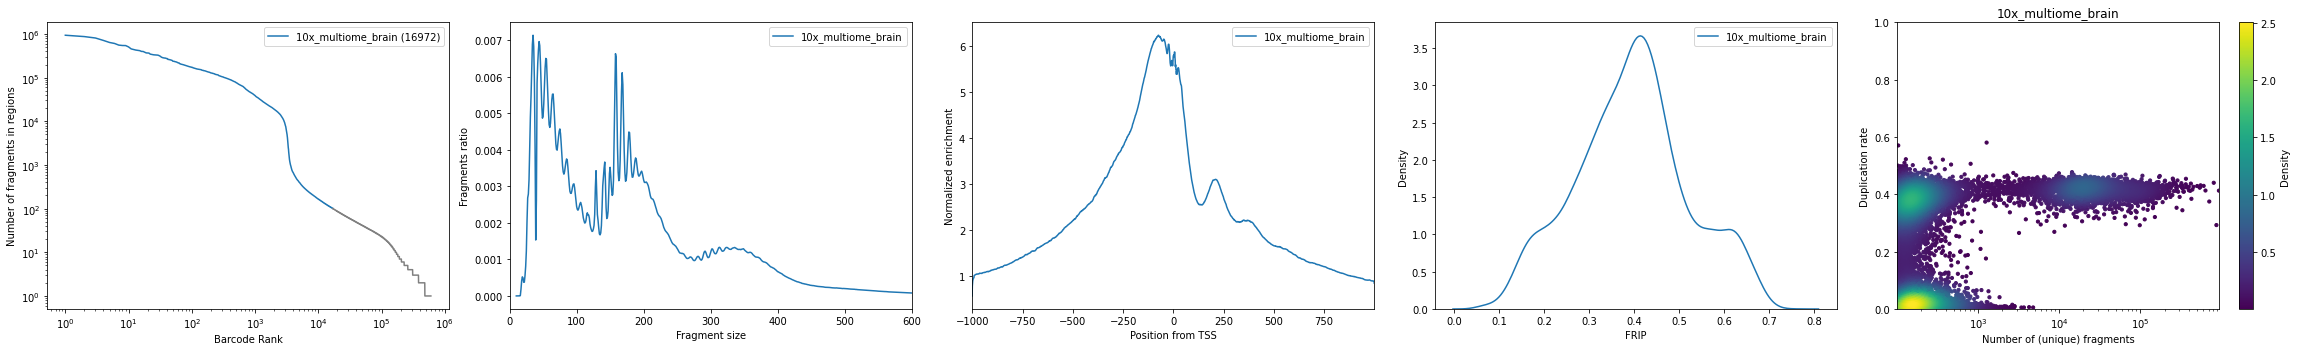

In [20]:
from pycisTopic.qc import *
plot_sample_metrics(profile_data_dict,
           insert_size_distriubtion_xlim=[0,600],
           ncol=5,
           plot=True,
           save= outDir + 'quality_control/sample_metrics.pdf')

[[Back to top]](#top)

<a class="anchor" id="stats_bc"></a>
#### 3b. Barcode level statistics

Barcode-level statistics can be used to select high quality cells. Typical measurements that can be used are:

* **Total number of (unique) fragments**
* **TSS enrichment**: The score at position in the TSS enrichmen score for for each barcode (at position 0, the TSS). Noisy cells will have a low TSS enrichment.
* **FRIP**: The fraction of reads in peaks for each barcode. Noisy cells have low FRIP values. However, this filter should be used with nuance, as it depends on the quality of the original peaks. For example, if there is a rare population in the sample, its specific peaks may be missed by peak calling algorithms, causing a decrease in their FRIP values.

In [1]:
# Load barcode metrics
import pickle
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()

In [2]:
# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_multiome_brain'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=3.5,
                                       max_x=None,
                                       min_y=0.2,
                                       max_y=None,
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False,
                                       save= outDir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_multiome_brain'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=4,
                                      max_y=None,
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False,
                                      save= outDir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['10x_multiome_brain'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=None,
                                      max_y=None,
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distribut

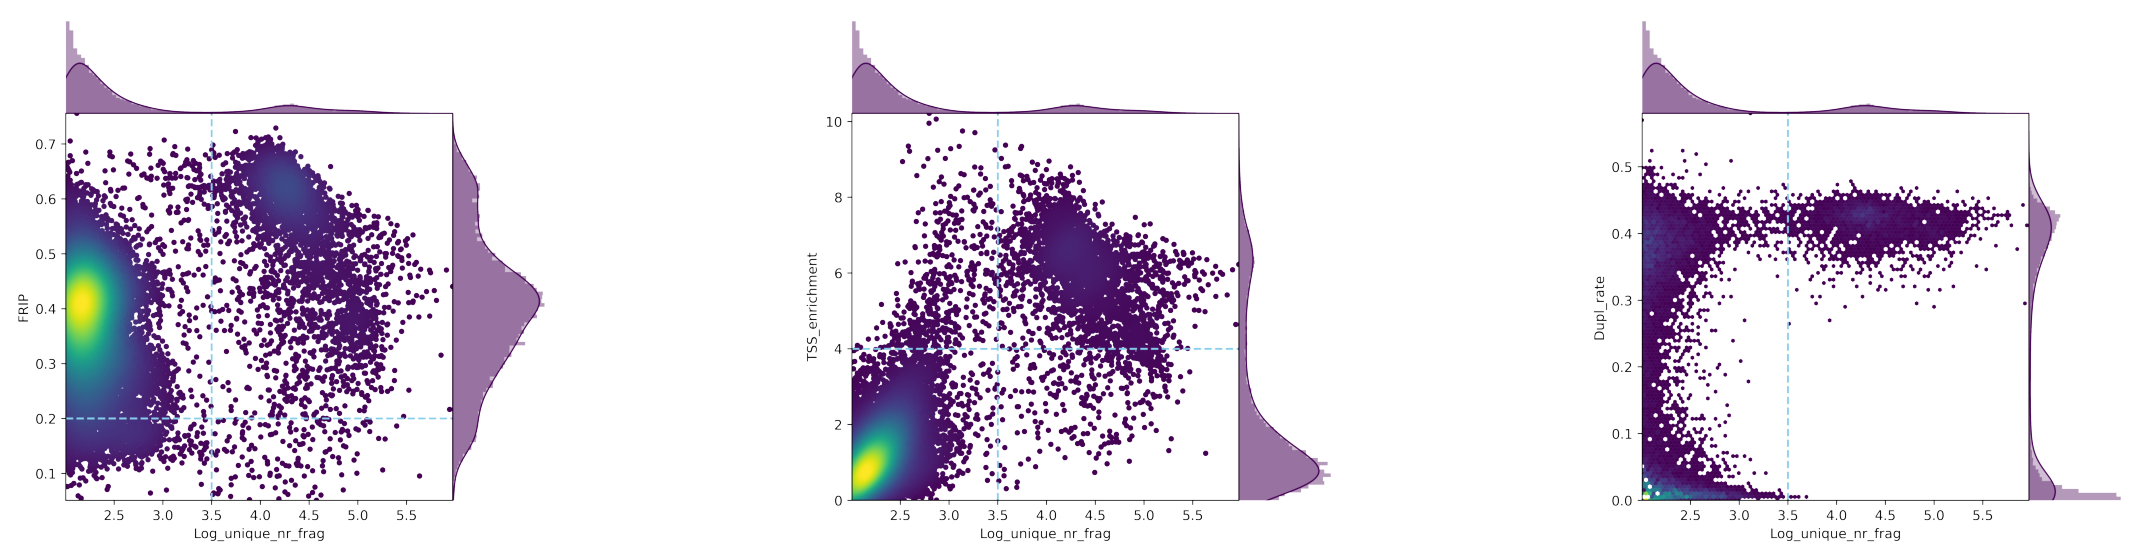

In [23]:
# Plot barcode stats in one figure
fig=plt.figure(figsize=(40,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

We select now the cells passing filters:

In [3]:
bc_passing_filters = {'10x_multiome_brain':[]}
bc_passing_filters['10x_multiome_brain'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
len(bc_passing_filters['10x_multiome_brain'])

We have a total of 2,925 selected barcodes. 

Of these, a total of 2,240 overlaps with high quality scRNA-seq barcodes. We will keep the additional barcodes for now.

In [5]:
# Get metadata from high-quality loom file
from pycisTopic.loom import *
path_to_annotated_rna_loom = projDir + 'output/rna/vsn/add_clusters_scrublet_as_annot/10x_multiome_brain_SCENIC_SCope_output_wAnnot_noDBL.loom'
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
cell_data = get_metadata(loom)
scRNA_bc=[re.sub("-10x_multiome_brain", "", x) for x in cell_data.index.tolist()]
len(list(set(bc_passing_filters['10x_multiome_brain']) & set(scRNA_bc)))

2240

In [27]:
import pickle 
with open(outDir + 'quality_control/bc_passing_filters.pkl', 'wb') as f:
  pickle.dump(bc_passing_filters, f)

[[Back to top]](#top)

<a class="anchor" id="create_object"></a>
### 4. Creating a cisTopic object

In this step a fragments count matrix will be generated, in which the fragments in each region for each barcode is indicated. If you would like to start from a precomputed fragments count matrix it is also possible (see advanced tutorial on *Initializing cisTopic objects*). For multiple samples, you can add additional entries in `fragment_dict`. As regions, we will use the consensus peaks derived from the scRNA-seq annotations. This cisTopic object will contain:

* Path/s to fragment file/s (if generated from fragments files)
* Fragment count matrix and binary accessibility matrix
* Cell and region metadata

In [18]:
# Path to regions
path_to_regions = outDir + 'consensus_peak_calling/consensus_regions.bed'
# Blacklist
path_to_blacklist = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Metrics
import pickle
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()
# Valid barcodes
import pickle
infile = open(outDir + 'quality_control/bc_passing_filters.pkl', 'rb')
bc_passing_filters = pickle.load(infile)
infile.close()
#Create objects
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions,
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc[key],
                                               valid_bc=bc_passing_filters[key],
                                               n_cpu=1,
                                               project=key,
                                               split_pattern='-') for key in fragments_dict.keys()]

2021-10-20 15:40:33,278 cisTopic     INFO     Reading data for 10x_multiome_brain
2021-10-20 15:44:00,778 cisTopic     INFO     metrics provided!
2021-10-20 15:44:14,656 cisTopic     INFO     valid_bc provided, selecting barcodes!
2021-10-20 15:44:28,411 cisTopic     INFO     Counting fragments in regions
2021-10-20 15:45:30,571 cisTopic     INFO     Creating fragment matrix
2021-10-20 15:47:24,137 cisTopic     INFO     Converting fragment matrix to sparse matrix
2021-10-20 15:47:44,189 cisTopic     INFO     Removing blacklisted regions
2021-10-20 15:47:46,614 cisTopic     INFO     Creating CistopicObject
2021-10-20 15:47:49,742 cisTopic     INFO     Done!


In this case we only have one sample, so only one cisTopic object has been generated. If you would have multiple samples, you would need to run the `merge()` function in your cisTopic object list. You can find more information in the advanced tutorial on *Initializing cisTopic objects*.

In [19]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project 10x_multiome_brain with n_cells × n_regions = 2925 × 435824


In [30]:
# Save
with open(outDir + '10x_multiome_brain_cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

[[Back to top]](#top)

<a class="anchor" id="add_metadata"></a>
### 5. Adding metadata to a cisTopic object

We can add additional metadata (for regions or cells) to a cisTopic object. For example, let's add the scRNA-seq data annotations. For those barcodes that did not pass the scRNA-seq values will be filled with `Nan`.

In [20]:
# Load cisTopic object
import pickle
infile = open(projDir + 'output/atac/pycistopic/10x_multiome_brain_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [23]:
# Get metadata from loom file
from pycisTopic.loom import *
path_to_annotated_rna_loom = projDir + "output/rna/seurat/10x_multiome_brain_Seurat.loom"
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
cell_data = get_metadata(loom)

The indexes in the pandas data frame to add can be **cell barcodes** (if the cisTopic object has been created from a fragments file only) or an **exact match with the cell names** in the cisTopic object (`cistopic_obj.cell_names`). 

In [24]:
cistopic_obj.add_cell_data(cell_data, split_pattern='-')


Columns ['Seurat_cell_type', 'VSN_sample_id', 'VSN_leiden_res0.9', 'VSN_leiden_res0.6', 'Seurat_leiden_res1.2', 'VSN_leiden_res1.2', 'VSN_cell_type', 'Seurat_leiden_res0.6', 'VSN_leiden_res0.3'] will be overwritten


In [25]:
cistopic_obj.cell_data

cisTopic_nr_frag  Unique_nr_frag  \
CACCTCAGTTGTAAAC-1-10x_multiome_brain            18291           30052   
TGACTCCTCATCCACC-1-10x_multiome_brain           100115          177932   
TTTCTCACATAAACCT-1-10x_multiome_brain            32144           67109   
GTCCTCCCACACAATT-1-10x_multiome_brain            88467          174752   
CTCCGTCCAGTTTGTG-1-10x_multiome_brain           131129          232359   
...                                                ...             ...   
GGCTCACAGGCCCAGT-1-10x_multiome_brain             6184           17298   
AAGCTCCCAGCACCAT-1-10x_multiome_brain             2189            5832   
TAGCCTGAGGTGAGAC-1-10x_multiome_brain             2942            4767   
GCAGGTTGTCCAAATG-1-10x_multiome_brain             2773            4043   
GTGCGCAGTGCTTAGA-1-10x_multiome_brain             5841           14736   

                                       Dupl_nr_frag  Total_nr_frag  \
CACCTCAGTTGTAAAC-1-10x_multiome_brain         17889          47941   
TGACTCCTCATCCACC-1-10x_multiome_brain        133595         311527   
TTTCTCACATAAACCT-1-10x_multiome_brain         43740         110849   
GTCCTCCCACACAATT-1-10x_multiome_brain        151171         325923   
CTCCGTCCAGTTTGTG-1-10x_multiome_brain        173523         405882   
...                                             ...            ...   
GGCTCACAGGCCCAGT-1-10x_multiome_brain          9268          26566   
AAGCTCCCAGCACCAT-1-10x_multiome_brain          4073           9905   
TAGCCTGAGGTGAGAC-1-10x_multiome_brain          3776           8543   
GCAGGTTGTCCAAATG-1-10x_multiome_brain          3127           7170   
GTGCGCAGTGCTTAGA-1-10x_multiome_brain         10460          25196   

                                       Log_total_nr_frag  \
CACCTCAGTTGTAAAC-1-10x_multiome_brain           4.680707   
TGACTCCTCATCCACC-1-10x_multiome_brain           5.493496   
TTTCTCACATAAACCT-1-10x_multiome_brain           5.044732   
GTCCTCCCACACAATT-1-10x_multiome_brain           5.513115   
CTCCGTCCAGTTTGTG-1-10x_multiome_brain           5.608400   
...                                                  ...   
GGCTCACAGGCCCAGT-1-10x_multiome_brain           4.424326   
AAGCTCCCAGCACCAT-1-10x_multiome_brain           3.995854   
TAGCCTGAGGTGAGAC-1-10x_multiome_brain           3.931610   
GCAGGTTGTCCAAATG-1-10x_multiome_brain           3.855519   
GTGCGCAGTGCTTAGA-1-10x_multiome_brain           4.401332   

                                      Predicted_doublets_fragments  \
CACCTCAGTTGTAAAC-1-10x_multiome_brain                        False   
TGACTCCTCATCCACC-1-10x_multiome_brain                        False   
TTTCTCACATAAACCT-1-10x_multiome_brain                        False   
GTCCTCCCACACAATT-1-10x_multiome_brain                        False   
CTCCGTCCAGTTTGTG-1-10x_multiome_brain                        False   
...                                                            ...   
GGCTCACAGGCCCAGT-1-10x_multiome_brain                        False   
AAGCTCCCAGCACCAT-1-10x_multiome_brain                        False   
TAGCCTGAGGTGAGAC-1-10x_multiome_brain                        False   
GCAGGTTGTCCAAATG-1-10x_multiome_brain                        False   
GTGCGCAGTGCTTAGA-1-10x_multiome_brain                        False   

                                                  barcode cisTopic_log_nr_acc  \
CACCTCAGTTGTAAAC-1-10x_multiome_brain  CACCTCAGTTGTAAAC-1            4.191814   
TGACTCCTCATCCACC-1-10x_multiome_brain  TGACTCCTCATCCACC-1            4.794586   
TTTCTCACATAAACCT-1-10x_multiome_brain  TTTCTCACATAAACCT-1             4.43101   
GTCCTCCCACACAATT-1-10x_multiome_brain  GTCCTCCCACACAATT-1            4.765832   
CTCCGTCCAGTTTGTG-1-10x_multiome_brain  CTCCGTCCAGTTTGTG-1            4.895152   
...                                                   ...                 ...   
GGCTCACAGGCCCAGT-1-10x_multiome_brain  GGCTCACAGGCCCAGT-1            3.757624   
AAGCTCCCAGCACCAT-1-10x_multiome_brain  AAGCTCCCAGCACCAT-1            3.311542   
TAGCCTGAGGTGAGAC-

[[Back to top]](#top)

<a class="anchor" id="scrublet"></a>
### 6. Running scrublet in a cisTopic object

Optionally, you can run also scrublet on the fragment count matrix to infer doublets from the scATAC-seq. 

In [16]:
import scrublet as scr
scrub = scr.Scrublet(cistopic_obj.fragment_matrix.T, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.plot_histogram();
scrub.call_doublets(threshold=0.22)
scrub.plot_histogram();
scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T

Preprocessing...


/opt/venv/lib/python3.8/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 2.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.7%
Elapsed time: 29.4 seconds
Detected doublet rate = 21.6%
Estimated detectable doublet fraction = 67.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 32.1%


In [17]:
cistopic_obj.add_cell_data(scrublet, split_pattern = '-')

Cells called as doublets:

In [18]:
sum(cistopic_obj.cell_data.Predicted_doublets_fragments == True)

633

In [19]:
# Save with doublets
with open(outDir + '10x_multiome_brain_cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

We can subset all cells marked as singlets from the cisTopic object.

In [39]:
# Remove doublets 
singlets = cistopic_obj.cell_data[cistopic_obj.cell_data.Predicted_doublets_fragments == False].index.tolist()
# Subset cisTopic object
cistopic_obj_noDBL = cistopic_obj.subset(singlets, copy=True, split_pattern='-')
print(cistopic_obj_noDBL)

CistopicObject from project 10x_multiome_brain with n_cells × n_regions = 2292 × 435822


In [41]:
# Save without doublets
with open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'wb') as f:
  pickle.dump(cistopic_obj_noDBL, f)

We can also take only cells overlapping with high quality cells in the scRNA-seq. In total, there are 1,736 cells.

In [22]:
# Remove cells without rna counterpart
rna_cells = cistopic_obj_noDBL.cell_data.dropna().index.tolist()
# Subset cisTopic object
cistopic_obj_noDBL_wRNA = cistopic_obj_noDBL.subset(rna_cells, copy=True, split_pattern='-')
print(cistopic_obj_noDBL_wRNA)

CistopicObject from project 10x_multiome_brain with n_cells × n_regions = 1736 × 435814


In [23]:
# Save without doublets
with open(projDir + 'output/atac/pycistopic/10x_multiome_brain_cisTopicObject_noDBL_wRNA.pkl', 'wb') as f:
  pickle.dump(cistopic_obj_noDBL_wRNA, f)

[[Back to top]](#top)

<a class="anchor" id="run_models"></a>
### 7. Run models

The next step is to run the LDA models. There are two types of LDA models (with Collapsed Gibbs Sampling) you can run:

* **Serial LDA**: The parallelization is done between models rather than within each model. Recommended for small-medium sized data sets in which several models with different number os topics are being tested. You can run these models with `runCGSModels()`.
* **Parallel LDA with MALLET**: The parallelization is done within each model. Recommended for large data sets where a few models with different number of topics are being tested. If working in a cluster, we recommed to submit a job per model so they can run simultaneously. You can run it with `runCGSModelsMallet()`.

In this tutorial we will use the output of `runCGSModelsMallet()`. For more details in how to run models, see the advanced tutorial on *Running LDA models*.

In [37]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

<a class="anchor" id="cgs"></a>
#### 7a. Serial LDA with Collapsed Gibbs Sampling

In [79]:
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,5,10,15,20,25],
                    n_cpu=6,
                    n_iter=100,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = tmpDir)

2021-01-26 17:52:50,478	INFO resource_spec.py:212 -- Starting Ray with 499.37 GiB memory available for workers and up to 186.26 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-01-26 17:52:51,213	WARNING services.py:923 -- Redis failed to start, retrying now.
2021-01-26 17:52:52,152	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


(pid=779) 2021-01-26 17:53:25,832 cisTopic     INFO     Running model with 2 topics
(pid=784) 2021-01-26 17:53:25,831 cisTopic     INFO     Running model with 10 topics
(pid=783) 2021-01-26 17:53:25,831 cisTopic     INFO     Running model with 15 topics
(pid=780) 2021-01-26 17:53:25,833 cisTopic     INFO     Running model with 5 topics
(pid=782) 2021-01-26 17:53:25,831 cisTopic     INFO     Running model with 20 topics
(pid=785) 2021-01-26 17:53:25,829 cisTopic     INFO     Running model with 25 topics
(pid=779) 2021-01-26 18:05:55,065 cisTopic     INFO     Model with 2 topics done!
(pid=780) 2021-01-26 18:10:09,850 cisTopic     INFO     Model with 5 topics done!
(pid=784) 2021-01-26 18:15:52,994 cisTopic     INFO     Model with 10 topics done!
(pid=783) 2021-01-26 18:21:18,347 cisTopic     INFO     Model with 15 topics done!
(pid=782) 2021-01-26 18:26:05,991 cisTopic     INFO     Model with 20 topics done!
(pid=785) 2021-01-26 18:34:25,387 cisTopic     INFO     Model with 25 topics do

In [81]:
# Save
with open(outDir + 'models/10x_multiome_brain_models_100_iter_noDBL.pkl', 'wb') as f:
  pickle.dump(models, f)

If you are working on a cluster and want to run several models, we recommend to submit this step as a job. You can use the `runModels_lda.py` script.

In [ ]:
#!/bin/bash -l
## Job will last 6 hours.
#PBS -l walltime=6:00:00
## Job needs 1 nodes and 24 cores per node.
#PBS -l nodes=1:ppn=28
## Job request memory
#PBS -lmem=180gb # or 180gb
## Specify project credits name to use credits for running the job.
#PBS -A lp_symbiosys
## Batch job name.
#PBS -N 10x_multiomics_brain
## Email options.
#PBS -m abe
#PBS -M carmen.bravogonzalezblas@kuleuven.vib.be

module load Python/3.7.4-foss-2018a
cd /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic
singularity exec -B /lustre1,/staging,/data,/vsc-hard-mounts,/scratch pycistopic.sif python pycisTopic/job_template/runModels_lda.py \
        -i /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/10x_multiome_brain_cisTopicObject_noDBL.pkl \
        -o /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/models/10x_multiome_brain_models_500_iter_noDBL.pkl \
        -nt 2,5,10,15,20,25,30,35,40,45,50 \
        -c 11 \
        -it 500 \
        -a 50 \
        -abt True \
        -e 0.1 \
        -ebt False \
        -sp None \
        -s 555

<a class="anchor" id="mallet"></a>
#### 7b. Parallel LDA with Mallet

Mallet provides a faster implementation of LDA, that allows to run calculations in parallel within a model. This option is strongly recommended with large data sets. To run mallet, you can use `runCGSModelsMallet()`.

In [ ]:
# Load functions 
from pycisTopic.lda_models import *
# Configure path Mallet
path_to_mallet_binary='mallet'
# Run models
models=run_cgs_models_mallet(path_to_mallet_binary,
                    cistopic_obj,
                    n_topics=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                    n_cpu=12,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    tmp_path=tmpDir + 'tmp/mallet/tutorial/', #Use SCRATCH if many models or big data set
                    save_path=tmpDir + 'tmp/mallet/tutorial/')

In [ ]:
# Save
with open(outDir + 'models/10x_multiome_brain_models_500_iter_noDBL_mallet.pkl', 'wb') as f:
  pickle.dump(models, f)

[[Back to top]](#top)

<a class="anchor" id="model_selection"></a>
### 8. Model selection

There are several methods that can be used for model selection:

* **Minmo_2011**: Uses the average model coherence as calculated by Mimno et al (2011). In order to reduce the impact of the number of topics, we calculate the average coherence based on the top selected average values. The better the model, the higher coherence.
* **Log-likelihood**: Uses the log-likelihood in the last iteration as calculated by Griffiths and Steyvers (2004). The better the model, the higher the log-likelihood.
* **Arun_2010**: Uses a density-based metric as in Arun et al (2010) using the topic-region distribution, the cell-topic distribution and the cell coverage. The better the model, the lower the metric.
* **Cao_Juan_2009**: Uses a divergence-based metric as in Cao Juan et al (2009) using the topic-region distribution. The better the model, the lower the metric.

For scATAC-seq data models, the most helpful methods are Minmo (topic coherence) and the log-likelihood in the last iteration.

In [42]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [43]:
# Load models
from pycisTopic.lda_models import *
import pickle
infile = open(projDir + 'output/atac/pycistopic_v1/models/10x_multiome_brain_models_500_iter_noDBL.pkl', 'rb')
models = pickle.load(infile)
infile.close()

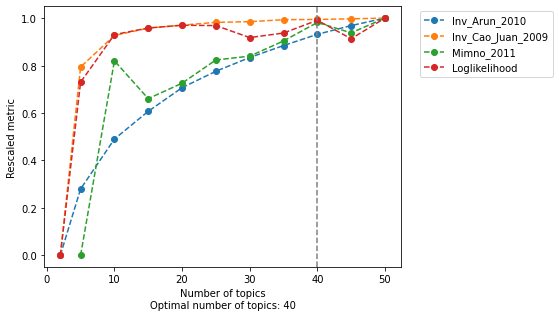

In [44]:
model=evaluate_models(models,
                     select_model=40, 
                     return_model=True, 
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     save= outDir + 'models/model_selection.pdf')

In [45]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Add model to cisTopicObject
cistopic_obj.add_LDA_model(model)

In [46]:
# Save
with open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

[[Back to top]](#top)

<a class="anchor" id="clustering"></a>
### 9. Clustering and visualization

<a class="anchor" id="atac"></a>
#### 9a. Visualizing ATAC-seq data

We can cluster the cells (or regions) using the leiden algorithm, and perfor dimensionality reductiion with UMAP and TSNE. In these examples we will focus on the cells only. For these steps, the cell-topic contriibutions of the model will be used.

In [61]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [66]:
from pycisTopic.clust_vis import *
find_clusters(cistopic_obj,
                 target  = 'cell',
                 k = 10,
                 res = [0.6, 1.2], 
                 prefix = 'pycisTopic_', 
                 scale = True,
                 split_pattern = '-')

2021-08-12 14:48:18,460 cisTopic     INFO     Finding neighbours


In [67]:
run_umap(cistopic_obj,
                 target  = 'cell', scale=True)

2021-08-12 14:48:19,727 cisTopic     INFO     Running UMAP


In [68]:
run_tsne(cistopic_obj,
                 target  = 'cell', scale=True)

2021-08-12 14:48:29,835 cisTopic     INFO     Running FItSNE

Symmetrizing...
Using the given initialization.
Exaggerating Ps by 12.000000
Input similarities computed (sparsity = 0.056813)!
Learning embedding...
Using FIt-SNE approximation.
Iteration 50 (50 iterations in 0.51 seconds), cost 3.111970
Iteration 100 (50 iterations in 0.51 seconds), cost 2.672032
Iteration 150 (50 iterations in 0.52 seconds), cost 2.630175
Iteration 200 (50 iterations in 0.52 seconds), cost 2.619282
Iteration 250 (50 iterations in 0.52 seconds), cost 2.597080
Unexaggerating Ps by 12.000000
Iteration 300 (50 iterations in 0.53 seconds), cost 1.644027
Iteration 350 (50 iterations in 0.52 seconds), cost 1.422180
Iteration 400 (50 iterations in 0.52 seconds), cost 1.296824
Iteration 450 (50 iterations in 0.63 seconds), cost 1.245667
Iteration 500 (50 iterations in 0.84 seconds), cost 1.227273
Iteration 550 (50 iterations in 0.97 seconds), cost 1.206618
Iteration 600 (50 iterations in 1.11 seconds), cost 1.2138

The clustering assignments are added to `cistopic_obj.cell_data` and the projections to `cistopic_obj.projections['cell']`. If you would like to add additional dimensionality reductions, you can just add them as an entry to the projections dictionary (under 'cell' in this case).

We can also visualize metadata (categorical or continuous) on the UMAP/tSNE spaces.

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:472: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


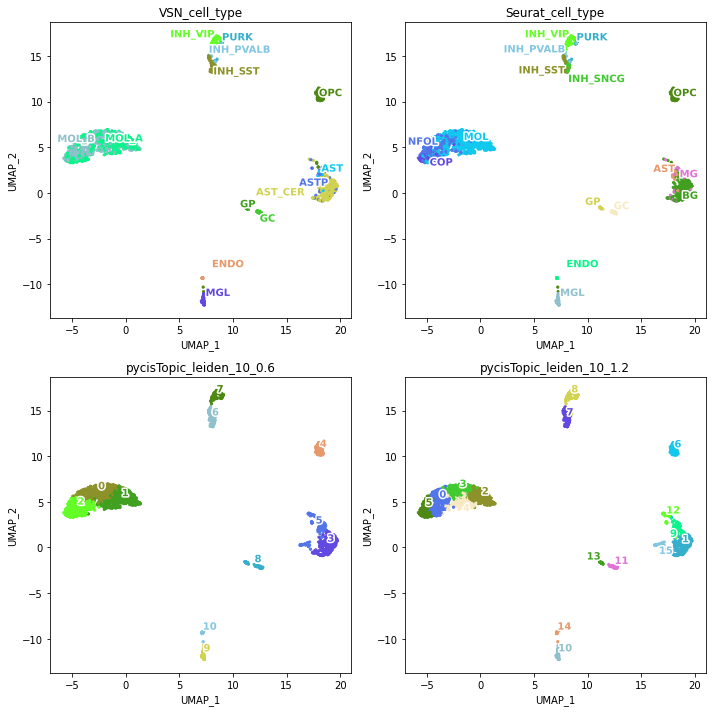

In [150]:
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['VSN_cell_type', 'Seurat_cell_type', 'pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_1.2'], # Labels from RNA and new clusters
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=5,
                 figsize=(10,10),
                 save= outDir + 'visualization/dimensionality_reduction_label.pdf')

In [151]:
annot_dict={}
annot_dict['pycisTopic_leiden_10_0.6'] = {'0':'NFOL (0)', '1':'MOL (1)', '2': 'COP (2)', '3': 'BG (3)', '4': 'OPC (4)', '5': 'MG (5)', '6': 'INH_MGE  (6)', '7': 'INH_CGE (7)', '8': 'GC (8)',
                                                 '9': 'MGL (9)', '10': 'ENDO (10)'}
annot_dict['pycisTopic_leiden_10_1.2'] = {'0':'COP_2 (0)', '1':'BG (1)', '2': 'MOL (2)', '3': 'NFOL_1 (3)', '4': 'NFOL_2 (4)', '5': 'COP_2 (5)', '6': 'OPC (6)', '7': 'INH_MGE (7)', '8': 'INH_CGE (8)',
                                                 '9': 'MG (9)', '10': 'MGL (10)', '11': 'GC (11)', '12': 'AST (12)', '13': 'GP (13)', '14': 'ENDO', '15': 'DBL'}
cistopic_obj.cell_data['pycisTopic_leiden_10_0.6'] = [annot_dict['pycisTopic_leiden_10_0.6'][x] for x in cistopic_obj.cell_data['pycisTopic_leiden_10_0.6'].tolist()]
cistopic_obj.cell_data['pycisTopic_leiden_10_1.2'] = [annot_dict['pycisTopic_leiden_10_1.2'][x] for x in cistopic_obj.cell_data['pycisTopic_leiden_10_1.2'].tolist()]

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:472: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


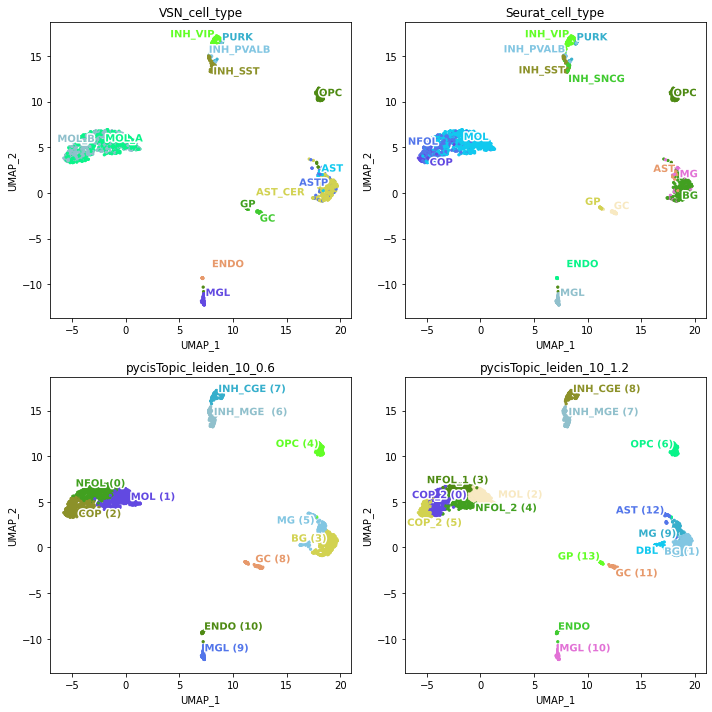

In [152]:
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['VSN_cell_type', 'Seurat_cell_type', 'pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_1.2'], # Labels from RNA and new clusters
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=5,
                 figsize=(10,10),
                 save= outDir + 'visualization/dimensionality_reduction_label.pdf')

We can also check other statistics. For example, here we see that many of the non-matching cells with the RNA profiles have a high number of fragments and high doublet scores.

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:525: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


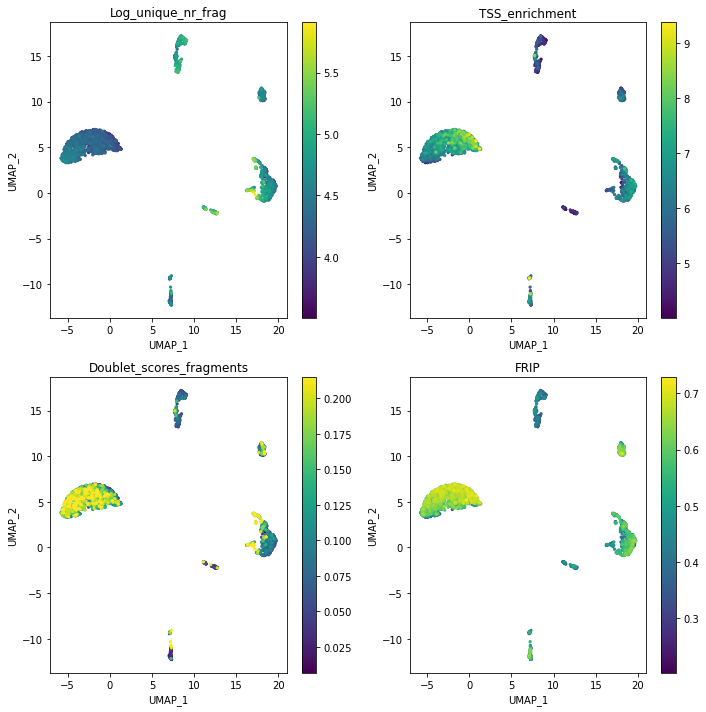

In [73]:
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['Log_unique_nr_frag', 'TSS_enrichment', 'Doublet_scores_fragments', 'FRIP'], 
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=5,
                 figsize=(10,10),
                 save= outDir + 'visualization/dimensionality_reduction_number.pdf')

We can also plot the topic-contributions.

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:649: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


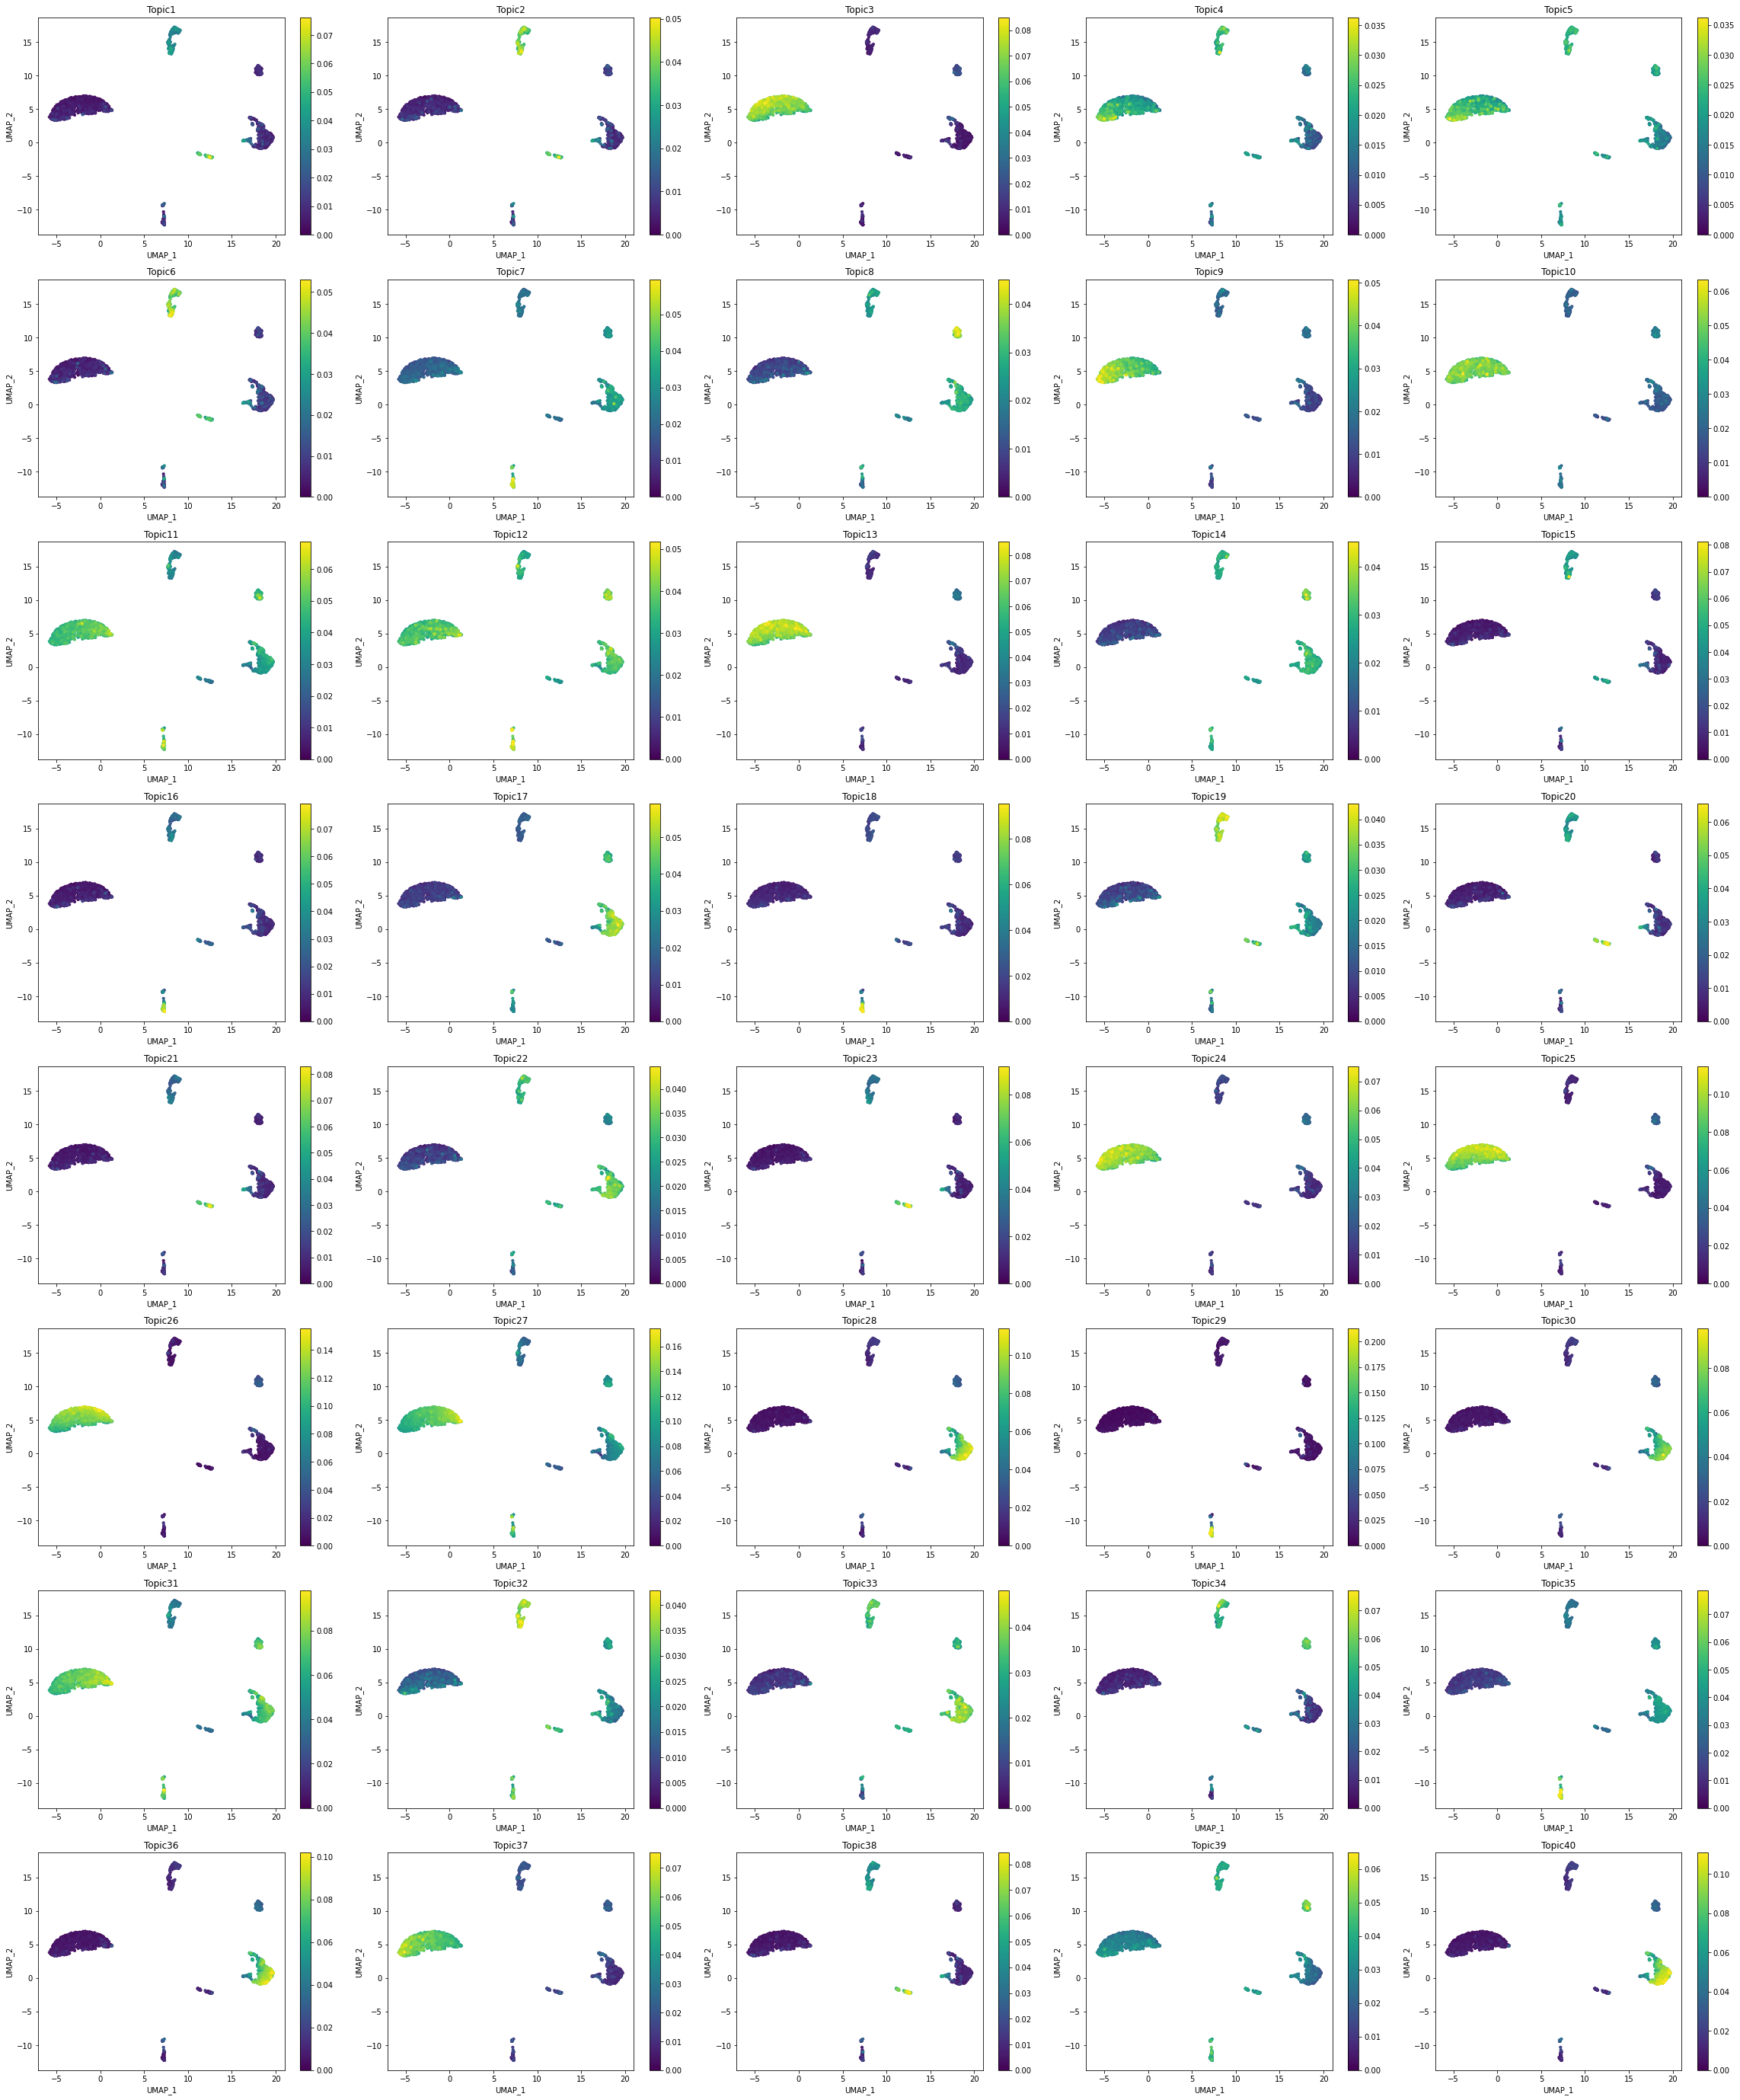

In [74]:
plot_topic(cistopic_obj,
            reduction_name = 'UMAP',
            target = 'cell',
            num_columns=5,
            save= outDir + 'visualization/dimensionality_reduction_topic_contr.pdf')

Or we can also draw a heatmap with the topic contributions (and annotations).

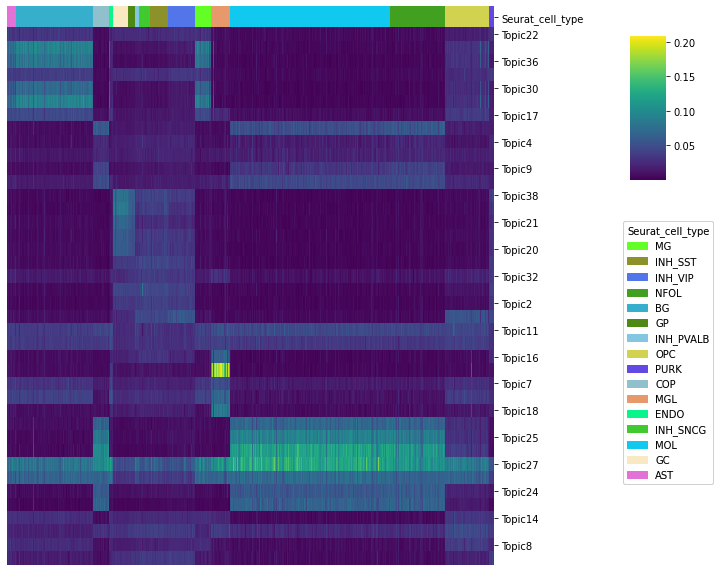

In [148]:
cell_topic_heatmap(cistopic_obj,
                     variables = ['Seurat_cell_type'],
                     scale = False,
                     legend_loc_x = 1.05,
                     legend_loc_y = -1.2,
                     legend_dist_y = -1,
                     figsize=(10,10),
                     save = outDir + 'visualization/heatmap_topic_contr.pdf')

In [77]:
# Save
with open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

[[Back to top]](#top)

<a class="anchor" id="integration"></a>
#### 9b. Co-clustering and dimensionality reduction using scRNA-seq

When combining data originating from different statistical distributions, it is probably not a good idea to simply concatenate them together without taking into account their individual distributions as some of them might be of binary, categorical or continuous nature. This is the case when we compare scRNA-seq data (negative binomial) and scATAC-seq data (binary). We can convert these data set into a common non-parametric space where they loose the memory about their technology of origin using graph-based integration. When having been converted into graphs, the individual data sets represent pairwise connections between data points without any “memory” of what statistical process generated the individual data sets. In the graph space, it is straightforward to find an intersection between individual graphs from individual data sets by keeping edges consistently present between the data points across the graphs from individual data sets. The strength of this approach is that one can apply an appropriate distance metric when converting the raw data into graphs, i.e. working with binary data one might want to use the Hamming distance to compute pairwise connections between data points, while working with continuous data it might be sufficient to apply the Euclidean distance. In this section we use this approach, using UMAP to build fuzzy simplicial sets (similar to KNN graphs), that can be used for integrated clustering and dimensionality reduction.

#### a. VSN embedding

We will integrate the cell-topic (pycisTopic) and the cell-PCs (Scanpy) matrices rather than the raw omics data.

In [123]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [153]:
# Load processed scRNA-seq data
import scanpy
import pandas as pd
infile = projDir + 'output/rna/vsn/single_sample_scrublet/out/data/intermediate/1.0.0.SC__SCANPY__DIM_REDUCTION_PCA.h5ad'
vsn_obj = scanpy.read_h5ad(infile)
# Format names
rna_cell_names = vsn_obj.obs.index.tolist()
rna_cell_names = [x.replace('-1.0.0', '-1-10x_multiome_brain') for x in rna_cell_names]
rna_pca = pd.DataFrame(vsn_obj.obsm['X_pca'])
rna_pca.index = rna_cell_names
rna_pca.columns = ['PC' + str(x) for x in range(1,vsn_obj.obsm['X_pca'].shape[1]+1)]

With the parameter `rna_weight` we can also specify if any of the omics layers should have more weight than the other. Since the scATAC-seq layer in this data set is quite sparse, we will apply a 0.8 rna layer weight (0.2 atac layer weight).

In [125]:
from pycisTopic.clust_vis import *
find_clusters(cistopic_obj, k=100, rna_components=rna_pca, rna_weight = 0.8, prefix='VSN_RNA+ATAC_', res=[2], split_pattern='-')

2021-08-12 15:10:06,185 cisTopic     INFO     Finding neighbours
2021-08-12 15:10:06,732 cisTopic     INFO     Finding clusters



In [126]:
run_umap(cistopic_obj, rna_components=rna_pca, rna_weight = 0.8, reduction_name='VSN_RNA+ATAC_UMAP', split_pattern='-')

2021-08-12 15:10:11,115 cisTopic     INFO     Running UMAP


/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:472: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


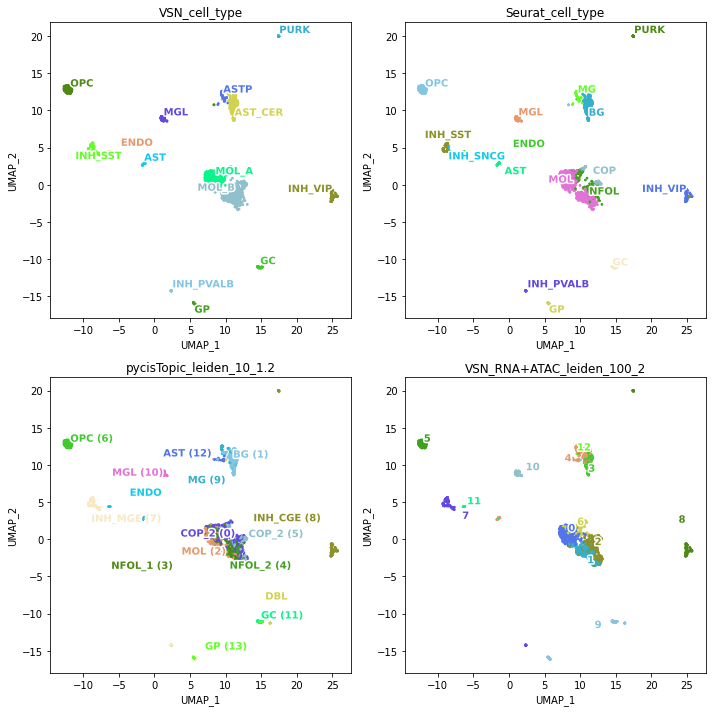

In [155]:
plot_metadata(cistopic_obj,
                 reduction_name='VSN_RNA+ATAC_UMAP',
                 variables=['VSN_cell_type', 'Seurat_cell_type', 'pycisTopic_leiden_10_1.2','VSN_RNA+ATAC_leiden_100_2'], # Labels from RNA and new clusters
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=3,
                 figsize=(10,10))

In [156]:
annot_dict={}
annot_dict['VSN_RNA+ATAC_leiden_100_2'] = {'0':'MOL_A (0)', '1':'MOL_B (1)', '2': 'NFOL_B (2)', '3': 'BG (3)', '4': 'MG (4)', '5': 'OPC (5)', '6': 'NFOL_A  (6)', '7': 'INH_MGE (7)', '8': 'INH_CGE (8)',
                                                 '9': 'GC (9)', '10': 'MGL (10)', '11': 'ENDO (11)', '12':'AST (12)'}
cistopic_obj.cell_data['VSN_RNA+ATAC_leiden_100_2'] = [annot_dict['VSN_RNA+ATAC_leiden_100_2'][x] if x == x else np.nan for x in cistopic_obj.cell_data['VSN_RNA+ATAC_leiden_100_2'].tolist() ]

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:472: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


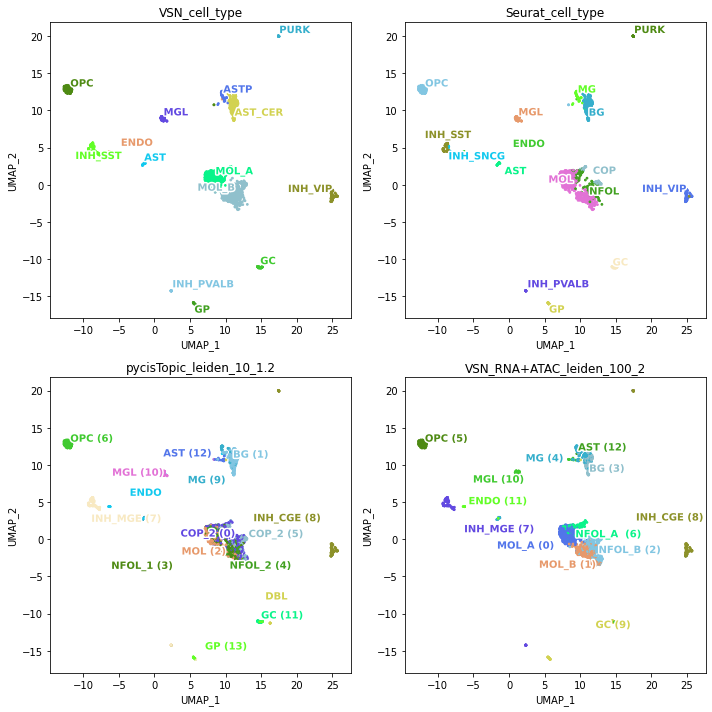

In [157]:
plot_metadata(cistopic_obj,
                 reduction_name='VSN_RNA+ATAC_UMAP',
                 variables=['VSN_cell_type', 'Seurat_cell_type', 'pycisTopic_leiden_10_1.2','VSN_RNA+ATAC_leiden_100_2'], # Labels from RNA and new clusters
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=3,
                 figsize=(10,10))

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:649: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


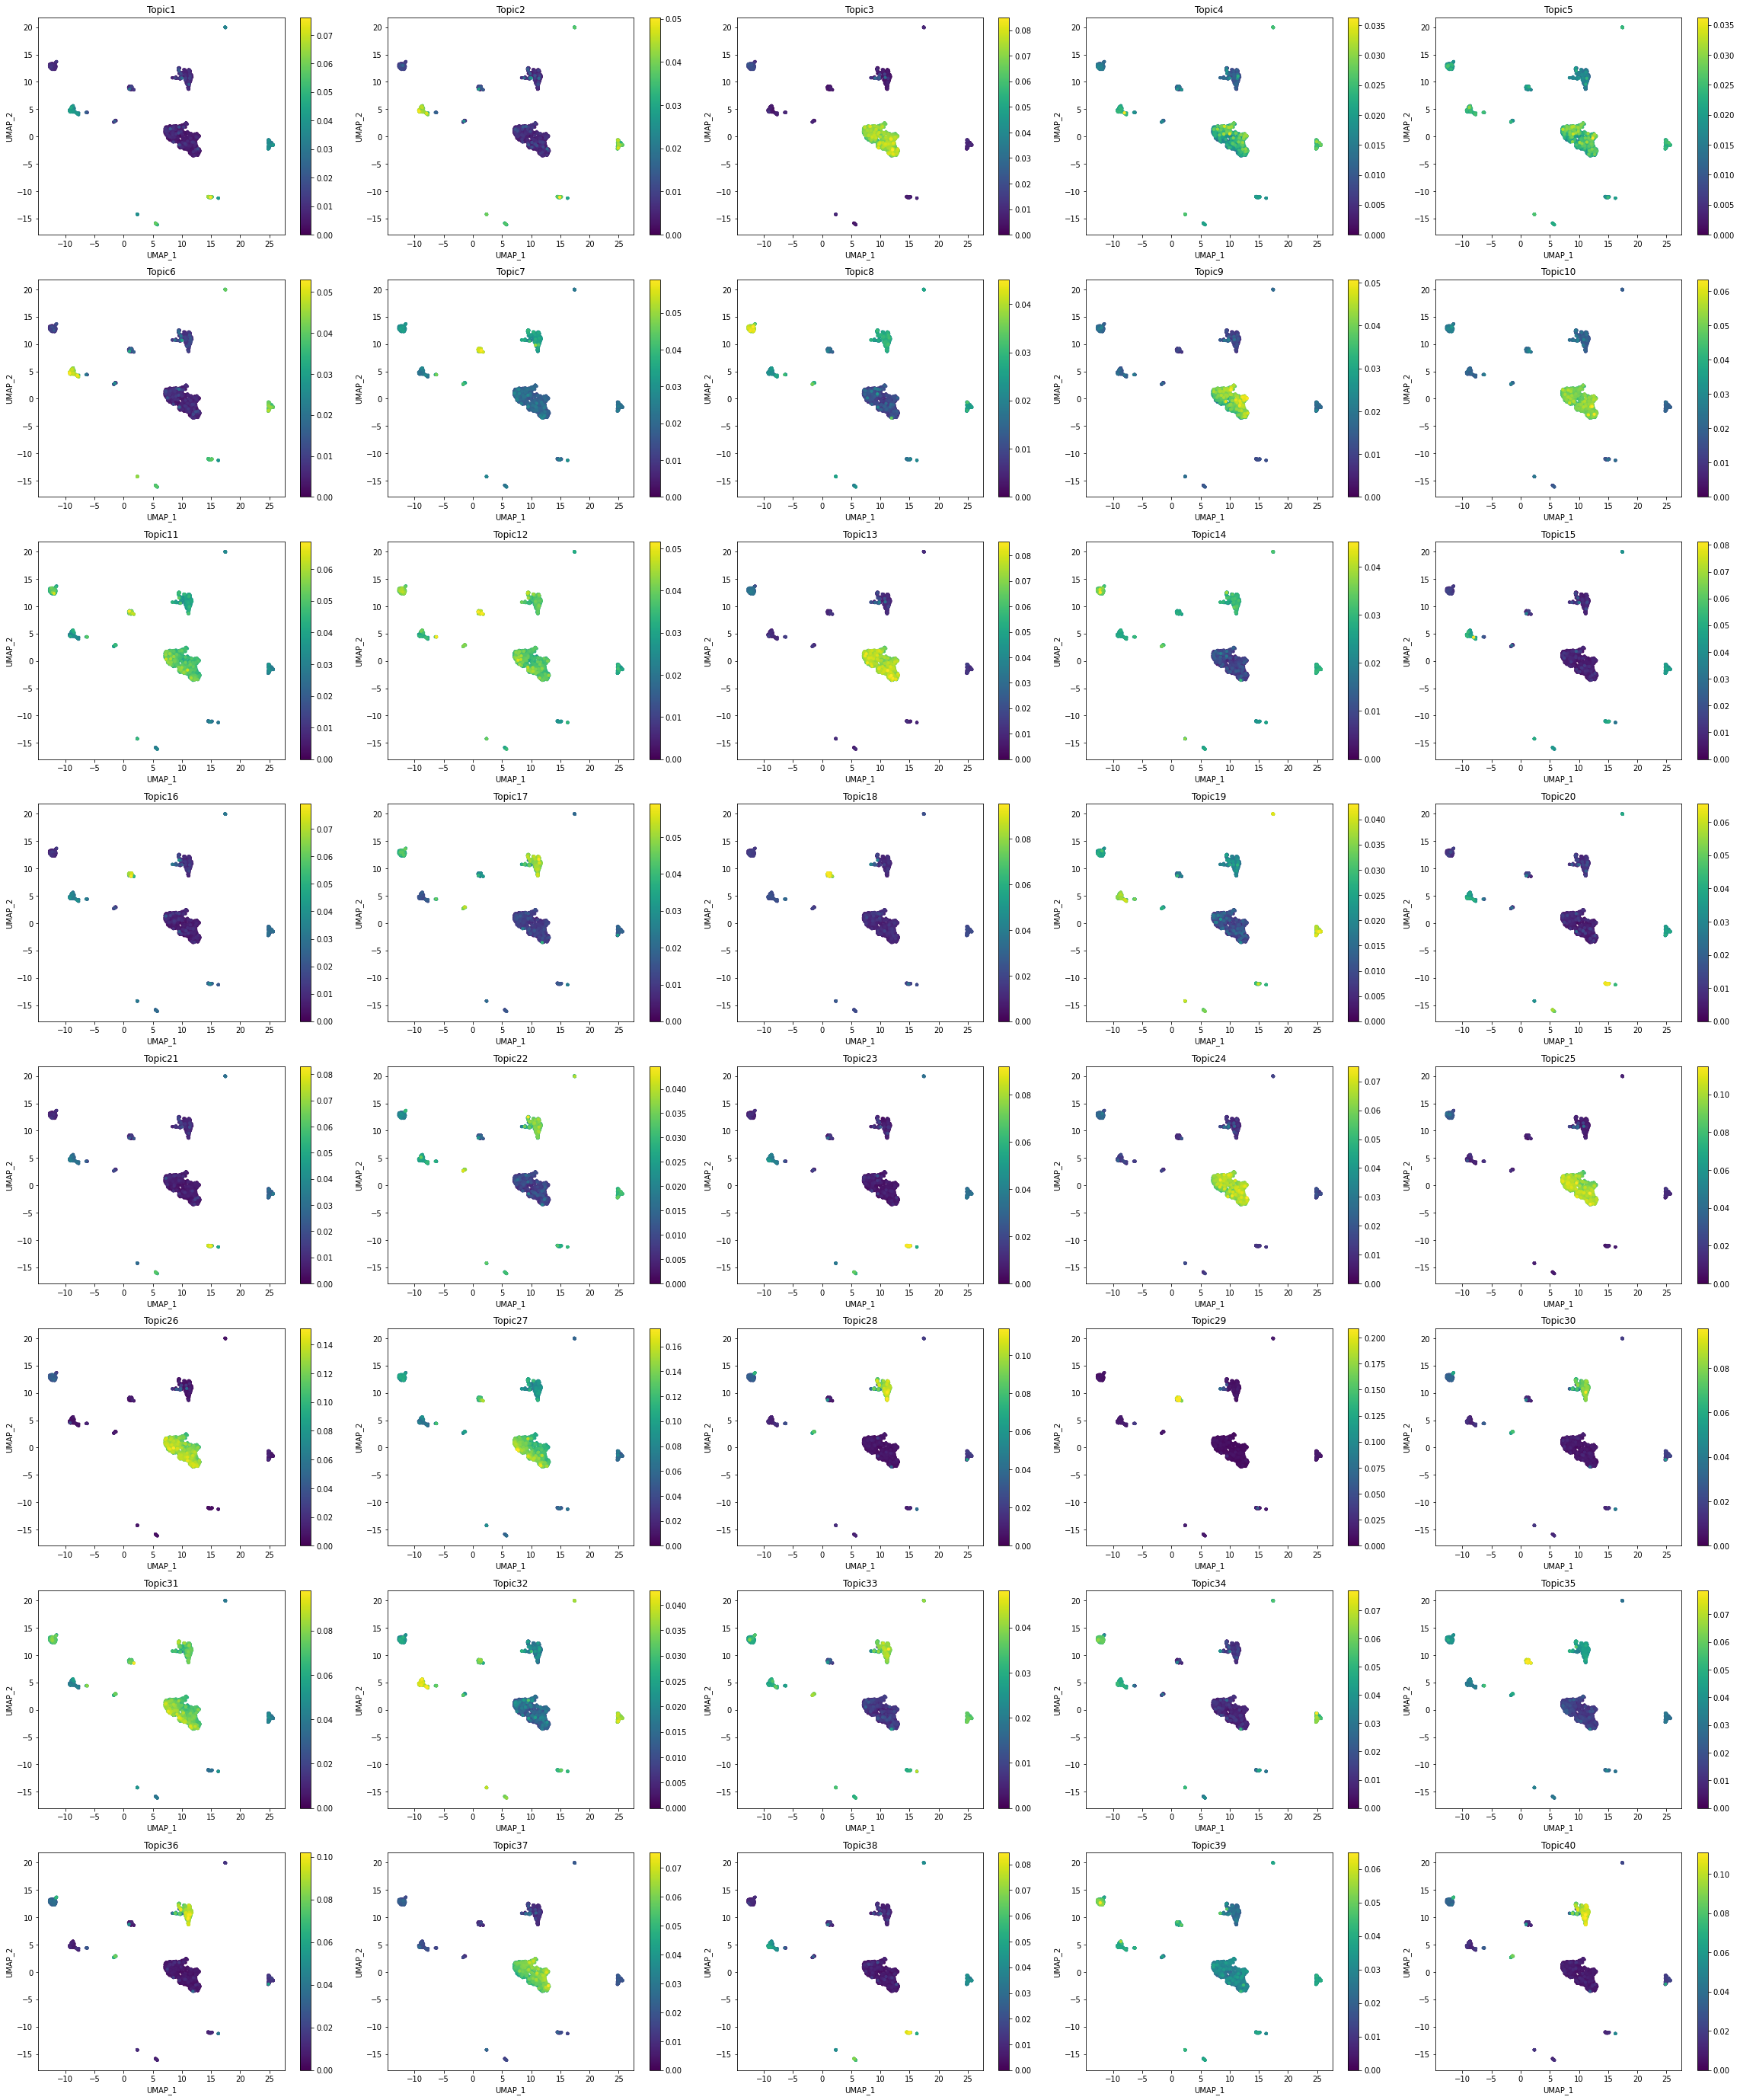

In [130]:
plot_topic(cistopic_obj, reduction_name='VSN_RNA+ATAC_UMAP', num_columns=5)

In [131]:
# Save
with open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

#### b. Seurat embedding

We will integrate the cell-topic (pycisTopic) and the cell-PCs (Seurat) matrices rather than the raw omics data.

In [132]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [158]:
# Load processed scRNA-seq data
import pandas as pd
infile = projDir + 'output/rna/seurat/Seurat_obj_PCs.txt'
rna_pca = pd.read_csv(infile, sep='\t')
rna_pca

PC_1       PC_2       PC_3  \
AAACAGCCATTATGCG-1-10x_multiome_brain  12.144421   7.346593  -2.628920   
AAACCAACATAGACCC-1-10x_multiome_brain  12.120382   8.027439  -1.776988   
AAACCGAAGATGCCTG-1-10x_multiome_brain -31.238523   4.945642   0.151035   
AAACCGAAGTTAGCTA-1-10x_multiome_brain  12.659729   8.139916  -2.323249   
AAACCGCGTTAGCCAA-1-10x_multiome_brain   9.707681  -2.732937  59.389717   
...                                          ...        ...        ...   
TTTGTGAAGGGTGAGT-1-10x_multiome_brain  -7.569330   4.964487  -2.602129   
TTTGTGAAGTCAGGCC-1-10x_multiome_brain   5.460925 -24.733726  -5.114872   
TTTGTGGCATGCTTAG-1-10x_multiome_brain  12.092623   8.344000  -2.821321   
TTTGTTGGTGATCAGC-1-10x_multiome_brain  13.078678   7.754463  -2.364909   
TTTGTTGGTGATTTGG-1-10x_multiome_brain -15.644694   5.229625  -2.428470   

                                           PC_4       PC_5       PC_6  \
AAACAGCCATTATGCG-1-10x_multiome_brain -0.774800  -0.303506  -0.684932   
AAACCAACATAGACCC-1-10x_multiome_brain -1.381446   0.090090  -0.141391   
AAACCGAAGATGCCTG-1-10x_multiome_brain  5.991119 -18.098807  23.478183   
AAACCGAAGTTAGCTA-1-10x_multiome_brain -1.508484   0.226991   0.318834   
AAACCGCGTTAGCCAA-1-10x_multiome_brain -3.064484  -0.834496   1.757586   
...                                         ...        ...        ...   
TTTGTGAAGGGTGAGT-1-10x_multiome_brain  1.095411  -7.584641   1.094457   
TTTGTGAAGTCAGGCC-1-10x_multiome_brain -4.450413  -1.712880  -1.586479   
TTTGTGGCATGCTTAG-1-10x_multiome_brain -1.351601  -0.014154   0.330381   
TTTGTTGGTGATCAGC-1-10x_multiome_brain -1.320271  -0.366596  -0.160951   
TTTGTTGGTGATTTGG-1-10x_multiome_brain  3.784268 -12.233025 -12.025500   

                                           PC_7      PC_8      PC_9  \
AAACAGCCATTATGCG-1-10x_multiome_brain -0.231993 -0.346322 -0.460925   
AAACCAACATAGACCC-1-10x_multiome_brain -0.593384 -0.367118  0.617691   
AAACCGAAGATGCCTG-1-10x_multiome_brain  1.983170  0.320977 -5.048474   
AAACCGAAGTTAGCTA-1-10x_multiome_brain  0.058112 -0.681820  0.064381   
AAACCGCGTTAGCCAA-1-10x_multiome_brain -2.493048 -3.343082 -0.236198   
...                                         ...       ...       ...   
TTTGTGAAGGGTGAGT-1-10x_multiome_brain -2.131857 -1.985643  8.795095   
TTTGTGAAGTCAGGCC-1-10x_multiome_brain -1.151194 -2.298486 -0.096074   
TTTGTGGCATGCTTAG-1-10x_multiome_brain  0.407737  0.060718  0.580506   
TTTGTTGGTGATCAGC-1-10x_multiome_brain  0.085456 -0.527202 -0.381192   
TTTGTTGGTGATTTGG-1-10x_multiome_brain -6.336712 -2.973097 -6.834946   

                                           PC_10  ...     PC_28     PC_29  \
AAACAGCCATTATGCG-1-10x_multiome_brain  -0.985554  ... -0.267434  0.280096   
AAACCAACATAGACCC-1-10x_multiome_brain   1.031063  ...  0.188936  0.880123   
AAACCGAAGATGCCTG-1-10x_multiome_brain   1.312467  ...  2.229420 -0.822303   
AAACCGAAGTTAGCTA-1-10x_multiome_brain  -0.524179  ... -0.022240 -0.829864   
AAACCGCGTTAGCCAA-1-10x_multiome_brain   0.357023  ... -1.356359  0.662972   
...                                          ...  ...       ...       ...   
TTTGTGAAGGGTGAGT-1-10x_multiome_brain   0.485220  ... -6.470060 -7.639891   
TTTGTGAAGTCAGGCC-1-10x_multiome_brain   0.581678  ...  1.515147 -0.003998   
TTTGTGGCATGCTTAG-1-10x_multiome_brain  -0.249010  ...  1.084701  1.038476   
TTTGTTGGTGATCAGC-1-10x_multiome_brain   0.207974  ... -0.304665 -0.412036   
TTTGTTGGTGATTTGG-1-10x_multiome_brain  18.115231  ... -3.770933 -4.911946   

                                          PC_30     PC_31     PC_32     PC_33  \
AAACAGCCATTATGCG-1-10x_multiome_brain  0.599158 -0.200796 -0.298116  0.338298   
AAACCAACATAGACCC-1-10x_multiome_brain  0.206329  0.060455  0.222333 -1.758126   
AAACCGAAGATGCCTG-1-10x_multiome_brain -0.644178 -4.594264  0.693506  2.688738   
AAACCGAAGTTAGCTA-1-10x_multiome_brain -0.326677  0.146308  0.033069  0.042929   
AAACCGCGTTAGCCAA-1-10x_multiome_brain  0.898653 -1.238027 -2.749964 -4.503506   
...           

With the parameter `rna_weight` we can also specify if any of the omics layers should have more weight than the other. Since the scATAC-seq layer in this data set is quite sparse, we will apply a 0.8 rna layer weight (0.2 atac layer weight).

In [134]:
from pycisTopic.clust_vis import *
find_clusters(cistopic_obj, k=100, rna_components=rna_pca, rna_weight = 0.8, prefix='Seurat_RNA+ATAC_', res=[2], split_pattern='-')

2021-08-12 15:13:54,923 cisTopic     INFO     Finding neighbours
2021-08-12 15:13:55,322 cisTopic     INFO     Finding clusters



In [135]:
run_umap(cistopic_obj, rna_components=rna_pca, rna_weight = 0.8, reduction_name='Seurat_RNA+ATAC_UMAP', split_pattern='-')

2021-08-12 15:14:01,524 cisTopic     INFO     Running UMAP


/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:472: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


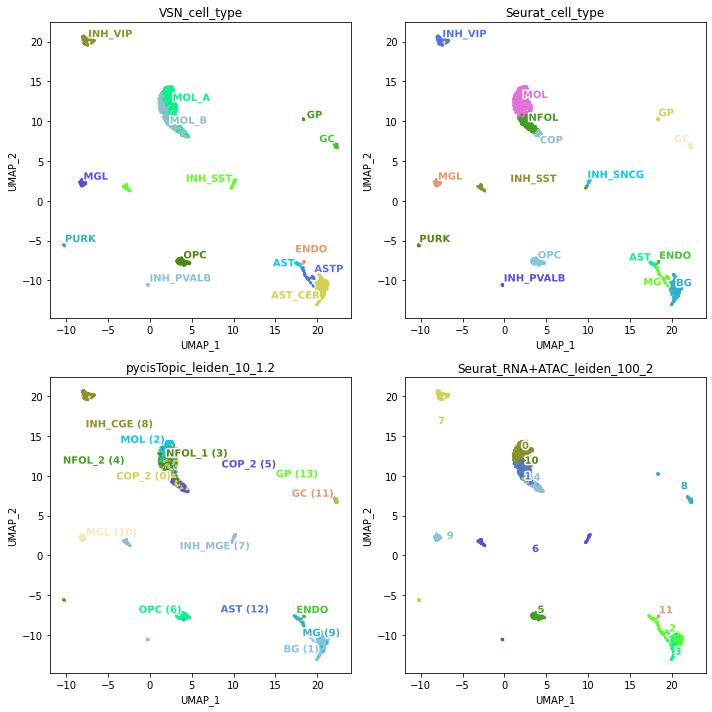

In [160]:
plot_metadata(cistopic_obj,
                 reduction_name='Seurat_RNA+ATAC_UMAP',
                 variables=['VSN_cell_type', 'Seurat_cell_type', 'pycisTopic_leiden_10_1.2','Seurat_RNA+ATAC_leiden_100_2'], # Labels from RNA and new clusters
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=3,
                 figsize=(10,10))

In [161]:
annot_dict={}
annot_dict['Seurat_RNA+ATAC_leiden_100_2'] = {'0':'MOL (0)', '1':'NFOL (1)', '2': 'MG (2)', '3': 'BG (3)', '4': 'COP (4)', '5': 'OPC (5)', '6': 'INH_MGE  (6)', '7': 'INH_CGE (7)', '8': 'GC (8)',
                                                 '9': 'MGL (9)', '10': 'MOL (10)', '11': 'ENDO (11)'}
cistopic_obj.cell_data['Seurat_RNA+ATAC_leiden_100_2'] = [annot_dict['Seurat_RNA+ATAC_leiden_100_2'][x] if x == x else np.nan for x in cistopic_obj.cell_data['Seurat_RNA+ATAC_leiden_100_2'].tolist() ]

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:472: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


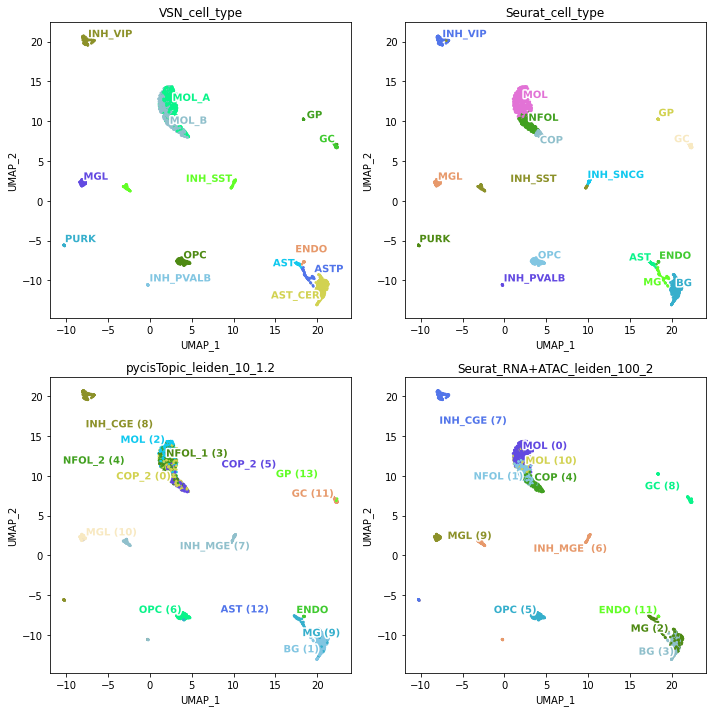

In [162]:
plot_metadata(cistopic_obj,
                 reduction_name='Seurat_RNA+ATAC_UMAP',
                 variables=['VSN_cell_type', 'Seurat_cell_type', 'pycisTopic_leiden_10_1.2','Seurat_RNA+ATAC_leiden_100_2'], # Labels from RNA and new clusters
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=3,
                 figsize=(10,10))

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:649: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


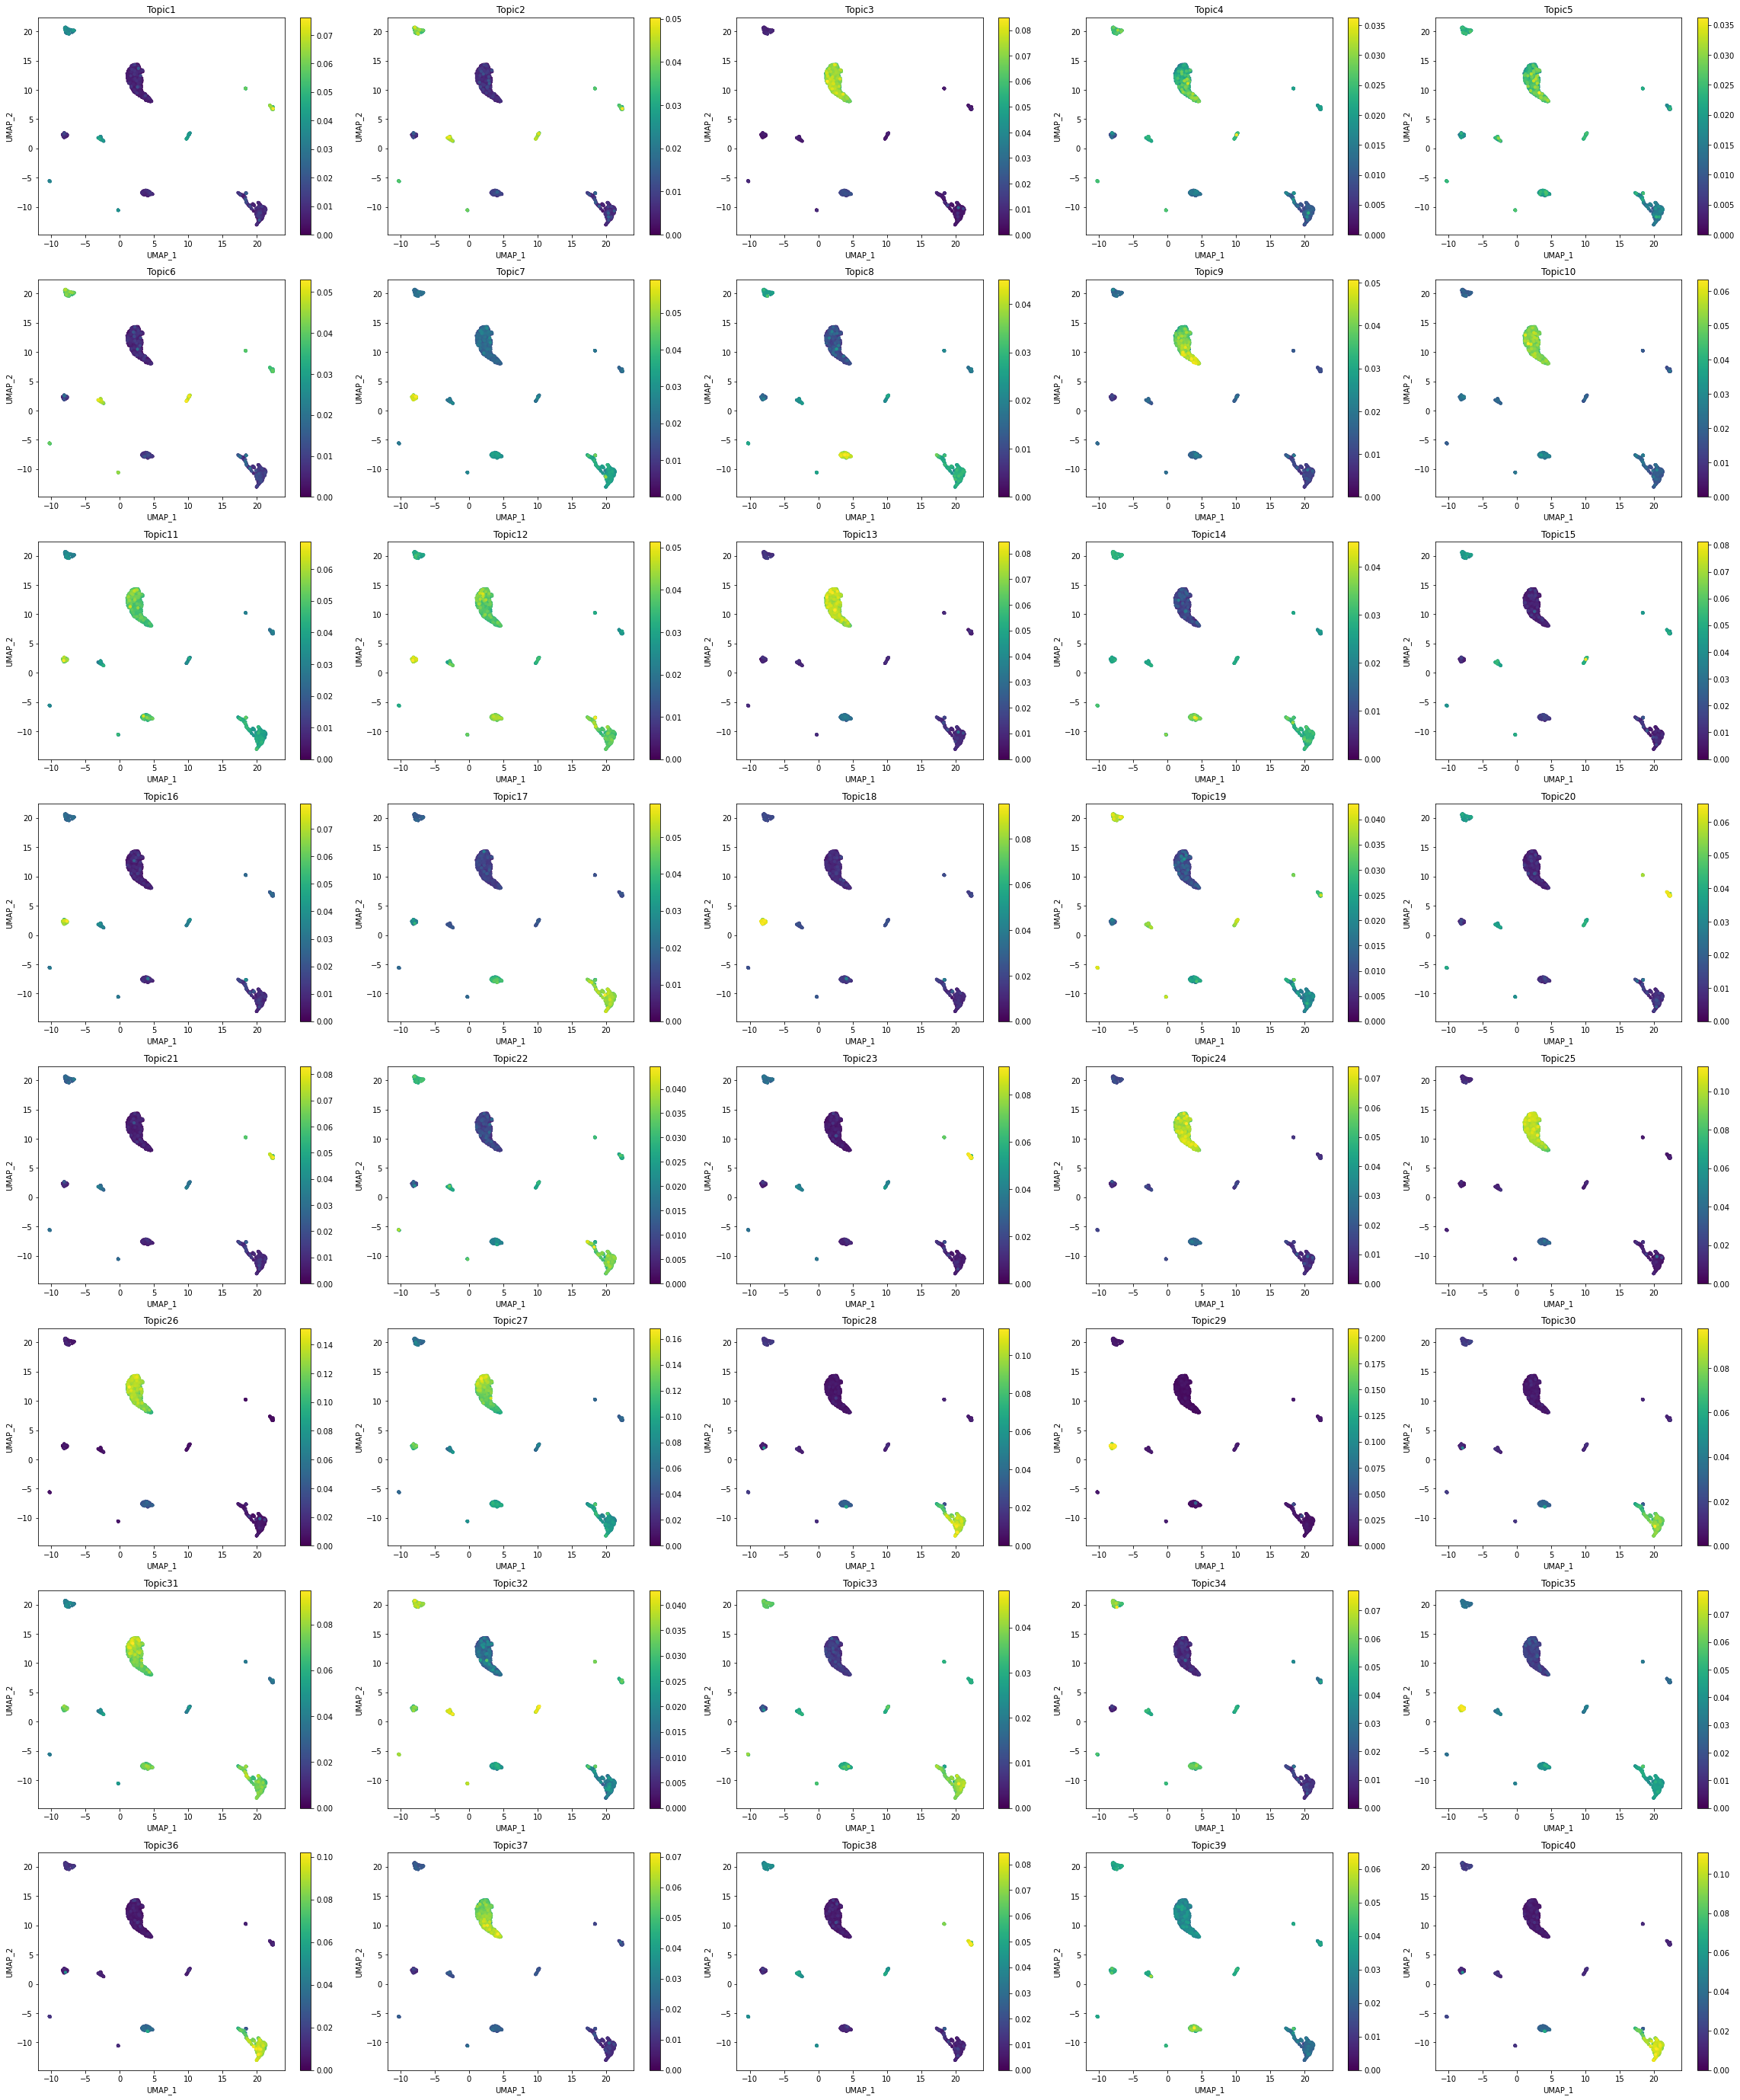

In [141]:
plot_topic(cistopic_obj, reduction_name='Seurat_RNA+ATAC_UMAP', num_columns=5)

In [163]:
# Save
with open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

[[Back to top]](#top)

<a class="anchor" id="pyigv"></a>
#### 9c. Visualizing profiles with igv_jupyterlab

It is also possible to visualize scATAC-seq profiles from jupyter_lab using igv_jupyter lab. In this example, we will use the pseudobulk bigwigs generated in the begining using the `cell_type` variable; but you can generate any pseudobulk based on `cell_data` using the `export_pseudobulk` function. We will recreate the bigwig files using the `Seurat_cell_type` variable since it matches better with the pycisTopic clusters and topics.

In [167]:
# Get metadata from loom file
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
path_to_annotated_rna_loom = projDir + "output/rna/seurat/10x_multiome_brain_Seurat.loom"
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
cell_data = get_metadata(loom)
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)
from pycisTopic.pseudobulk_peak_calling import *
ray.shutdown()
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'Seurat_cell_type',
                 sample_id_col = 'VSN_sample_id',
                 chromsizes = chromsizes,
                 bed_path = outDir + 'consensus_peak_calling/seurat_pseudobulk_bed_files/',
                 bigwig_path =  outDir + 'consensus_peak_calling/seurat_pseudobulk_bw_files/',
                 path_to_fragments = fragments_dict,
                 n_cpu = 5,
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = tmpDir + 'ray_spill',
                 split_pattern = '-')

2021-08-12 15:51:39,590 cisTopic     INFO     Reading fragments from /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/data/cell-arc/1.0.0/outs/human_brain_3k_atac_fragments.tsv.gz


2021-08-12 15:54:28,007	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=16991) 2021-08-12 15:54:31,548 cisTopic     INFO     Creating pseudobulk for AST
(pid=16989) 2021-08-12 15:54:32,316 cisTopic     INFO     Creating pseudobulk for BG
(pid=16988) 2021-08-12 15:54:33,087 cisTopic     INFO     Creating pseudobulk for COP
(pid=16993) 2021-08-12 15:54:33,917 cisTopic     INFO     Creating pseudobulk for ENDO
(pid=16992) 2021-08-12 15:54:34,589 cisTopic     INFO     Creating pseudobulk for GC
(pid=16993) 2021-08-12 15:54:42,683 cisTopic     INFO     ENDO done!
(pid=16993) 2021-08-12 15:54:42,823 cisTopic     INFO     Creating pseudobulk for GP
(pid=16991) 2021-08-12 15:54:46,968 cisTopic     INFO     AST done!
(pid=16991) 2021-08-12 15:54:47,105 cisTopic     INFO     Creating pseudobulk for INH_PVALB
(pid=16988) 2021-08-12 15:54:56,625 cisTopic     INFO     COP done!
(pid=16988) 2021-08-12 15:54:56,768 cisTopic     INFO     Creating pseudobulk for INH_SNCG
(pid=16991) 2021-08-12 15:55:02,259 cisTopic     INFO     INH_PVALB done!
(pid=16991) 2021-08-12 1

In [171]:
import pickle 
with open(outDir + 'consensus_peak_calling/seurat_pseudobulk_bed_files/bed_paths.pkl', 'wb') as f:
  pickle.dump(bed_paths, f)

In [175]:
import pickle 
with open(outDir + 'consensus_peak_calling/seurat_pseudobulk_bw_files/bw_paths.pkl', 'wb') as f:
  pickle.dump(bw_paths, f)

First you will need to initialize the browser:

In [173]:
# Temporarilly you will need to use this version of the package until we update jupyterlab to the newest version
import os
os.chdir("/data/leuven/software/biomed/jupyterhub/miniconda/envs/jupyterhub/lib/python3.9/site-packages/")
from igv_jupyterlab.igv_widget import *
# When updated, use this instead
# from igv_jupyterlab import IGV
igv = IGV(genome="hg38")
display(igv)
# It will take some seconds to load, be patient ;)

IGV(id='igv_2477496', initialConfig={'id': 'igv_2477496', 'locus': '', 'genome': 'hg38'})

Now you can load your profiles:

In [176]:
# Load bw paths
import pickle
infile = open(outDir + 'consensus_peak_calling/seurat_pseudobulk_bw_files/bw_paths.pkl', 'rb')
bw_paths = pickle.load(infile)
infile.close()

In [177]:
# You will see the files appearing in the browser
import random
prefix='https://lcbhub.aertslab.org/user/u0117456/23/files/' # Adapt to your session
for key in bw_paths.keys():
    track = IGV.create_track(
            name=key,
            url=prefix+bw_paths[key],
            color="#" + "%06x" % random.randint(0, 0xFFFFFF),
            autoHeight = True,
            min= 0,
            max=10
        )

    igv.load_track(track)
# Add consensus regions
track = IGV.create_track(
            name='Consensus regions',
            url=prefix+outDir + 'consensus_peak_calling/consensus_regions.bed',
            displayMode='Squished'
        )

igv.load_track(track)

In [34]:
# To jump to a specific gene. You will see the browser changing. You can also do this directly in the browser.
igv.locus = 'SOX10'

You can save the view by clicking save SVG in the browser.

<a class="anchor" id="topic_qc"></a>
### 10. Topic binarization & qc

Next we can binarize topic-region and cell-topic distributions. The first is useful for exploring the topics with other tools that work with region sets (e.g. GREAT, cisTarget); while the latter is useful to automatically automate topics.

In [178]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

We will first binarize the topic-region distributions. There are several methods that can be used for this: 'otsu' (Otsu, 1979), 'yen' (Yen et al., 1995), 'li'
(Li & Lee, 1993), 'aucell' (Van de Sande et al., 2020) or 'ntop' (Taking the top n regions per topic). Otsu and Yen's methods work well in topic-region distributions; however for some downstream analyses it may be convenient to use 'ntop' to have balanced region sets.

/opt/venv/lib/python3.8/site-packages/pycisTopic/topic_binarization.py:127: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, j)


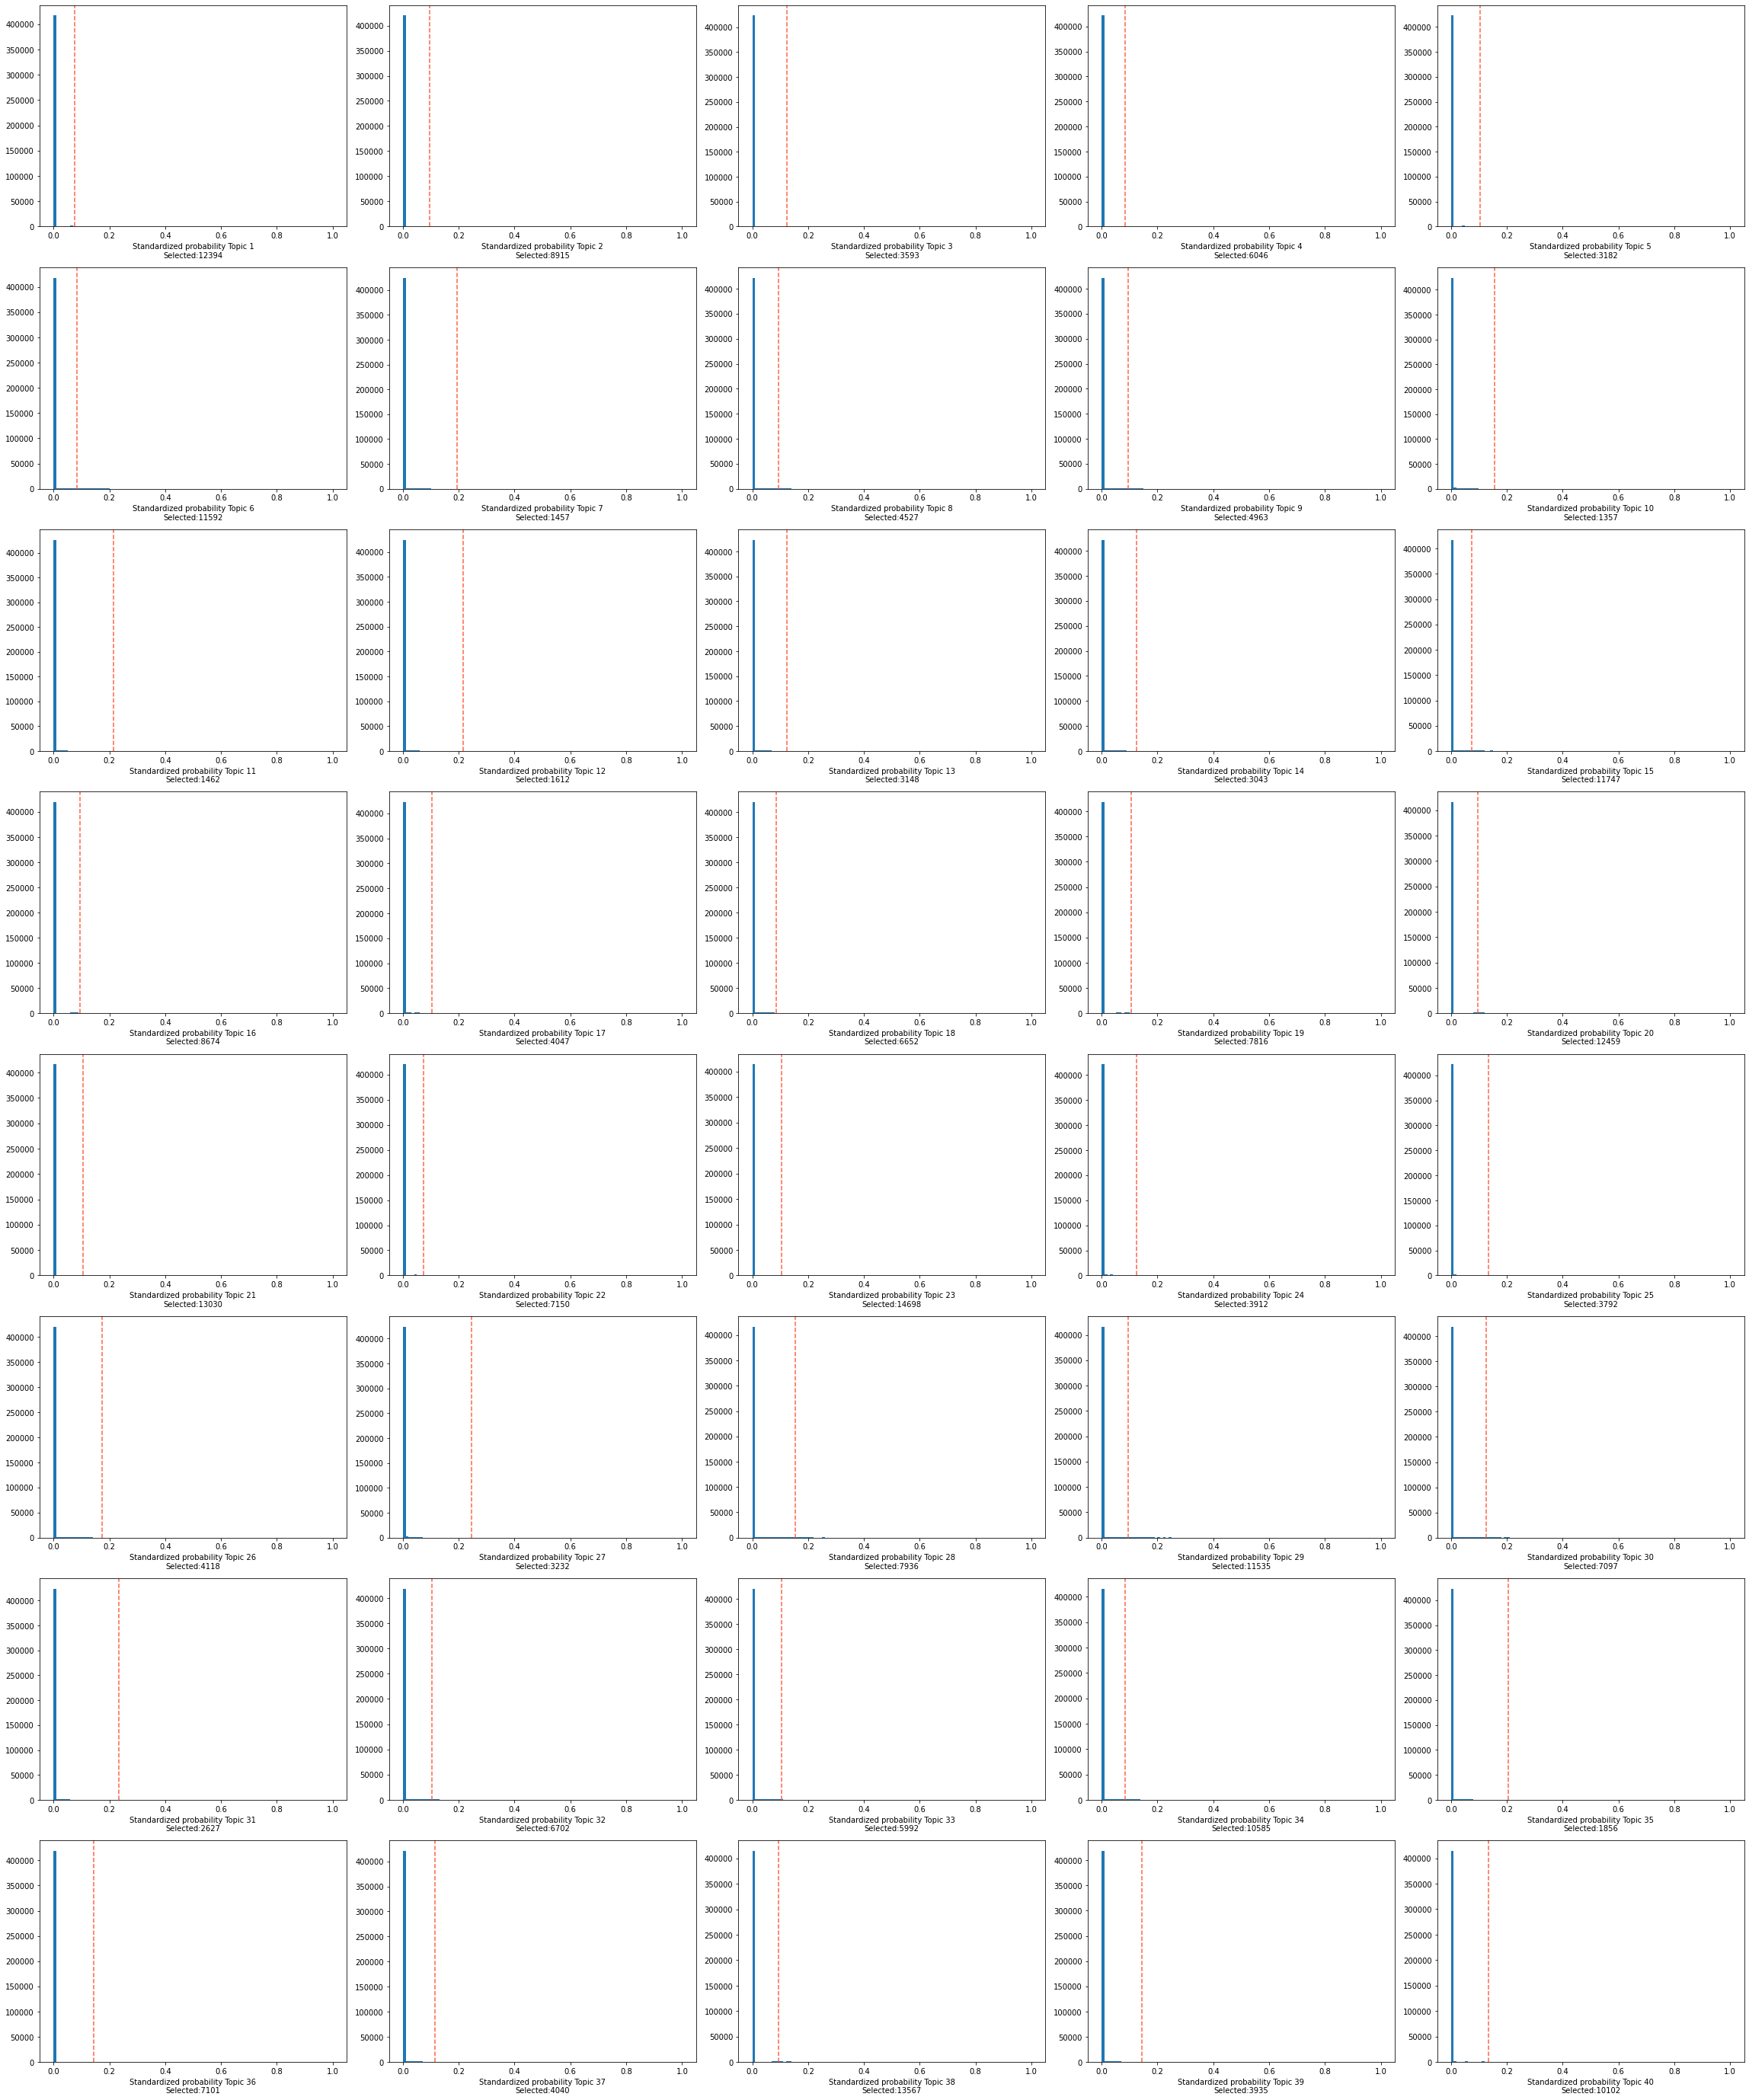

In [179]:
from pycisTopic.topic_binarization import *
region_bin_topics = binarize_topics(cistopic_obj, method='otsu', ntop=3000, plot=True, num_columns=5, save= outDir + 'topic_binarization/otsu.pdf')

Similarly, we can now binarize the cell-topic distribions. 

/opt/venv/lib/python3.8/site-packages/pycisTopic/topic_binarization.py:127: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, j)


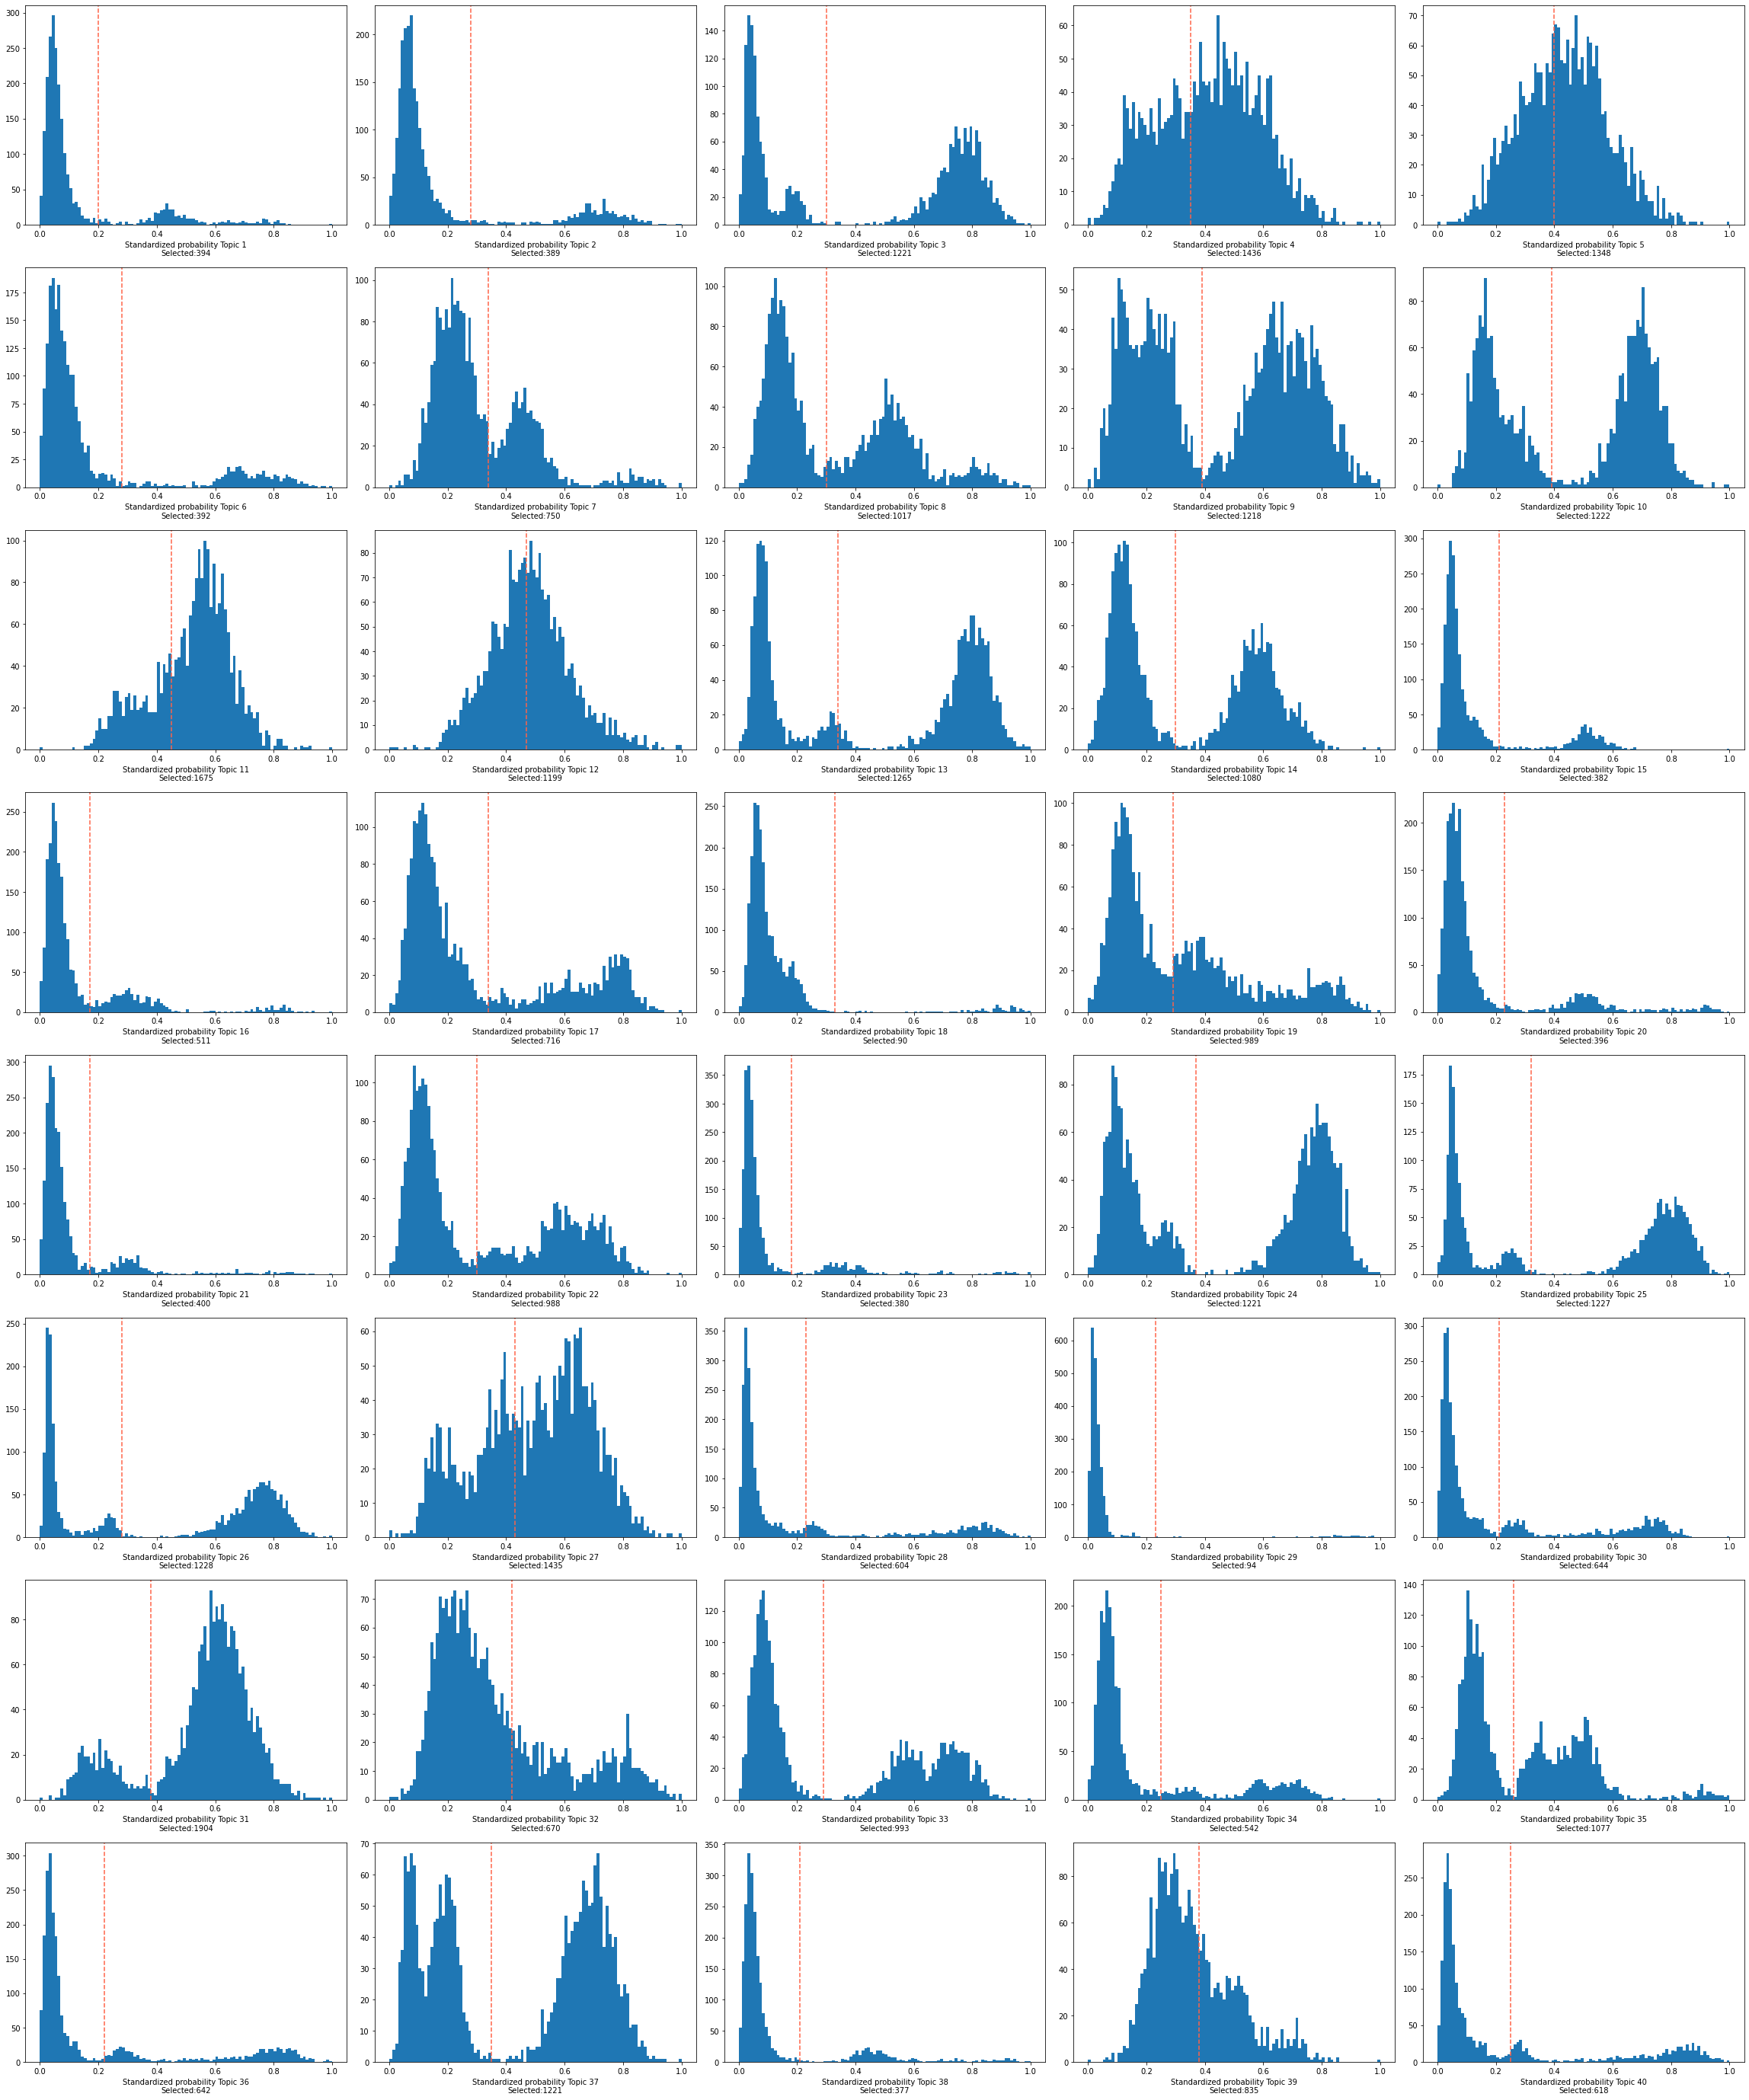

In [180]:
binarized_cell_topic = binarize_topics(cistopic_obj, target='cell', method='li', plot=True, num_columns=5, nbins=100)

We see that some thresholds are not very accurate. We can adjust the manually. 

/opt/venv/lib/python3.8/site-packages/pycisTopic/topic_binarization.py:127: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, j)


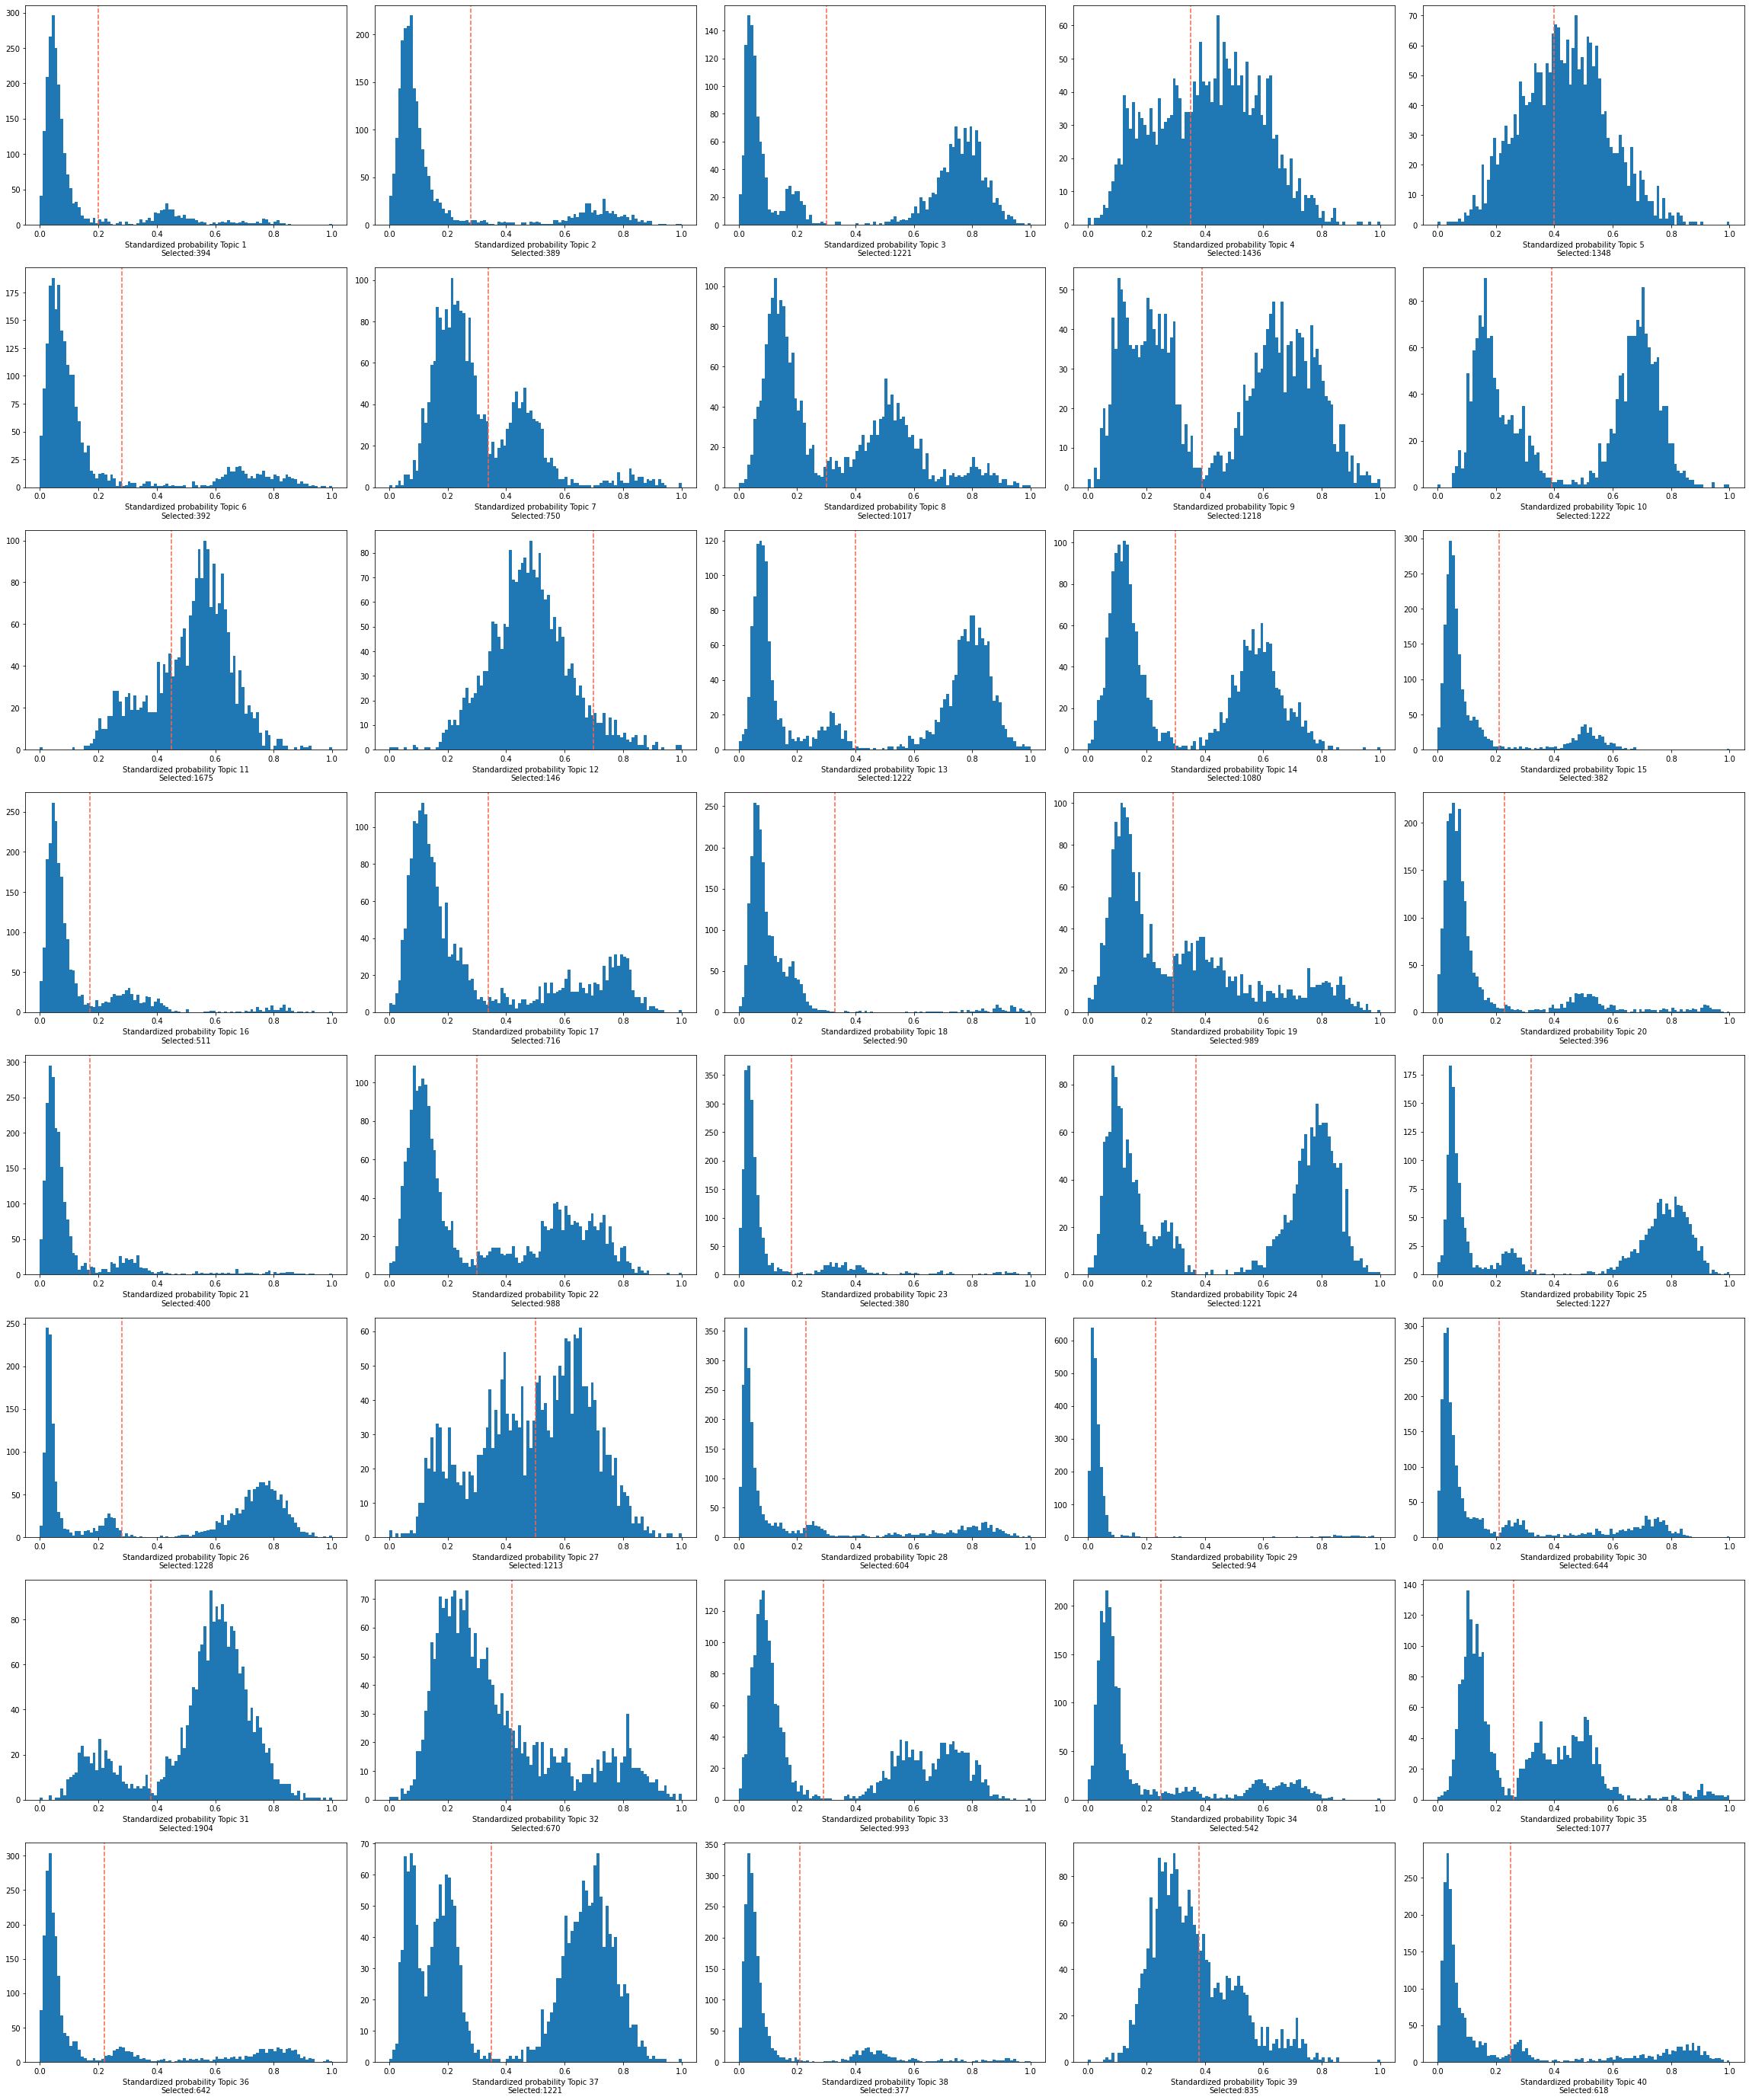

In [181]:
predifined_thr={'Topic12':0.7, 'Topic13':0.4, 'Topic27':0.5}
binarized_cell_topic = binarize_topics(cistopic_obj, target='cell', method='li', plot=True, num_columns=5, nbins=100, predifined_thr=predifined_thr)

Following, we can compute the topic quality control metrics. These include:

* **Number of assignments**
* **Topic coherence (Mimno et al., 2011)**: Measures to which extent high scoring regions in the topic are actually co-accessible in the original data. If it is low it indicates that the topic is rather random. The higher, the better is a topic. 
* **The marginal topic distribution**: Indicates how much each topic contributes to the model. The higher, the better is a topic.
* **The gini index**: Value between 0 and 1, that indicates the specificity of topics (0: General, 1:Specific)
* If topics have been binarized, the number of regions/cells per topic will be added.

In [182]:
from pycisTopic.topic_qc import *
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

We will create a figure dictionary to put all plots together. In this case, we will not put any threshold to filter topics.

In [183]:
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

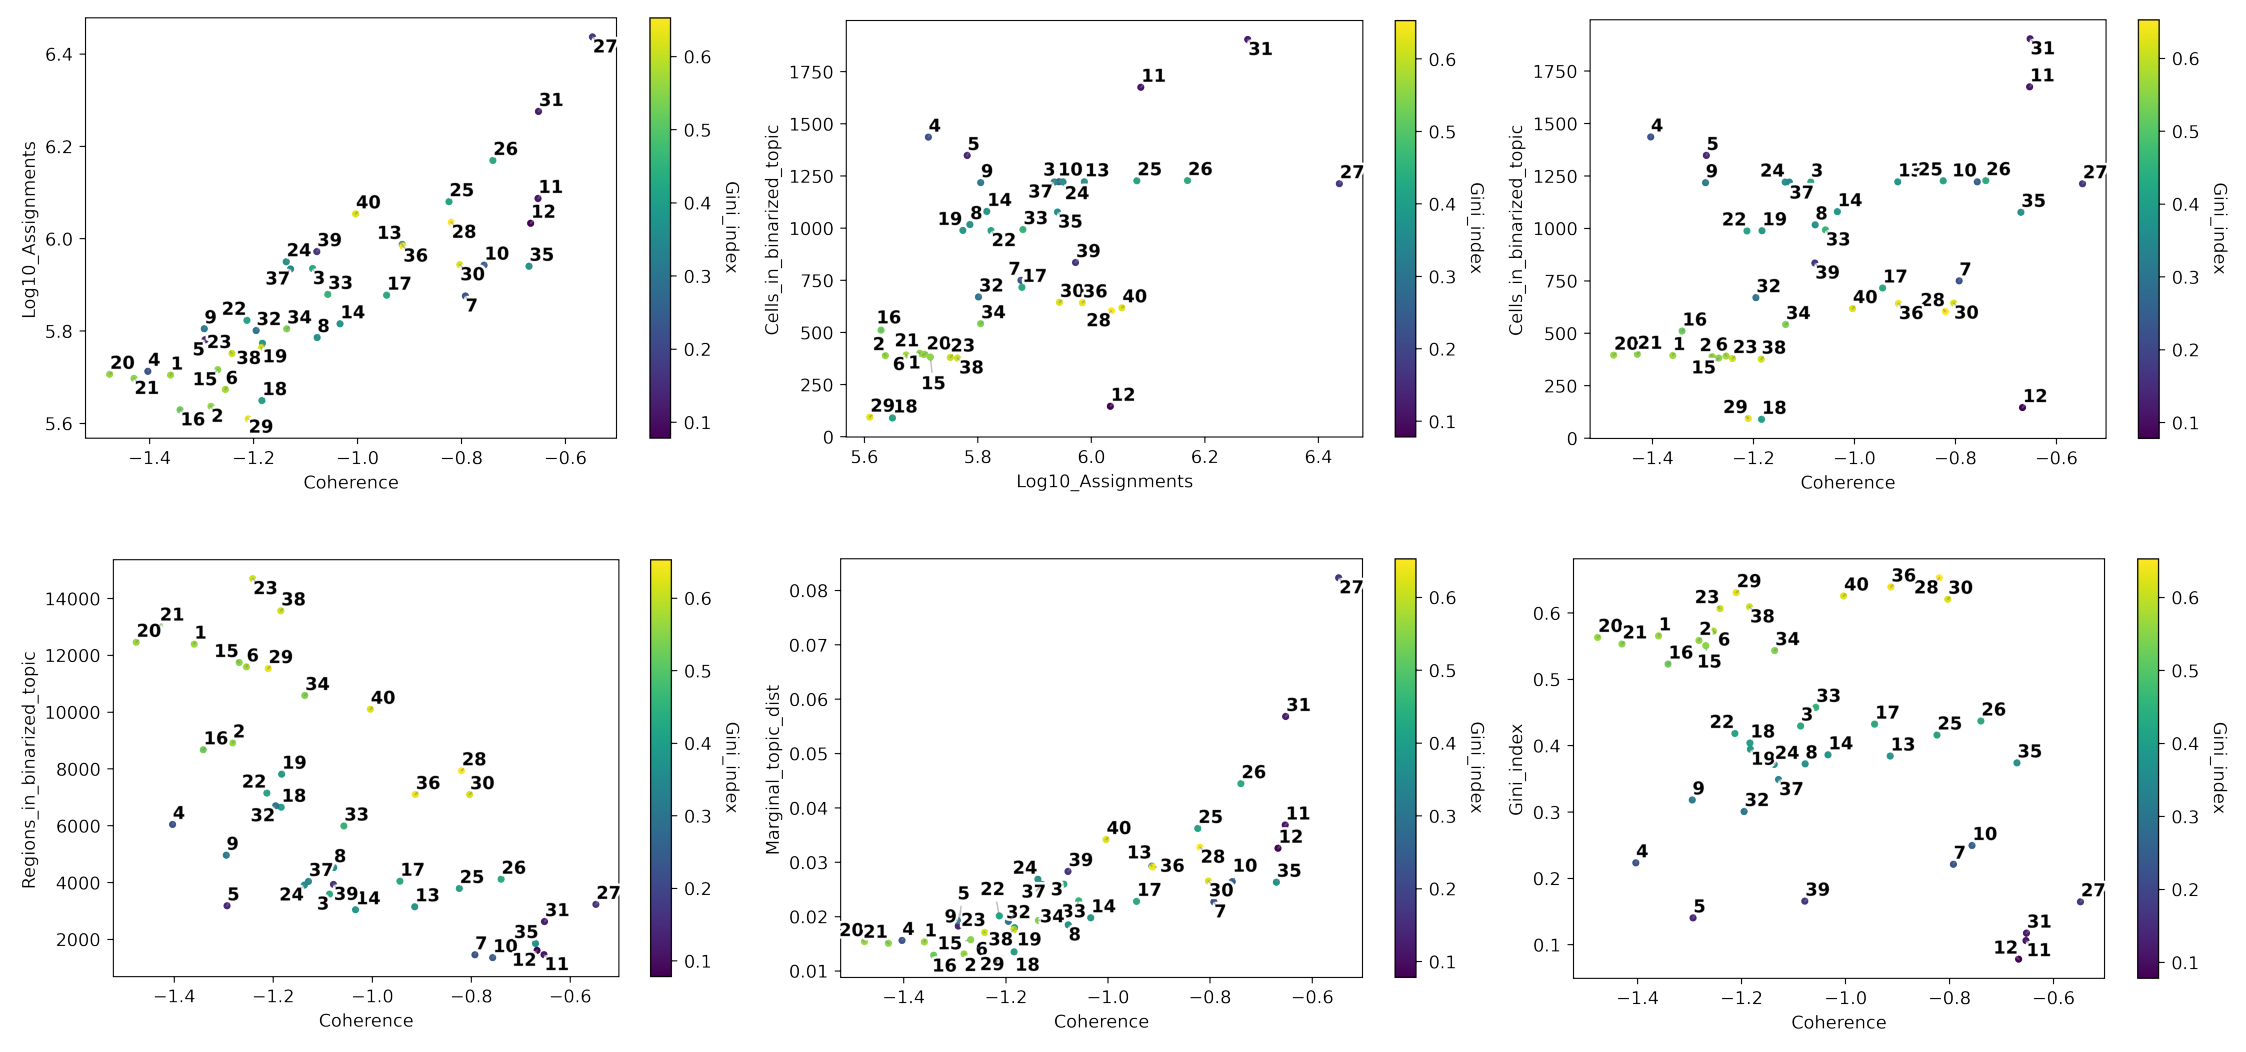

In [184]:
# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
fig.savefig(outDir + 'topic_binarization/Topic_qc.pdf', bbox_inches='tight')
plt.show()

Topic 28 (Astrocytes) is an example of a good topic: it has a high coherence and a high number of assignmnents/marginal topic score (these measurements are correlated), while being cell type specific (with a high gini index). Topic 5 is an example of a bad topic: it has low coherence and a low number of assignments while being general (found in many cells and with and low gini index). In some ocassions, for example topic 29 we observe a low number of assignments and a low coherence, but this can also occur if topics are very specific. Generally, we will consider a topic as bad if it has a low number of assignments while being assigned to many cells and a low coherence. 

Next, we can automatically annotate topics, in this case by cell type. Here we calculate the proportion of cells in each group that are assigned to the binarized topic in comparison to the ratio in the whole data set. We will consider a topic as general if the difference between the ration of cells in the whole data set in the binarized topic and the ratio of total cells in the assigned groups is above 0.2. This indicates that the topic is general, and the propotion test may fail if the topic is enriched in both foreground (the group) and background (the whole data set); resulting in a big difference between the ratios.

In [186]:
topic_annot = topic_annotation(cistopic_obj, annot_var='Seurat_cell_type', binarized_cell_topic=binarized_cell_topic, general_topic_thr = 0.2)

/opt/venv/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: divide by zero encountered in double_scalars
  zstat = value / std


In [187]:
topic_annot

Seurat_cell_type  \
Topic1   INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic2   INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic3                                      NFOL, COP, MOL   
Topic4   INH_VIP, INH_SST, NFOL, GP, INH_PVALB, PURK, C...   
Topic5   INH_VIP, INH_SST, NFOL, GP, INH_PVALB, PURK, C...   
Topic6   INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic7                         MG, BG, OPC, MGL, ENDO, AST   
Topic8   MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic9                                      NFOL, COP, MOL   
Topic10                                     NFOL, COP, MOL   
Topic11                     NFOL, OPC, COP, MGL, ENDO, MOL   
Topic12                                     OPC, MGL, ENDO   
Topic13                                     NFOL, COP, MOL   
Topic14  MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic15  INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic16  INH_VIP, INH_SST, GP, INH_PVALB, PURK, MGL, EN...   
Topic17                        MG, BG, OPC, MGL, ENDO, AST   
Topic18                                                MGL   
Topic19  MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic20  INH_VIP, INH_SST, GP, INH_PVALB, PURK, ENDO, I...   
Topic21  INH_VIP, INH_SST, GP, INH_PVALB, PURK, ENDO, I...   
Topic22  MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic23  INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic24                                     NFOL, COP, MOL   
Topic25                                     NFOL, COP, MOL   
Topic26                                     NFOL, COP, MOL   
Topic27                                     NFOL, MGL, MOL   
Topic28                                   MG, BG, OPC, AST   
Topic29                                                MGL   
Topic30                             MG, BG, OPC, ENDO, AST   
Topic31              MG, NFOL, BG, OPC, COP, MGL, MOL, AST   
Topic32  INH_VIP, INH_SST, GP, INH_PVALB, PURK, OPC, MG...   
Topic33  MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic34  INH_VIP, INH_SST, GP, INH_PVALB, PURK, OPC, IN...   
Topic35  MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic36                             MG, BG, OPC, ENDO, AST   
Topic37                                     NFOL, COP, MOL   
Topic38  INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic39  INH_VIP, INH_SST, GP, INH_PVALB, PURK, OPC, CO...   
Topic40                             MG, BG, OPC, ENDO, AST   

        Ratio_cells_in_topic Ratio_group_in_population  is_general  
Topic1              0.171902                  0.135253       False  
Topic2              0.169721                  0.135253       False  
Topic3              0.532723                  0.359075       False  
Topic4              0.626527                  0.494328       False  
Topic5              0.588133                  0.470768       False  
Topic6               0.17103                  0.135253       False  
Topic7              0.327225                  0.263089       False  
Topic8              0.443717                   0.36911       False  
Topic9              0.531414                  0.359075       False  
Topic10             0.533159                  0.359075       False  
Topic11             0.730803                  0.462914        True  
Topic12               0.0637                  0.103839       False  
Topic13             0.533159                  0.359075       False  
Topic14             0.471204                  0.398342       False  
Topic15             0.166667                  0.135253       False  
Topic16             0.222949                  0.170593       False  
Topic17             0.312391                  0.263089       False  
Topic18             0.039267                  0.029232       False  
Topic19             0.431501                   0.36911       False  
Topic20             0.172775                  0.141361       False  
Topic21              0.17452                  0.14

We can merge the topic metrics and their annotation in a data frame.

In [189]:
topic_qc_metrics = pd.concat([topic_annot[['Seurat_cell_type', 'Ratio_cells_in_topic', 'Ratio_group_in_population']], topic_qc_metrics], axis=1)

In [190]:
topic_qc_metrics

Seurat_cell_type  \
Topic1   INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic2   INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic3                                      NFOL, COP, MOL   
Topic4   INH_VIP, INH_SST, NFOL, GP, INH_PVALB, PURK, C...   
Topic5   INH_VIP, INH_SST, NFOL, GP, INH_PVALB, PURK, C...   
Topic6   INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic7                         MG, BG, OPC, MGL, ENDO, AST   
Topic8   MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic9                                      NFOL, COP, MOL   
Topic10                                     NFOL, COP, MOL   
Topic11                     NFOL, OPC, COP, MGL, ENDO, MOL   
Topic12                                     OPC, MGL, ENDO   
Topic13                                     NFOL, COP, MOL   
Topic14  MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic15  INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic16  INH_VIP, INH_SST, GP, INH_PVALB, PURK, MGL, EN...   
Topic17                        MG, BG, OPC, MGL, ENDO, AST   
Topic18                                                MGL   
Topic19  MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic20  INH_VIP, INH_SST, GP, INH_PVALB, PURK, ENDO, I...   
Topic21  INH_VIP, INH_SST, GP, INH_PVALB, PURK, ENDO, I...   
Topic22  MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic23  INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic24                                     NFOL, COP, MOL   
Topic25                                     NFOL, COP, MOL   
Topic26                                     NFOL, COP, MOL   
Topic27                                     NFOL, MGL, MOL   
Topic28                                   MG, BG, OPC, AST   
Topic29                                                MGL   
Topic30                             MG, BG, OPC, ENDO, AST   
Topic31              MG, NFOL, BG, OPC, COP, MGL, MOL, AST   
Topic32  INH_VIP, INH_SST, GP, INH_PVALB, PURK, OPC, MG...   
Topic33  MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic34  INH_VIP, INH_SST, GP, INH_PVALB, PURK, OPC, IN...   
Topic35  MG, INH_VIP, INH_SST, GP, INH_PVALB, PURK, BG,...   
Topic36                             MG, BG, OPC, ENDO, AST   
Topic37                                     NFOL, COP, MOL   
Topic38  INH_VIP, INH_SST, GP, INH_PVALB, PURK, INH_SNC...   
Topic39  INH_VIP, INH_SST, GP, INH_PVALB, PURK, OPC, CO...   
Topic40                             MG, BG, OPC, ENDO, AST   

        Ratio_cells_in_topic Ratio_group_in_population  Log10_Assignments  \
Topic1              0.171902                  0.135253           5.704676   
Topic2              0.169721                  0.135253           5.636994   
Topic3              0.532723                  0.359075           5.935460   
Topic4              0.626527                  0.494328           5.712850   
Topic5              0.588133                  0.470768           5.781202   
Topic6               0.17103                  0.135253           5.673577   
Topic7              0.327225                  0.263089           5.875961   
Topic8              0.443717                   0.36911           5.786005   
Topic9              0.531414                  0.359075           5.805062   
Topic10             0.533159                  0.359075           5.942749   
Topic11             0.730803                  0.462914           6.087209   
Topic12               0.0637                  0.103839           6.033457   
Topic13             0.533159                  0.359075           5.987684   
Topic14             0.471204                  0.398342           5.815732   
Topic15             0.166667                  0.135253           5.716365   
Topic16             0.222949                  0.170593           5.629432   
Topic17             0.312391                  0.263089           5.877697   
Topic18             0.039267                  0.029232           5.649517   
Topic19             0.431501        

In [191]:
# Save
with open(outDir + 'topic_binarization/Topic_qc_metrics_annot.pkl', 'wb') as f:
  pickle.dump(topic_qc_metrics, f)
with open(outDir + 'topic_binarization/binarized_cell_topic.pkl', 'wb') as f:
  pickle.dump(binarized_cell_topic, f)
with open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'wb') as f:
  pickle.dump(region_bin_topics, f)

[[Back to top]](#top)

<a class="anchor" id="dars"></a>
### 11. Differentially Accessible Regions (DARs)

In [192]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

Together with working with regulatory topics, we can also identify differentially accessible regions (DARs) between cell types. First, we will impute the region accessibility exploting the cell-topic and topic-region probabilities. To shrink very low probability values to 0, we use a scale factor (by default: 10^6).

In [193]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)

2021-08-12 16:22:40,575 cisTopic     INFO     Imputing drop-outs
2021-08-12 16:22:41,688 cisTopic     INFO     Removing small values
2021-08-12 16:22:45,963 cisTopic     INFO     Converting to sparse matrix
2021-08-12 16:23:14,485 cisTopic     INFO     Scaling
2021-08-12 16:23:15,609 cisTopic     INFO     Keep non zero rows
2021-08-12 16:23:19,425 cisTopic     INFO     Create CistopicImputedFeatures object
2021-08-12 16:23:19,426 cisTopic     INFO     Done!


Next we will log-normalize the imputed data.

In [194]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2021-08-12 16:33:11,391 cisTopic     INFO     Normalizing imputed data
2021-08-12 16:33:42,255 cisTopic     INFO     Done!


Optionally, we can identify highly variable regions. This is not mandatory, but will speed up the hypothesis testing step for identifying DARs.

2021-08-12 16:37:39,225 cisTopic     INFO     Calculating mean and variance


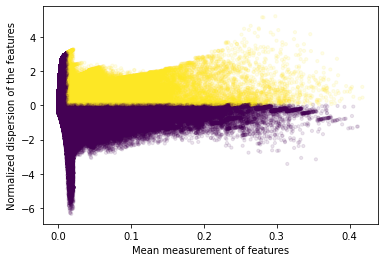

2021-08-12 16:39:06,295 cisTopic     INFO     Done!


In [195]:
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj,
                                           min_disp = 0.05,
                                           min_mean = 0.0125, 
                                           max_mean = 3,
                                           max_disp = np.inf,
                                           n_bins=20, 
                                           n_top_features=None,
                                           plot=True,
                                           save= outDir + 'DARs/HVR_plot.pdf')

There is a total of 75,341 variable features.

In [196]:
len(variable_regions)

75341

We can now identify differentially accessible regions between groups. By default, this function will perform a Wilcoxon rank-sum test between each group in the specified variable and the rest. Alternatively, specified contrast can be provided as a list with foreground and background groups (e.g. for group 1 versus group 2 and 3, and group 2 versus group 1 and 3: [[['Group_1'], ['Group_2, 'Group_3']], [['Group_2'], ['Group_1, 'Group_3']]]).

In [198]:
markers_dict= find_diff_features(cistopic_obj, 
                      imputed_acc_obj,
                      variable='Seurat_cell_type',
                      var_features=variable_regions,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=5,
                      _temp_dir=tmpDir + 'ray_spill',
                      split_pattern = '-') 

2021-08-12 16:39:25,735	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=7861) 2021-08-12 16:39:32,384 cisTopic     INFO     Computing p-value for BG
(pid=7856) 2021-08-12 16:39:32,385 cisTopic     INFO     Computing p-value for AST
(pid=7854) 2021-08-12 16:39:32,373 cisTopic     INFO     Computing p-value for ENDO
(pid=7855) 2021-08-12 16:39:32,376 cisTopic     INFO     Computing p-value for COP
(pid=7862) 2021-08-12 16:39:32,373 cisTopic     INFO     Computing p-value for GC
(pid=7855) 2021-08-12 16:40:56,566 cisTopic     INFO     Computing log2FC for COP
(pid=7856) 2021-08-12 16:40:56,905 cisTopic     INFO     Computing log2FC for AST
(pid=7862) 2021-08-12 16:40:57,775 cisTopic     INFO     Computing log2FC for GC
(pid=7861) 2021-08-12 16:40:58,290 cisTopic     INFO     Computing log2FC for BG
(pid=7854) 2021-08-12 16:40:58,336 cisTopic     INFO     Computing log2FC for ENDO
(pid=7855) 2021-08-12 16:41:47,545 cisTopic     INFO     COP done!
(pid=7855) 2021-08-12 16:41:47,744 cisTopic     INFO     Computing p-value for GP
(pid=7862) 2021-08-12 16:41:

We can also plot region accessibility into the cell-topic UMAP. For example, let's check how the best DARs for some cell types look like.

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:764: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


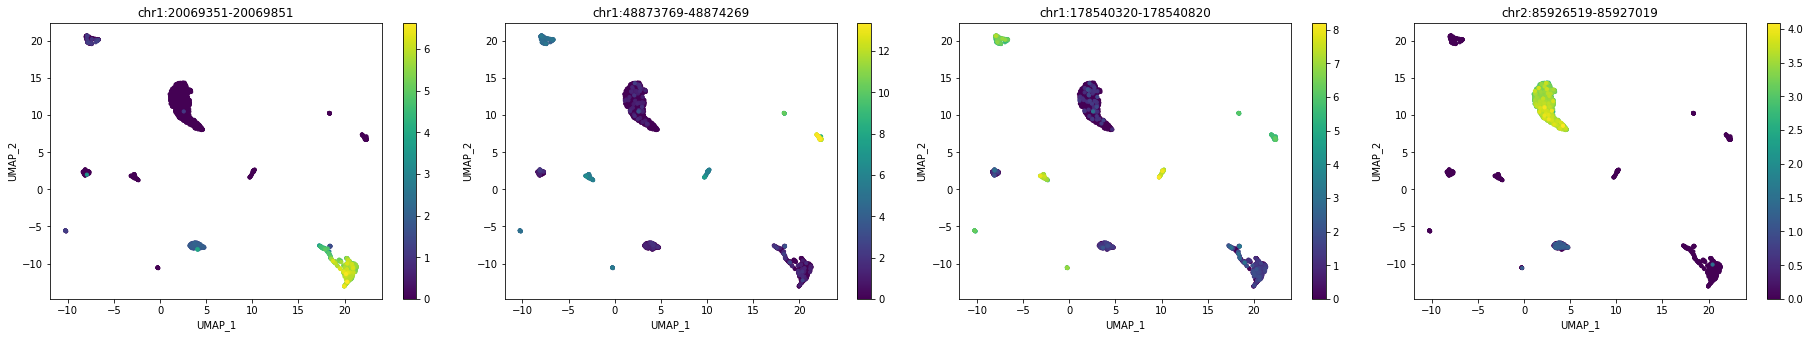

In [202]:
from pycisTopic.clust_vis import *
plot_imputed_features(cistopic_obj,
                    reduction_name='Seurat_RNA+ATAC_UMAP',
                    imputed_data=imputed_acc_obj,
                    features=[markers_dict[x].index.tolist()[0] for x in ['BG', 'GC', 'INH_SST', 'COP']],
                    scale=False,
                    num_columns=4,
                    selected_cells = cistopic_obj.projections['cell']['Seurat_RNA+ATAC_UMAP'].index.tolist(),
                    save= outDir + 'DARs/example_best_DARs.pdf')

How many DARs do we find per cell type?

In [203]:
x = [print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys()]

AST: 32163
BG: 32515
COP: 23169
ENDO: 15280
GC: 15962
GP: 16659
INH_PVALB: 17017
INH_SNCG: 18492
INH_SST: 17845
INH_VIP: 19186
MG: 31580
MGL: 10216
MOL: 29830
NFOL: 25974
OPC: 14704
PURK: 19586


In [204]:
# Save
with open(outDir + 'DARs/Imputed_accessibility.pkl', 'wb') as f:
  pickle.dump(imputed_acc_obj, f)
with open(outDir + 'DARs/DARs.pkl', 'wb') as f:
  pickle.dump(markers_dict, f)

[[Back to top]](#top)

<a class="anchor" id="gene_act"></a>
### 12. Gene activity

In [2]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Load imputed accessibility
import pickle
infile = open(outDir + 'DARs/Imputed_accessibility.pkl', 'rb')
imputed_acc_obj = pickle.load(infile)
infile.close()
# Load DARs
import pickle
infile = open(outDir + 'DARs/DARs.pkl', 'rb')
DARs_dict = pickle.load(infile)
infile.close()

After imputing region accessibility, we can infer gene accessibility. Next we need to retrieve gene annotation and chromosome sizes for our genome.

In [1]:
# Get TSS annotations
import pybiomart as pbm
import pyranges as pr
# For mouse
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For human
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For fly
#dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position', 'strand', 'external_gene_name', 'transcription_start_site', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = 'chr' + annot['Chromosome/scaffold name'].astype(str)
annot.columns=['Chromosome', 'Start', 'End', 'Strand', 'Gene','Transcription_Start_Site', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
annot.Strand[annot.Strand == 1] = '+'
annot.Strand[annot.Strand == -1] = '-'
pr_annotation = pr.PyRanges(annot.dropna(axis = 0))

/tmp/ipykernel_15150/2487299827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annot.Strand[annot.Strand == -1] = '-'


In [4]:
# Get chromosome sizes
import pandas as pd
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
chromsizes=pr.PyRanges(chromsizes)

Now we can infer gene activity. In this function there are several options to evaluate:
* **Search space**: The user can choose whether the search space should be include other genes or not (`use_gene_boundaries`), and the minimum and maximum distance it should have (`upstream` and `downstream`)
* **Distance weight**: The parameters related to the distance weight measure the impact of distance when inferring region to gene weights as an exponential function. The user can control whether this weight should be used (`distance_weight`) and the effect of the distance (`decay_rate`). 
* **Gene size weight**: Large genes may have more peaks by chance. The user can optionally apply a weight based on the size of each gene (`gene_size_weight`), which by default is dividing the size of each gene by the median gene size in the genome. Alternatively, the user can also use `average_scores` which will calculate the gene activity as the mean weighted region accessibility of all regions linked to the gene.
* **Gini weight** : This weight will give more importance to specific regions (`gini_weight`). 

In this notebook we select the parameters as indicated below. To speed up calculations, it is also possible to only work with regions in topics or DARs.

In [5]:
from pycisTopic.gene_activity import *
gene_act, weigths = get_gene_activity(imputed_acc_obj, # Region-cell probabilities
                pr_annotation, # Gene annotation
                chromsizes, # Chromosome size
                use_gene_boundaries=True, # Whether to use the whole search space or stop when encountering another gene
                upstream=[1000, 100000], # Search space upstream. The minimum means that even if there is a gene right next to it 
                                      #these bp will be taken (1kbp here)
                downstream=[1000,100000], # Search space downstream
                distance_weight=True, # Whether to add a distance weight (an exponential function, the weight will decrease with distance)
                decay_rate=1, # Exponent for the distance exponential funciton (the higher the faster will be the decrease)
                extend_gene_body_upstream=10000, # Number of bp upstream immune to the distance weight (their value will be maximum for 
                                      #this weight)
                extend_gene_body_downstream=500, # Number of bp downstream immune to the distance weight
                gene_size_weight=False, # Whether to add a weights based on the length of the gene
                gene_size_scale_factor='median', # Dividend to calculate the gene size weigth. Default is the median value of all genes
                                      #in the genome
                remove_promoters=False, # Whether to remove promoters when computing gene activity scores
                average_scores=True, # Whether to divide by the total number of region assigned to a gene when calculating the gene 
                                      #activity score
                scale_factor=1, # Value to multiply for the final gene activity matrix
                extend_tss=[10,10], # Space to consider a promoter
                gini_weight = True, # Whether to add a gini index weigth. The more unique the region is, the higher this weight will be
                return_weights= True, # Whether to return the final weights
                project='Gene_activity') # Project name for the gene activity object

2021-08-12 17:08:14,191 cisTopic     INFO     Calculating gene boundaries
2021-08-12 17:08:24,913 cisTopic     INFO     Calculating distances
2021-08-12 17:09:34,410 cisTopic     INFO     Calculating distance weigths
2021-08-12 17:09:35,847 cisTopic     INFO     Distance weights done
2021-08-12 17:09:35,848 cisTopic     INFO     Calculating gini weights
2021-08-12 17:11:31,211 cisTopic     INFO     Getting gene activity scores
2021-08-12 17:22:00,451 cisTopic     INFO     Creating imputed features object


As we did before for the imputed region accessibility, we can also infer the Differentially Accessible Genes (DAGs).

In [7]:
markers_dict= find_diff_features(cistopic_obj, 
                      gene_act,
                      variable='Seurat_cell_type',
                      var_features=None,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=5,
                      _temp_dir=tmpDir + 'ray_spill',
                      split_pattern = '-') 

2021-08-12 17:43:32,240	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=913) 2021-08-12 17:43:35,341 cisTopic     INFO     Computing p-value for COP
(pid=930) 2021-08-12 17:43:35,389 cisTopic     INFO     Computing p-value for GC
(pid=935) 2021-08-12 17:43:35,424 cisTopic     INFO     Computing p-value for AST
(pid=929) 2021-08-12 17:43:35,462 cisTopic     INFO     Computing p-value for BG
(pid=928) 2021-08-12 17:43:35,434 cisTopic     INFO     Computing p-value for ENDO
(pid=913) 2021-08-12 17:43:46,391 cisTopic     INFO     Computing log2FC for COP
(pid=930) 2021-08-12 17:43:46,525 cisTopic     INFO     Computing log2FC for GC
(pid=929) 2021-08-12 17:43:46,554 cisTopic     INFO     Computing log2FC for BG
(pid=928) 2021-08-12 17:43:46,510 cisTopic     INFO     Computing log2FC for ENDO
(pid=935) 2021-08-12 17:43:46,702 cisTopic     INFO     Computing log2FC for AST
(pid=913) 2021-08-12 17:43:49,344 cisTopic     INFO     COP done!
(pid=913) 2021-08-12 17:43:49,361 cisTopic     INFO     Computing p-value for GP
(pid=930) 2021-08-12 17:43:49,503 cisTop

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:764: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)
/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:764: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)
/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:764: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)
/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:764: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be re

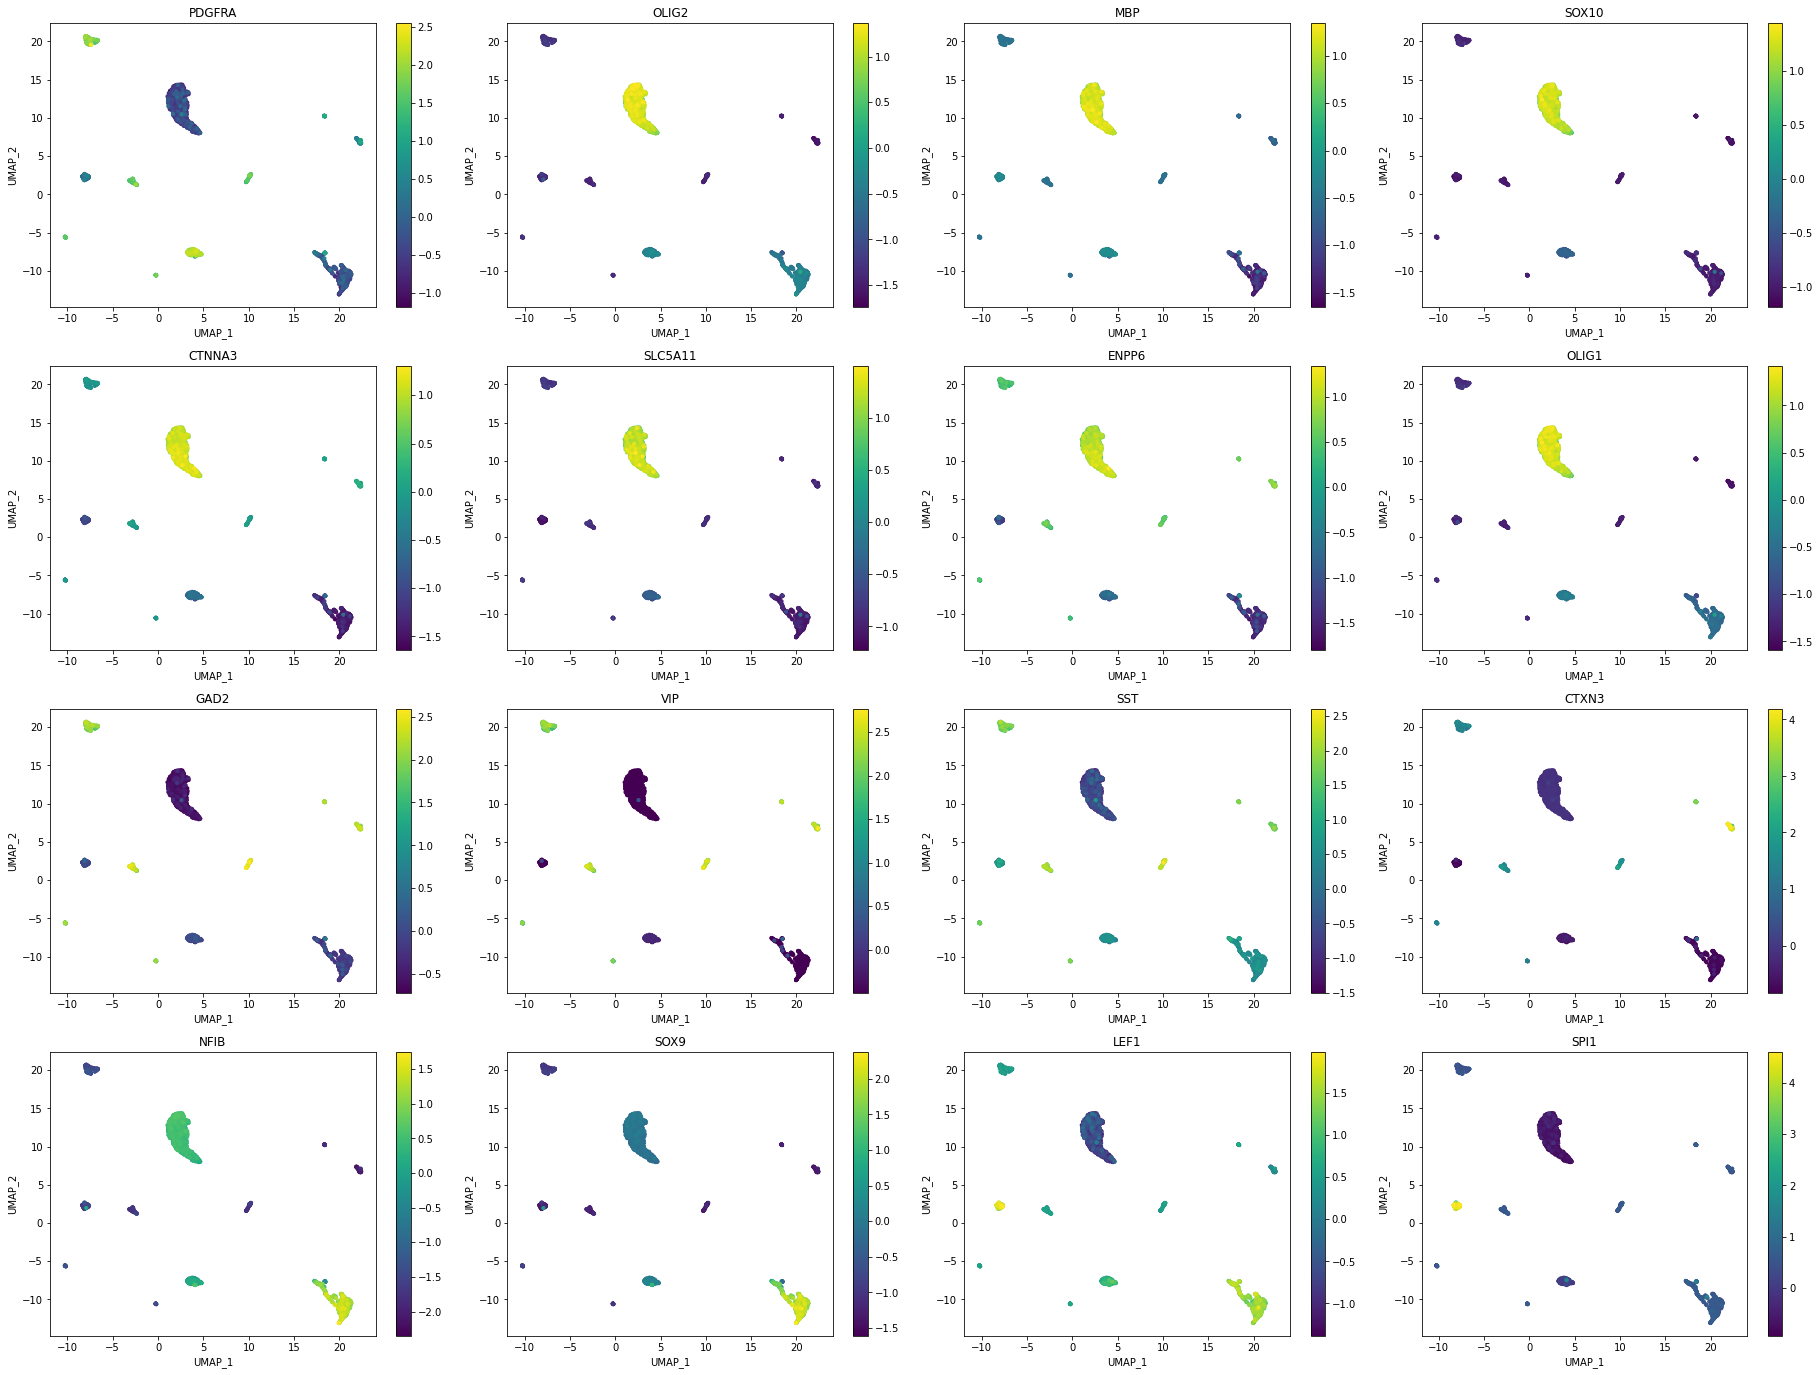

In [9]:
from pycisTopic.clust_vis import *
plot_imputed_features(cistopic_obj,
                    reduction_name='Seurat_RNA+ATAC_UMAP',
                    imputed_data=gene_act,
                    features=['PDGFRA', 'OLIG2', 'MBP', 'SOX10', # Olig differentiation
                              'CTNNA3', 'SLC5A11', 'ENPP6', 'OLIG1', # Olig differentiation
                              'GAD2', 'VIP', 'SST', 'CTXN3', # Int
                              'NFIB', 'SOX9',  #Ast
                              'LEF1', #Endo
                              'SPI1'], #Glia
                    scale=True,
                    num_columns=4,
                    save= outDir + 'DAGs/example_best_DAGs.pdf')

How many DAGs do we have per cell type?

In [10]:
x = [print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys()]

AST: 1838
BG: 2464
COP: 685
ENDO: 1131
GC: 3043
GP: 3038
INH_PVALB: 2672
INH_SNCG: 3034
INH_SST: 3003
INH_VIP: 2930
MG: 1945
MGL: 3340
MOL: 1909
NFOL: 991
OPC: 863
PURK: 2886


In [11]:
# Save
with open(outDir + 'DAGs/Gene_activity.pkl', 'wb') as f:
  pickle.dump(gene_act, f)
with open(outDir + 'DAGs/DAGs.pkl', 'wb') as f:
  pickle.dump(markers_dict, f)

[[Back to top]](#top)

<a class="anchor" id="label"></a>
### 13. Label transfer

In [28]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

Exploting the gene activity scores, we can transfer labels from a reference data set (e.g. scRNA-seq). As an example, we will transfer labels from the scRNA-seq layer of this data set.

In [33]:
# Prepare RNA
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
path_to_loom = projDir + 'output/rna/vsn/add_clusters_scrublet_as_annot/10x_multiome_brain_SCENIC_SCope_output_wAnnot_noDBL-2.loom'
loom = SCopeLoom.read_loom(path_to_loom)
metadata = get_metadata(loom)
expr_mat = loom.ex_mtx
rna_anndata = anndata.AnnData(X=expr_mat)
rna_anndata.obs = metadata
# Prepare ATAC
import pickle
infile = open(outDir + 'DAGs/Gene_activity.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
gene_act = pickle.load(infile)
infile.close()
atac_anndata = anndata.AnnData(X=gene_act.mtx.T, obs=pd.DataFrame(index=gene_act.cell_names), var=pd.DataFrame(index=gene_act.feature_names))
atac_anndata.obs = cistopic_obj.cell_data

The methods available for label transferring are: ingest' [from scanpy], 'harmony' [Korsunsky et al, 2019], 'bbknn' [Polański et al, 2020], 'scanorama' [Hie et al, 2019] and 'cca'. Except for ingest, these methods return a common coembedding and labels are inferred using the distances between query and refenrence cells as weights.

In [37]:
from pycisTopic.label_transfer import *
label_dict = label_transfer(rna_anndata,
                  atac_anndata,
                  labels_to_transfer = ['cell_type'],
                  variable_genes = True,
                  methods = ['ingest', 'harmony', 'bbknn', 'scanorama', 'cca'],
                  return_label_weights = False,
                  _temp_dir= tmpDir + 'ray_spill')

2021-08-12 18:23:50,507 cisTopic     INFO     Normalizing RNA data


/opt/venv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


2021-08-12 18:23:59,343 cisTopic     INFO     Processing 1 query sample(s) using 1 cpu(s)


2021-08-12 18:24:01,423	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=20310) 2021-08-12 18:24:04,408 cisTopic     INFO     Normalizing ATAC data from sample 10x_multiome_brain


(pid=20310) /opt/venv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
(pid=20310)   view_to_actual(adata)


(pid=20310) 2021-08-12 18:24:11,263 cisTopic     INFO     Running integration with ingest
(pid=20310) 2021-08-12 18:24:38,543 cisTopic     INFO     Running integration with harmony
(pid=20310) 2021-08-12 18:24:39,760 harmonypy    INFO     Iteration 1 of 10


(pid=20310) 2021-08-12 18:24:39,760 - harmonypy - INFO - Iteration 1 of 10


(pid=20310) 2021-08-12 18:24:40,494 harmonypy    INFO     Iteration 2 of 10


(pid=20310) 2021-08-12 18:24:40,494 - harmonypy - INFO - Iteration 2 of 10


(pid=20310) 2021-08-12 18:24:41,224 harmonypy    INFO     Iteration 3 of 10


(pid=20310) 2021-08-12 18:24:41,224 - harmonypy - INFO - Iteration 3 of 10


(pid=20310) 2021-08-12 18:24:41,700 harmonypy    INFO     Iteration 4 of 10


(pid=20310) 2021-08-12 18:24:41,700 - harmonypy - INFO - Iteration 4 of 10


(pid=20310) 2021-08-12 18:24:42,088 harmonypy    INFO     Converged after 4 iterations
(pid=20310) 2021-08-12 18:24:42,136 cisTopic     INFO     Running integration with bbknn


(pid=20310) 2021-08-12 18:24:42,088 - harmonypy - INFO - Converged after 4 iterations


(pid=20310) 2021-08-12 18:24:53,698 cisTopic     INFO     Running integration with scanorama
(pid=20310) Found 1517 genes among all datasets
(pid=20310) [[0.         0.26570681]
(pid=20310)  [0.         0.        ]]
(pid=20310) Processing datasets (0, 1)
(pid=20310) 2021-08-12 18:24:58,327 cisTopic     INFO     Running integration with cca


We can now add the annotations to our cisTopic object and visualize them in the cell-topic UMAP. Scanorama and harmony are the ones that work best.

In [38]:
label_dict_x=[label_dict[key] for key in label_dict.keys()]
label_pd = pd.concat(label_dict_x, axis=1, sort=False)
label_pd.index = cistopic_obj.cell_names
label_pd.columns = ['pycisTopic_' + x for x in label_pd.columns]
cistopic_obj.add_cell_data(label_pd, split_pattern = '-')

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:472: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


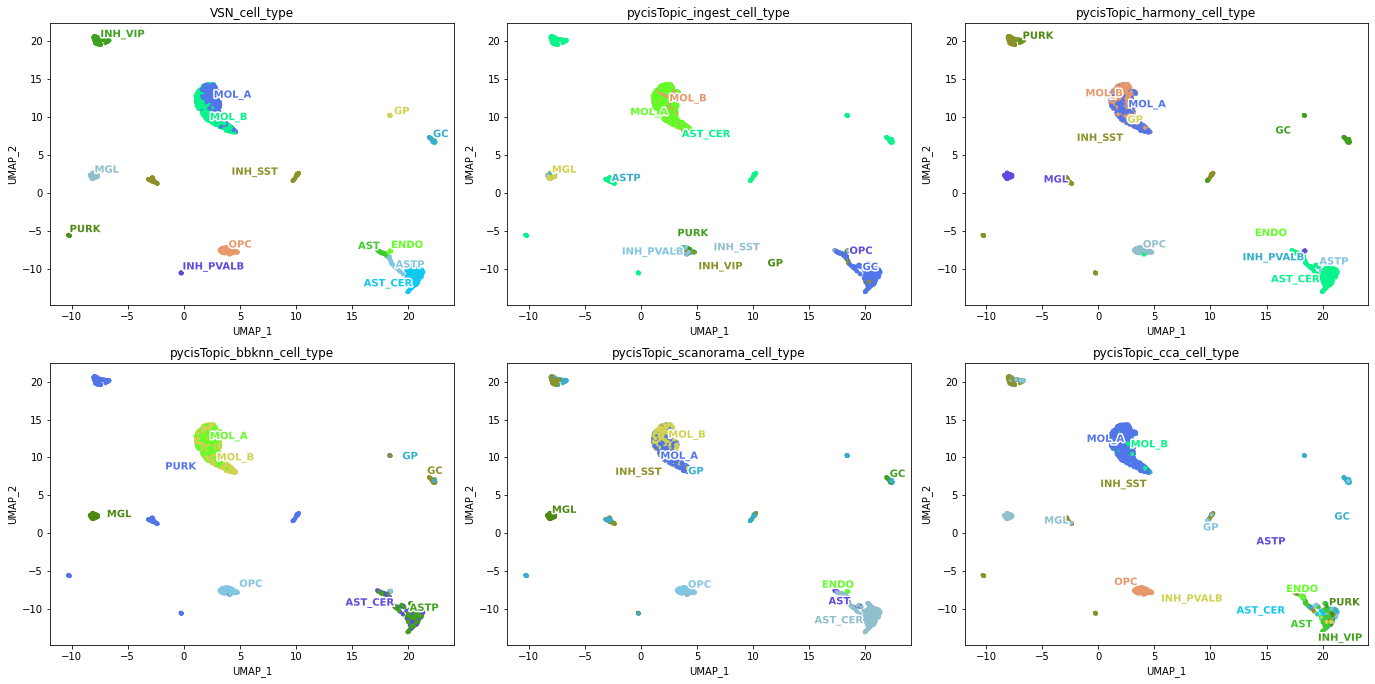

In [40]:
from pycisTopic.clust_vis import *
plot_metadata(cistopic_obj,
             reduction_name='Seurat_RNA+ATAC_UMAP',
             variables=['VSN_cell_type'] + label_pd.columns.to_list(),
             remove_nan=True,
             cmap=cm.viridis, 
             seed=555,
             num_columns=3,
             color_dictionary={},
             save= outDir + 'DAGs/label_transfer.pdf')

In [41]:
# Save
with open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

[[Back to top]](#top)

<a class="anchor" id="loom_export"></a>
### 14. Exporting to loom

We can now create loom files to further explore the results. There are two types of loom files:

* **Region accessibility**: These loom files include the imputed accessibility as matrix, topics as regulons and cell-topic distributions as AUC matrices. The imputed values, the cistopic object used for the imputation and the cell-topic and topic-region binarized distributions are required. Alternatively, we can also provide different clustering and the marker regions (DARs) per group per clustering.

* **Gene activity**: These loom files contain the gene activity as matrix, scRNA-seq derived regulons and their AUC values based on gene activity. The gene activity values, the cistopic object, and scRNA-seq derived regulons are required. Alternatively, we can also provide different clustering and the marker genes (DAGs) per group per clustering.

In this case we will create 5 loom files: region accessibility and gene activity loom files containing all and only cells overlapping with the scRNA-seq data and a loom file using the actual gene expression values from the multiome.

We will first load the data we need for the region accessibility loom files.

In [40]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Load imputed accessibility
import pickle
infile = open(outDir + 'DARs/Imputed_accessibility.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
imputed_acc_obj = pickle.load(infile)
infile.close()
# Load region binarized topics
import pickle
infile = open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
binarized_topic_region = pickle.load(infile)
infile.close()
# Load cell binarized topics
import pickle
infile = open(outDir + 'topic_binarization/binarized_cell_topic.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
binarized_cell_topic = pickle.load(infile)
infile.close()
# Load DARs
import pickle
infile = open(outDir + 'DARs/DARs.pkl', 'rb')
DARs_dict = pickle.load(infile)
infile.close()

##### A. Region accessibility

In [55]:
# Prepare DARs dict
cluster_markers = {'Seurat_cell_type': DARs_dict}
# Export to loom
from pycisTopic.loom import *
export_region_accessibility_to_loom(accessibility_matrix = imputed_acc_obj,
                  cistopic_obj = cistopic_obj, 
                  binarized_topic_region = binarized_topic_region,
                  binarized_cell_topic = binarized_cell_topic,
                  selected_cells = cistopic_obj.projections['cell']['Seurat_RNA+ATAC_UMAP'].index.tolist(),
                  out_fname = outDir + 'loom/10x_multiome_brain_pycisTopic_region_accessibility.loom',
                  cluster_annotation = ['Seurat_cell_type'],
                  cluster_markers = cluster_markers,
                  tree_structure = ('10x_multiome_brain', 'pycisTopic', 'noDBL_all'),
                  title = 'Tutorial - Region accessibility all',
                  nomenclature = "hg38",
                  split_pattern = '-')   

2021-10-20 16:39:56,588 cisTopic     INFO     Creating minimal loom
2021-10-20 16:41:50,368 cisTopic     INFO     Adding annotations
2021-10-20 16:42:18,070 cisTopic     INFO     Adding clusterings
2021-10-20 16:42:18,103 cisTopic     INFO     Adding markers


/tmp/ipykernel_28997/2963221727.py:938: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cluster_markers.loc[gene_names, i] = np.int(1)


2021-10-20 16:42:30,684 cisTopic     INFO     Exporting


/opt/venv/lib/python3.8/site-packages/loomxpy/loomxpy.py:459: FutureWarning: The default value of regex will change from True to False in a future version.
  regulons.columns = regulons.columns.str.replace("_?\\(", "_(")
/opt/venv/lib/python3.8/site-packages/loomxpy/loomxpy.py:437: FutureWarning: The default value of regex will change from True to False in a future version.
  regulons.columns = regulons.columns.str.replace("_?\\(", "_(")


##### B. Gene activity

In [59]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Get regulons
path_to_annotated_rna_loom = projDir + "output/rna/vsn/add_clusters_scrublet_as_annot/10x_multiome_brain_SCENIC_SCope_output_wAnnot_noDBL.loom"
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
regulons = get_regulons(loom)
# Get gene activity
import pickle
infile = open(outDir + 'DAGs/Gene_activity.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
gene_act = pickle.load(infile)
infile.close()
# Get DAGs
import pickle
infile = open(outDir + 'DAGs/DAGs.pkl', 'rb')
DAGs_dict = pickle.load(infile)
infile.close()
cluster_markers = {'Seurat_cell_type': DAGs_dict}
# Get metadata from high-quality loom file
#from pycisTopic.loom import *
cell_data = get_metadata(loom)
selected_cells = cistopic_obj.projections['cell']['Seurat_RNA+ATAC_UMAP'].index.tolist()
# Add RNA embeddings
embeddings_ids = [loom.get_meta_data()['embeddings'][x]['id'] for x in range(len(loom.get_meta_data()['embeddings']))]
embeddings = {loom.get_meta_data()['embeddings'][x]['name']: pd.DataFrame(loom.get_embedding_by_id(embeddings_ids[x]), index=cell_data.index.to_list()) for x in range(len(embeddings_ids))}
rna_cistopic_obj = cistopic_obj 
rna_cistopic_obj.projections['cell'].update(embeddings)
# Export
export_gene_activity_to_loom(gene_activity_matrix = gene_act,
                  cistopic_obj = rna_cistopic_obj, 
                  regulons = regulons,
                  selected_cells = selected_cells,
                  out_fname = outDir + 'loom/10x_multiome_brain_pycisTopic_gene_activity.loom',
                  cluster_annotation = ['Seurat_cell_type'],
                  cluster_markers = cluster_markers,
                  tree_structure = ('10x_multiome_brain', 'pycisTopic', 'ATAC'),
                  title = 'Tutorial - Gene activity',
                  nomenclature = "hg38",
                  split_pattern = '-')  

2021-10-20 18:53:08,559 cisTopic     INFO     Creating minimal loom
2021-10-20 18:56:53,167 ctxcore.recovery WARNING  Less than 80% of the genes in MLX_(+) are present in the expression matrix.
2021-10-20 18:56:53,112 ctxcore.recovery WARNING  Less than 80% of the genes in HNF1B_(+) are present in the expression matrix.
2021-10-20 18:56:53,170 ctxcore.recovery WARNING  Less than 80% of the genes in ZNF625_(+) are present in the expression matrix.
2021-10-20 18:56:53,431 ctxcore.recovery WARNING  Less than 80% of the genes in MYBL1_(+) are present in the expression matrix.
2021-10-20 18:56:53,122 ctxcore.recovery WARNING  Less than 80% of the genes in PAX3_(+) are present in the expression matrix.
2021-10-20 18:56:53,204 ctxcore.recovery WARNING  Less than 80% of the genes in LHX4_(+) are present in the expression matrix.
2021-10-20 18:56:53,176 ctxcore.recovery WARNING  Less than 80% of the genes in HIC2_(+) are present in the expression matrix.
2021-10-20 19:01:28,509 cisTopic     INF

/tmp/ipykernel_28997/2963221727.py:938: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cluster_markers.loc[gene_names, i] = np.int(1)


2021-10-20 19:01:33,329 cisTopic     INFO     Exporting


/opt/venv/lib/python3.8/site-packages/loomxpy/loomxpy.py:459: FutureWarning: The default value of regex will change from True to False in a future version.
  regulons.columns = regulons.columns.str.replace("_?\\(", "_(")
/opt/venv/lib/python3.8/site-packages/loomxpy/loomxpy.py:437: FutureWarning: The default value of regex will change from True to False in a future version.
  regulons.columns = regulons.columns.str.replace("_?\\(", "_(")


##### C. Gene expression

In [60]:
# Get DGEM
path_to_annotated_rna_loom = projDir + "output/rna/vsn/add_clusters_scrublet_as_annot/10x_multiome_brain_SCENIC_SCope_output_wAnnot_noDBL-2.loom"
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
dgem = loom.ex_mtx
# Create loom
export_gene_activity_to_loom(gene_activity_matrix = dgem,
                  cistopic_obj = rna_cistopic_obj, 
                  regulons = regulons,
                  selected_cells = selected_cells,
                  out_fname = outDir + 'loom/10x_multiome_brain_pycisTopic_gene_expression.loom',
                  cluster_annotation = ['Seurat_cell_type'],
                  cluster_markers = None,
                  tree_structure = ('10x_multiome_brain', 'pycisTopic', 'noDBL_all'),
                  title = 'Tutorial - Gene expression',
                  nomenclature = "hg38",
                  split_pattern = '-')  

2021-10-20 19:02:15,362 cisTopic     INFO     Creating minimal loom
2021-10-20 19:22:21,613 cisTopic     INFO     Adding annotations
2021-10-20 19:22:23,542 cisTopic     INFO     Adding clusterings
2021-10-20 19:22:23,809 cisTopic     INFO     Exporting


/opt/venv/lib/python3.8/site-packages/loomxpy/loomxpy.py:459: FutureWarning: The default value of regex will change from True to False in a future version.
  regulons.columns = regulons.columns.str.replace("_?\\(", "_(")
/opt/venv/lib/python3.8/site-packages/loomxpy/loomxpy.py:437: FutureWarning: The default value of regex will change from True to False in a future version.
  regulons.columns = regulons.columns.str.replace("_?\\(", "_(")


[[Back to top]](#top)

<a class="anchor" id="advanced"></a>
### 15. Downstream analysis

<a class="anchor" id="pygreat"></a>
#### 15a. pyGREAT

pycisTopic provides a wrapper over GREAT (http://great.stanford.edu/public/html/; similar to rGREAT in R) to perform GO analysis on sets of regions. In this example we will perform this analysis on topic regions.

In [1]:
# Load region binarized topics
import pickle
infile = open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'rb')
binarized_topic_region = pickle.load(infile)
infile.close()

In [2]:
import pyranges as pr
from pycistarget.utils import *
region_sets = {key: pr.PyRanges(region_names_to_coordinates(binarized_topic_region[key].index.tolist())) for key in binarized_topic_region.keys()}

In [3]:
from pycisTopic.pyGREAT import *
result = pyGREAT(region_sets, 'hg38', n_cpu=5, _temp_dir = tmpDir + 'ray_spill')

2021-08-06 16:24:15,451	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


Let's check topic 29 for example. This is a microglia topic and we find GO terms related to immune response:

In [4]:
result['Topic29']['GO Biological Process'][0:10]

Ontology          ID  \
0  GO Biological Process  GO:0002376   
1  GO Biological Process  GO:0006955   
2  GO Biological Process  GO:0002682   
3  GO Biological Process  GO:0001775   
4  GO Biological Process  GO:0002684   
5  GO Biological Process  GO:0045321   
6  GO Biological Process  GO:0006950   
7  GO Biological Process  GO:0050776   
8  GO Biological Process  GO:0048583   
9  GO Biological Process  GO:0002252   

                                           Desc BinomRank         BinomP  \
0                         immune system process         1  2.362995e-306   
1                               immune response         2  1.302735e-235   
2           regulation of immune system process         3  1.121589e-222   
3                               cell activation         4  7.571003e-191   
4  positive regulation of immune system process         5  9.315792e-177   
5                          leukocyte activation         6  4.751507e-173   
6                            response to stress         7  3.930702e-166   
7                 regulation of immune response         8  1.009591e-161   
8            regulation of response to stimulus         9  3.210231e-157   
9                       immune effector process        10  2.684132e-147   

      BinomBonfP      BinomFdrQ RegionFoldEnrich   ExpRegions ObsRegions  ...  \
0  3.109465e-302  3.109465e-302      1.810696e+0  2.056115e+3       3723  ...   
1  1.714269e-231  8.571345e-232      2.034185e+0  1.139031e+3       2317  ...   
2  1.475899e-218  4.919663e-219      1.917789e+0  1.309320e+3       2511  ...   
3  9.962683e-187  2.490671e-187      2.029020e+0  9.516909e+2       1931  ...   
4  1.225865e-172  2.451730e-173      2.046779e+0  8.633075e+2       1767  ...   
5  6.252508e-169  1.042085e-169      2.088927e+0  7.937089e+2       1658  ...   
6  5.172411e-162  7.389158e-163      1.468141e+0  2.829428e+3       4154  ...   
7  1.328521e-157  1.660651e-158      2.055692e+0  7.846505e+2       1613  ...   
8  4.224343e-153  4.693714e-154      1.347329e+0  4.015351e+3       5410  ...   
9  3.532049e-143  3.532049e-144      2.069045e+0  7.046731e+2       1458  ...   

     HyperBonfP     HyperFdrQ GeneFoldEnrich     ExpGenes ObsGenes TotalGenes  \
0  1.413781e-32  2.019687e-33    1.303983e+0  9.271596e+2     1209       2329   
1  1.489236e-22  9.928237e-24    1.329372e+0  5.927611e+2      788       1489   
2  4.326286e-21  1.730514e-22    1.327480e+0  5.664869e+2      752       1423   
3  2.305520e-26  2.095927e-27    1.435768e+0  4.032686e+2      579       1013   
4  4.157824e-21  1.807750e-22    1.419811e+0  3.570898e+2      507        897   
5  1.663429e-22  9.784878e-24    1.439543e+0  3.459432e+2      498        869   
6  5.096343e-12  5.045884e-14    1.158781e+0  1.301367e+3     1508       3269   
7  1.670593e-13  2.012763e-15    1.341185e+0  3.638574e+2      488        914   
8  5.057184e-38  5.057184e-38    1.240145e+0  1.546593e+3     1918       3885   
9  1.056269e-14  1.467040e-16    1.356021e+0  3.598764e+2      488        904   

    GeneSetCov      TermCov  \
0  1.617391e-1  5.191069e-1   
1  1.054181e-1  5.292142e-1   
2  1.006020e-1  5.284610e-1   
3  7.745819e-2  5.715696e-1   
4  6.782609e-2  5.652174e-1   
5  6.662207e-2  5.730725e-1   
6  2.017391e-1  4.613032e-1   
7  6.528428e-2  5.339168e-1   
8  2.565886e-1  4.936937e-1   
9  6.528428e-2  5.398230e-1   

                                             Regions  \
0  chr10:102241430-102241930,chr10:102503525-1025...   
1  chr10:102241430-102241930,chr10:102534242-1025...   
2  chr10:120714935-120715435,chr10:120789574-1207...   
3  chr10:102241430-102241930,chr10:133241621-1332...   
4  chr10:120714935-120715435,chr10:120789574-1207...   
5  chr10:133241621-133242121,chr10:133246863-1332...   
6  chr10:102241430-102241930,chr10:102534242-1025...   
7  chr10:120714935-120715435,chr10:120789574-1207...   
8  chr10:100449063-100449563,chr10:100999920-1010...   
9  chr10:102241430-102241930,chr10:120714935-1207...

In topic 3, an oligodendrocyte topic, we find myelination terms: 

In [5]:
result['Topic3']['GO Biological Process'][0:10]

Ontology          ID                                     Desc  \
0  GO Biological Process  GO:0009987                         cellular process   
1  GO Biological Process  GO:0042552                              myelination   
2  GO Biological Process  GO:0008366                        axon ensheathment   
3  GO Biological Process  GO:0044699                  single-organism process   
4  GO Biological Process  GO:0044763         single-organism cellular process   
5  GO Biological Process  GO:0065007                    biological regulation   
6  GO Biological Process  GO:0050789         regulation of biological process   
7  GO Biological Process  GO:0048522  positive regulation of cellular process   
8  GO Biological Process  GO:0050794           regulation of cellular process   
9  GO Biological Process  GO:0019222          regulation of metabolic process   

  BinomRank        BinomP    BinomBonfP     BinomFdrQ RegionFoldEnrich  \
0         1  3.767155e-33  4.957199e-29  4.957199e-29      1.073175e+0   
1         2  7.003502e-28  9.215908e-24  4.607954e-24      3.299413e+0   
2         3  3.563408e-27  4.689089e-23  1.563030e-23      3.159842e+0   
3         4  2.723313e-25  3.583608e-21  8.959019e-22      1.078328e+0   
4         5  4.475846e-24  5.889766e-20  1.177953e-20      1.104844e+0   
5         6  7.406046e-24  9.745616e-20  1.624269e-20      1.089025e+0   
6         7  3.008335e-23  3.958668e-19  5.655240e-20      1.093839e+0   
7         8  2.515835e-20  3.310587e-16  4.138234e-17      1.172905e+0   
8         9  4.156232e-20  5.469186e-16  6.076873e-17      1.092275e+0   
9        10  1.103988e-19  1.452738e-15  1.452738e-16      1.149067e+0   

    ExpRegions ObsRegions  ...    HyperBonfP     HyperFdrQ GeneFoldEnrich  \
0  3.103873e+3       3331  ...   1.000000e+0   2.075332e-2    1.025482e+0   
1  3.576394e+1        118  ...   7.601440e-9  1.652487e-10    2.779204e+0   
2  3.860953e+1        122  ...   1.290998e-8  2.634689e-10    2.718892e+0   
3  2.925826e+3       3155  ...   1.916391e-4   1.878815e-6    1.058212e+0   
4  2.544251e+3       2811  ...  4.171571e-10  1.191878e-11    1.107057e+0   
5  2.751085e+3       2996  ...   3.902162e-4   3.422949e-6    1.064174e+0   
6  2.668582e+3       2919  ...   7.793830e-5   8.034876e-7    1.072408e+0   
7  1.586659e+3       1861  ...  2.182189e-14  1.983808e-15    1.226011e+0   
8  2.589093e+3       2828  ...   8.986939e-4   7.247531e-6    1.071259e+0   
9  1.809294e+3       2079  ...   6.159203e-5   6.483371e-7    1.123335e+0   

      ExpGenes ObsGenes TotalGenes   GeneSetCov      TermCov  \
0  2.773330e+3     2844      14773  8.068085e-1  1.925134e-1   
1  1.727113e+1       48         92  1.361702e-2  5.217391e-1   
2  1.802205e+1       49         96  1.390071e-2  5.104167e-1   
3  2.377596e+3     2516      12665  7.137589e-1  1.986577e-1   
4  1.870726e+3     2071       9965  5.875177e-1  2.078274e-1   
5  2.188552e+3     2329      11658  6.607092e-1  1.997770e-1   
6  2.071972e+3     2222      11037  6.303546e-1  2.013228e-1   
7  9.225036e+2     1131       4914  3.208511e-1  2.301587e-1   
8  1.966844e+3     2107      10477  5.977305e-1  2.011072e-1   
9  1.190206e+3     1337       6340  3.792908e-1  2.108833e-1   

                                             Regions  \
0  chr10:100286101-100286601,chr10:100372626-1003...   
1  chr10:132632041-132632541,chr10:132648295-1326...   
2  chr10:132632041-132632541,chr10:132648295-1326...   
3  chr10:100286101-100286601,chr10:100372626-1003...   
4  chr10:100286101-100286601,chr10:100372626-1003...   
5  chr10:100286101-100286601,chr10:100372626-1003...   
6  chr10:100286101-100286601,chr10:100372626-1003...   
7  chr10:102117795-102118295,chr10:102644882-1026...   
8  chr10:100286101-100286601,chr10:100372626-1003...   
9  chr10:100372626-100373126,chr10:102117795-1021...   

                                               Genes  
0  A3GALT2,AAR2,AATK,ABCD4,ABCE1,ABCG1,ABHD12,ABH...  
1  ACSBG1,ADGRG6,AKT2,ANK2,AR

We can also retrieve regions linked to a specific GO term:

In [6]:
signatures_dict = {}
signatures_dict['Immune'] = get_region_signature(result, 'Topic29', 'GO Biological Process', 'immune response')
signatures_dict['Myelination'] = get_region_signature(result, 'Topic3', 'GO Biological Process', 'myelination')

In [7]:
# Save
with open(outDir + 'pyGREAT/pyGREAT_dict.pkl', 'wb') as f:
  pickle.dump(result, f)

<a class="anchor" id="signatures"></a>
#### 15b. Signature enrichment

Given a set of signatures (e.g. Chip-seq peaks, bulk peaks, ...), pycisTopic allows to calculate their enrichment on cells or topics. In this example, we will use the GO signatures from pyGREAT as example.

In [27]:
# Load GREAT results
import pickle
infile = open(outDir + 'pyGREAT/pyGREAT_dict.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
result = pickle.load(infile)
infile.close()
# Load signatures
from pycisTopic.pyGREAT import *
signatures_dict = {}
signatures_dict['Immune'] = get_region_signature(result, 'Topic29', 'GO Biological Process', 'immune response')
signatures_dict['Myelination'] = get_region_signature(result, 'Topic3', 'GO Biological Process', 'myelination')

In [28]:
# Load imputed accessibility
import pickle
infile = open(outDir + 'DARs/Imputed_accessibility.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
imputed_acc_obj = pickle.load(infile)
infile.close()

In [29]:
# Load cisTopic object
import pickle
infile = open(outDir + '10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [30]:
from pycisTopic.signature_enrichment import *
ranking = imputed_acc_obj.make_rankings()
signature_scores = signature_enrichment(ranking, signatures_dict, n_cpu=5)

We can add now the enrichment scores to our cisTopic object as metadata and plot them:

In [31]:
cistopic_obj.add_cell_data(signature_scores, split_pattern = '-')

/opt/venv/lib/python3.8/site-packages/pycisTopic/clust_vis.py:525: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_columns, i)


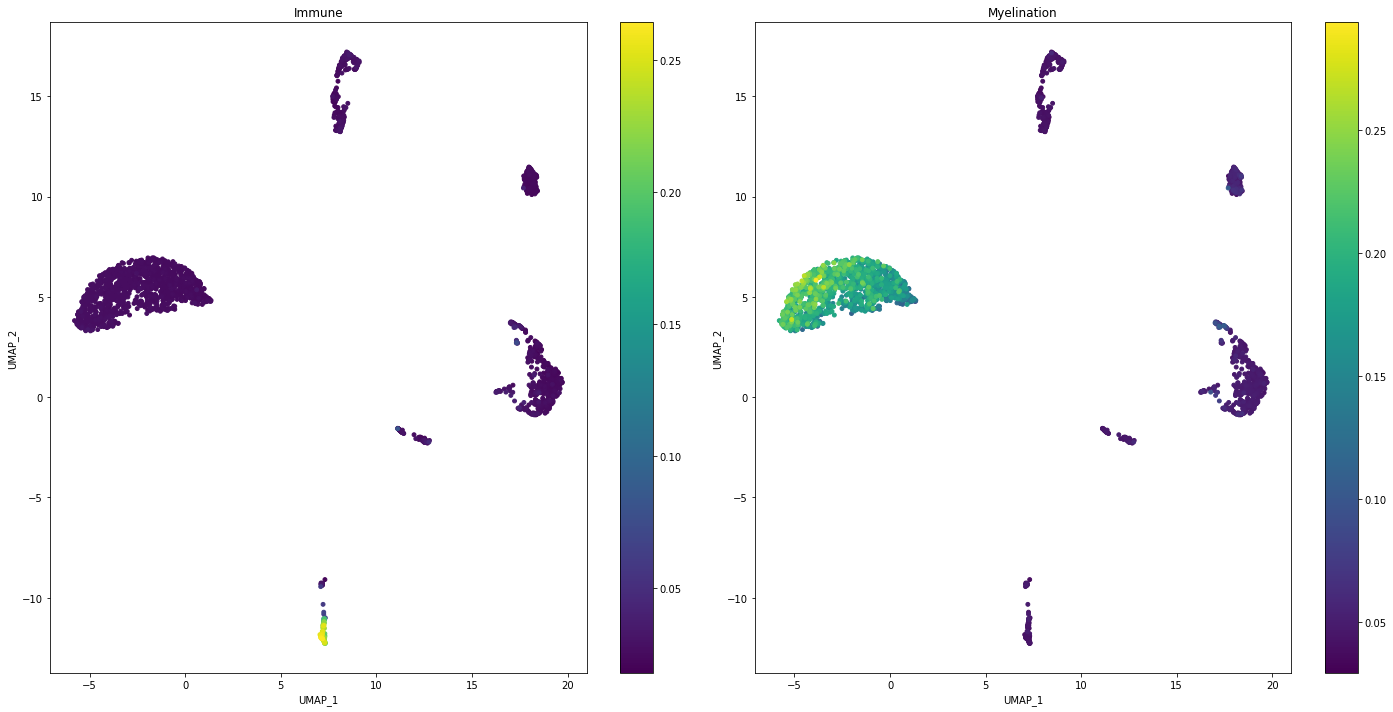

In [32]:
from pycisTopic.clust_vis import *
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['Immune', 'Myelination'], 
                 target='cell', num_columns=2,
                 text_size=24,
                 dot_size=15,
                 figsize=(20,10))

We find the immune response signature enriched in microglia and the myelination signature enriched in oligodendrocytes.

[[Back to top]](#top)